# Mechanistic Interpretability

## 1. Find induction heads where we know they exist. 

Take a GPT-2 or LLama model, visualize the attention patterns, and find the heads that seem to be doing induction. Additionally, see if you can automatically rank the heads by how much they attend to previous tokens like induction heads on synthetic samples `A B X_1 ... X_N A`. 

## 2. Apply the same two techniques to the ICL pretrained transformer

In [3]:
import os
from dotenv import load_dotenv

load_dotenv();

In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.activations import ActivationProbe

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [119]:
run = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 1, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:28: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:28: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(


In [120]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 0.12441930919885635,
 'pretrain/delta_dmmse': tensor(2.1063e-06, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.4842, device='mps:0'),
 'pretrain/token/0': 0.128984734416008,
 'pretrain/token/1': 0.11578716337680817,
 'pretrain/token/2': 0.1294461190700531,
 'pretrain/token/3': 0.12787997722625732,
 'pretrain/token/4': 0.12015783041715622,
 'pretrain/token/5': 0.12337923049926758,
 'pretrain/token/6': 0.12685617804527283,
 'pretrain/token/7': 0.12286321073770523,
 'true/mse': 5.102278709411621,
 'true/delta_dmmse': tensor(2.0311e-06, device='mps:0'),
 'true/delta_ridge': tensor(3.3949, device='mps:0'),
 'true/token/0': 5.236847400665283,
 'true/token/1': 5.373334884643555,
 'true/token/2': 5.324099540710449,
 'true/token/3': 4.976929664611816,
 'true/token/4': 5.1506547927856445,
 'true/token/5': 4.816932678222656,
 'true/token/6': 5.1901445388793945,
 'true/token/7': 4.749283790588379}

In [80]:
run.model

InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

In [121]:
from typing import Union


from torch import Tensor
from torch.nn.modules.module import Module


def prepend_dict(d: dict, prefix: str, delimiter="."):
    def get_key(key):
        if key == "":
            return prefix
        
        return f"{prefix}{delimiter}{key}"
    
    return {get_key(k): v for k, v in d.items()}


def hook(module: nn.Module):
    if isinstance(module, nn.ModuleList):
        return HookedList(module)
    elif isinstance(module, nn.Sequential):
        return HookedSequential(*module.children())
    else:
        return Hooked(module)


class Hooked(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self._module = module
        self._forward = type(module).forward
        
        for n, c in module.named_children():
            setattr(self, n, hook(c))
            
    @property
    def cache(self):
        cache = {
            "": self.output,
        }

        for n, c in self.named_children():
            if n == "_module" or n == "_forward":
                continue
            if hasattr(c, "cache"):
                cache.update(prepend_dict(c.cache, n))

        return cache
    
    def forward(self, *args, **kwargs):
        self.output = self._forward(self, *args, **kwargs)
        return self.output
    
    def run_with_cache(self, *args, **kwargs):
        output = self.forward(*args, **kwargs)
        cache = self.cache
        del cache[""]

        return output, cache
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self._module, name)
    

class HookedList(nn.ModuleList):
    def __init__(self, module_list: nn.ModuleList):
        modified_list = [hook(c) for c in module_list]
        super().__init__(modified_list)

    @property
    def cache(self):
        cache = {}

        for i, c in enumerate(self):
            if hasattr(c, "cache"):
                cache.update(prepend_dict(c.cache, str(i)))

        return cache
    
    
class HookedSequential(nn.Sequential):
    def __init__(self, *modules: nn.Module):
        # TODO: support OrderedDict
        super().__init__(*[hook(c) for c in modules])

    @property
    def cache(self):
        cache = {}

        for i, c in enumerate(self):
            if hasattr(c, "cache"):
                cache.update(prepend_dict(c.cache, str(i)))

        return cache
    
    def run_with_cache(self, *args, **kwargs):
        output = self.forward(*args, **kwargs)
        return output, self.cache
    

hooked_model = Hooked(run.model)
print(hooked_model._module)
list(hooked_model.named_children())

InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)


[('_module',
  InContextRegressionTransformer(
    (token_sequence_transformer): DTransformer(
      (token_embedding): Linear(in_features=5, out_features=64, bias=False)
      (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
      (blocks): ModuleList(
        (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
          (attention): MultiHeadedCausalSelfAttention(
            (attention): Linear(in_features=64, out_features=192, bias=False)
            (attention_softmax): Softmax(dim=-1)
          )
          (compute): Sequential(
            (0): Linear(in_features=64, out_features=64, bias=True)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=True)
          )
          (layer_norms): ModuleList(
            (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (unembedding): Sequential(
        (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (1): Lin

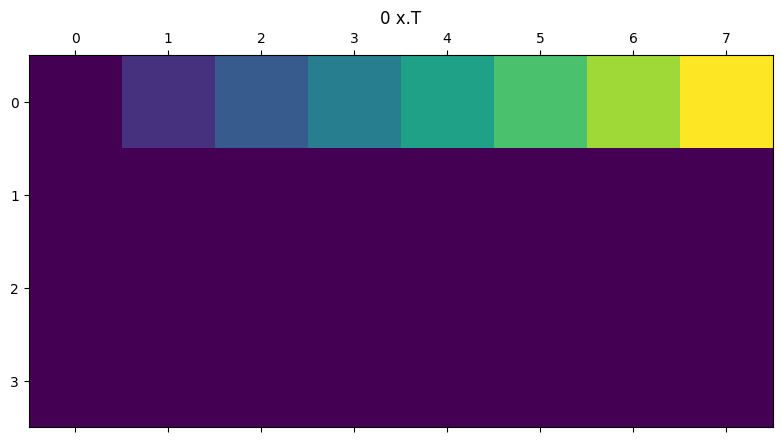

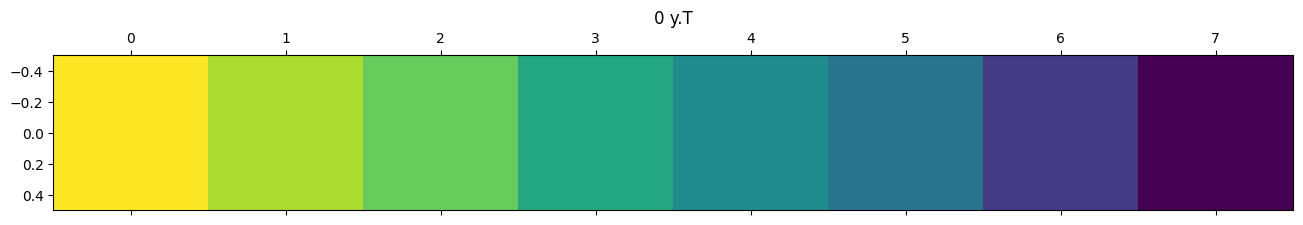

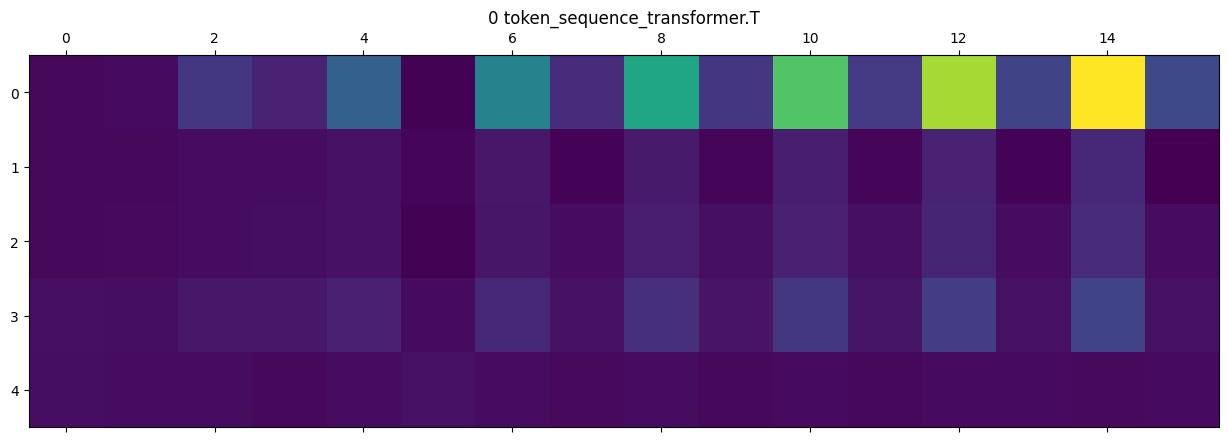

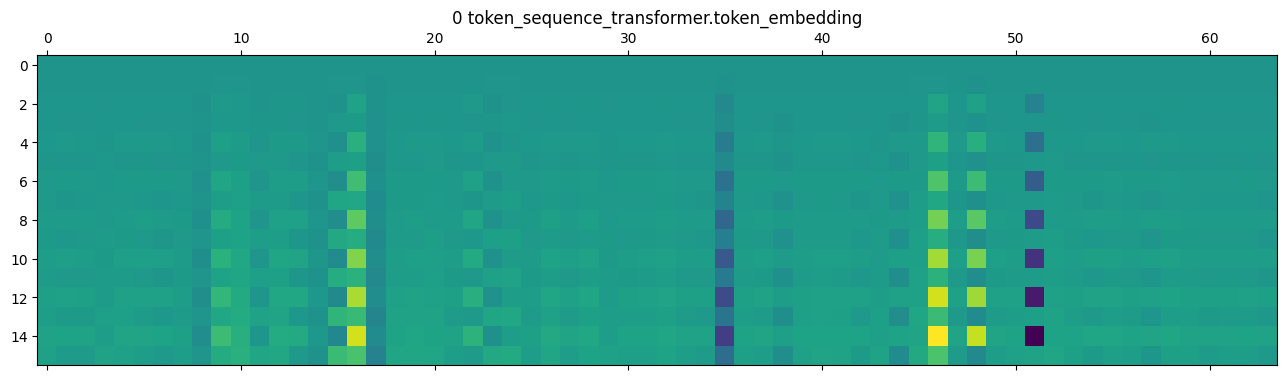

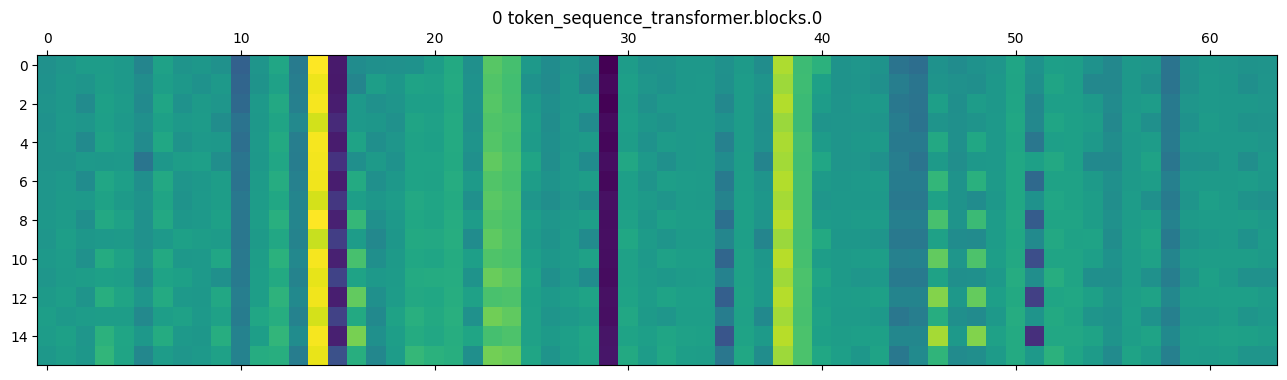

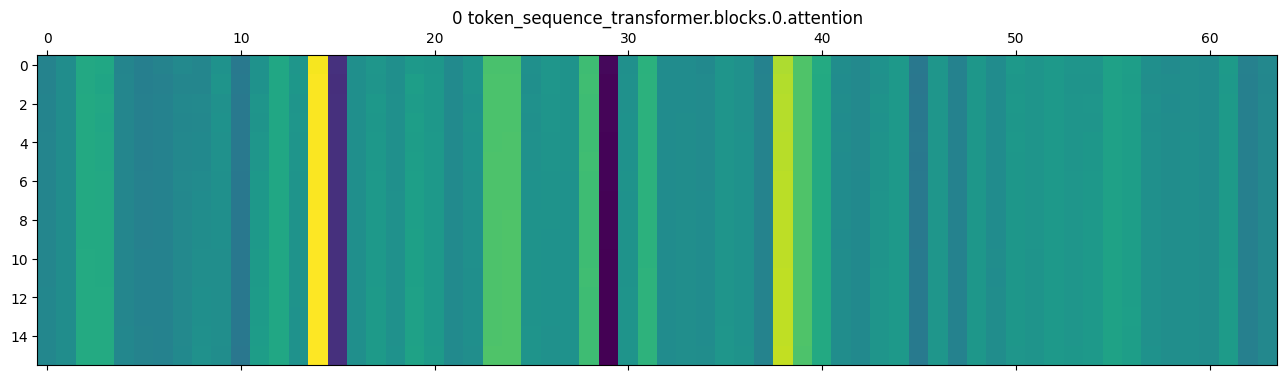

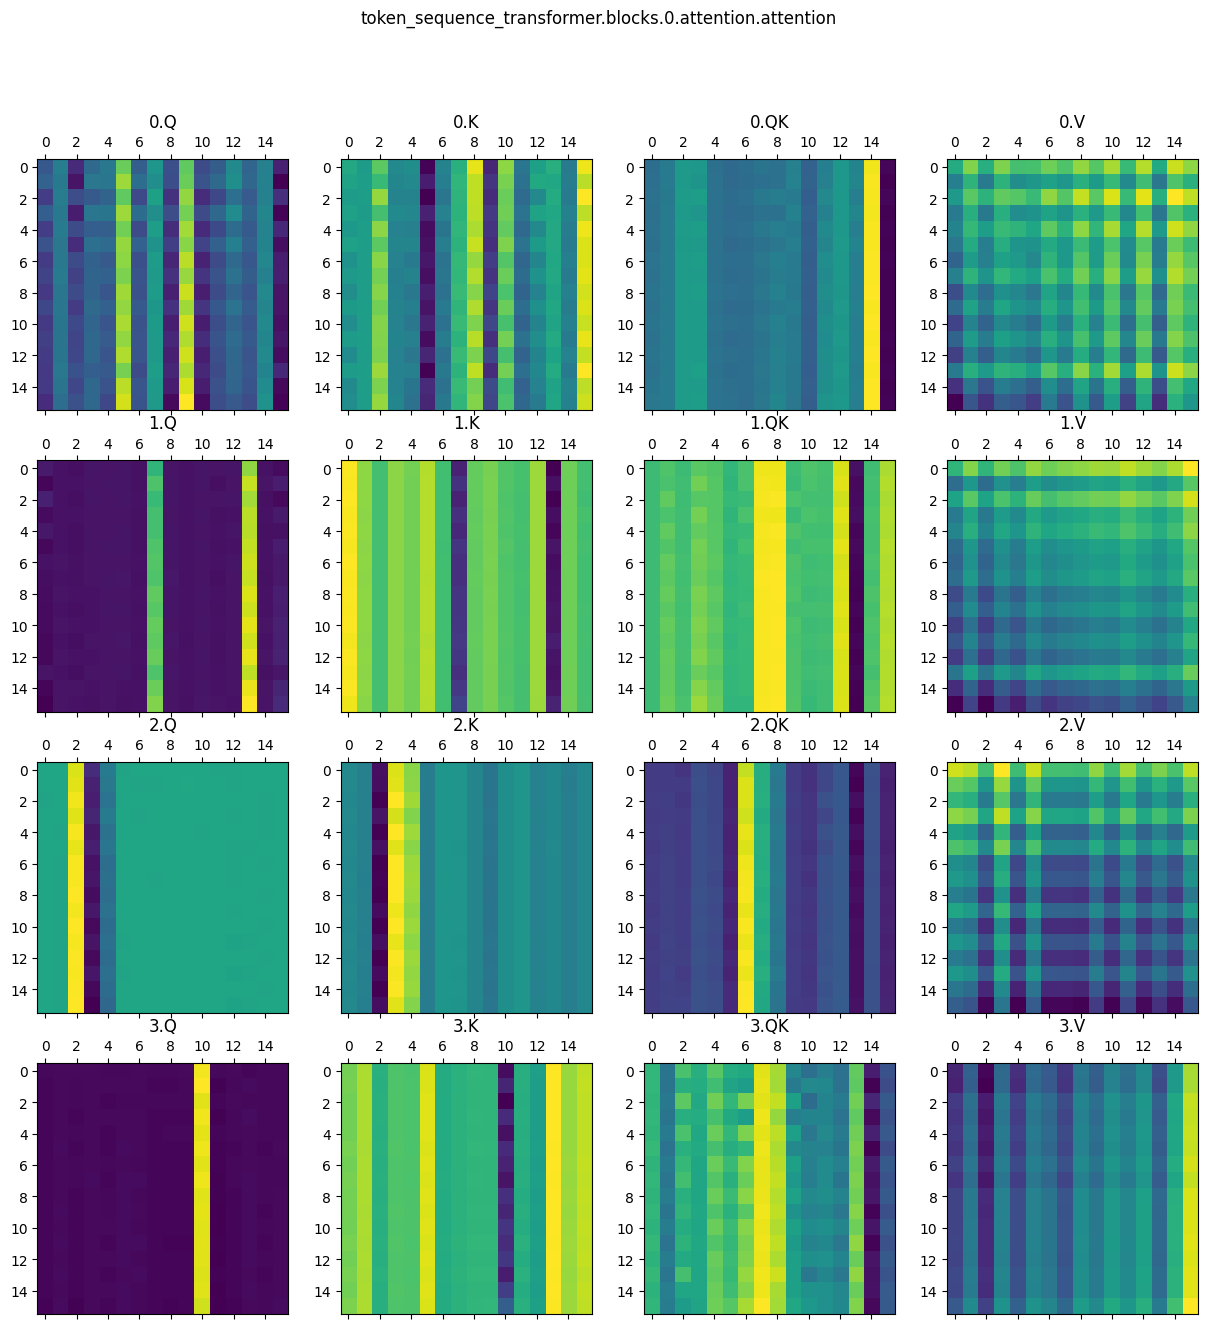

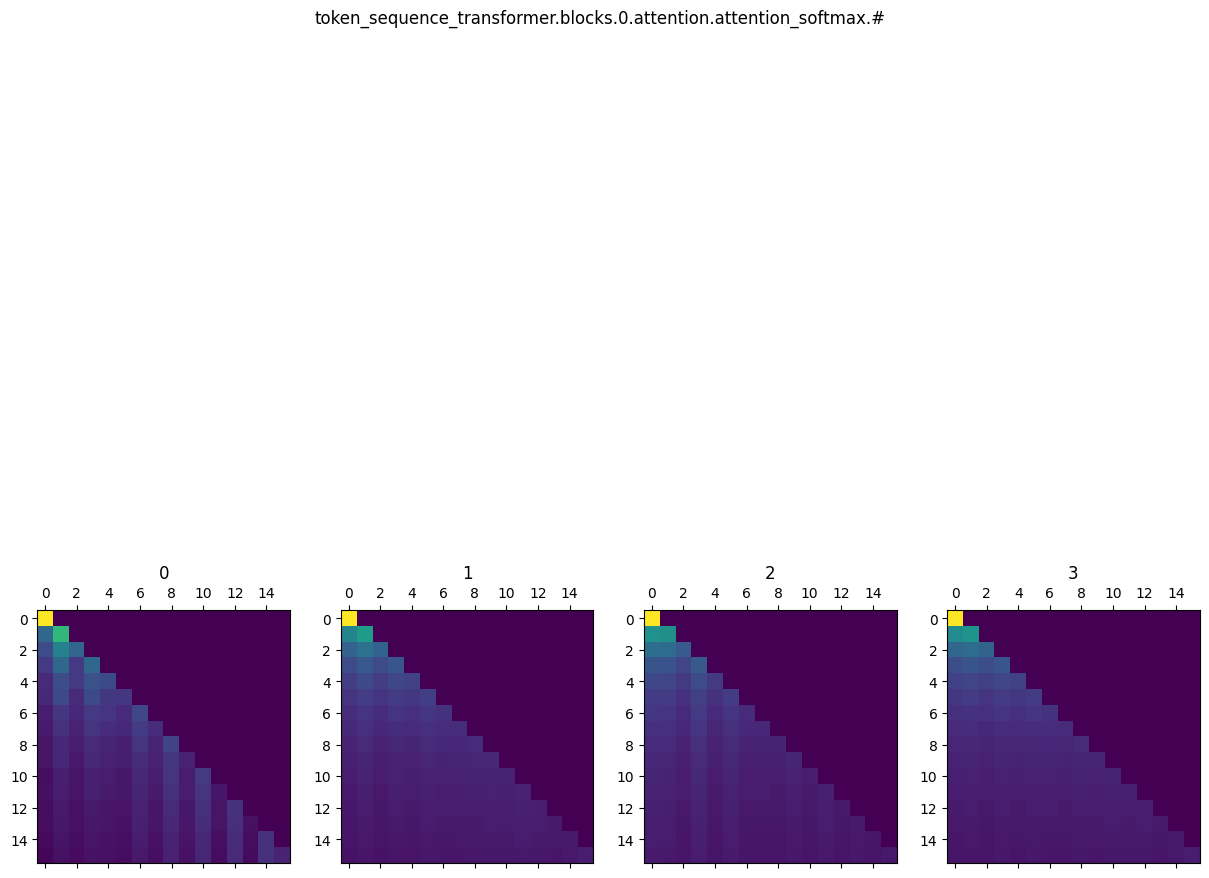

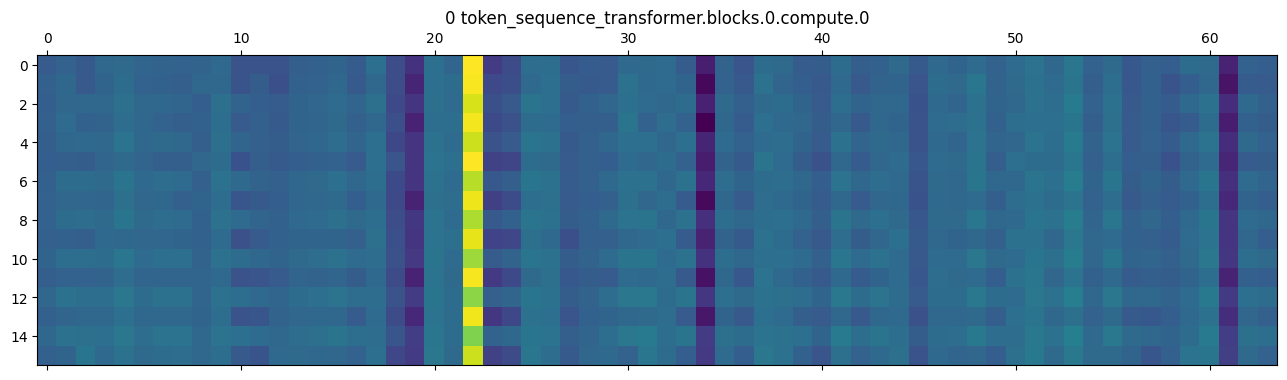

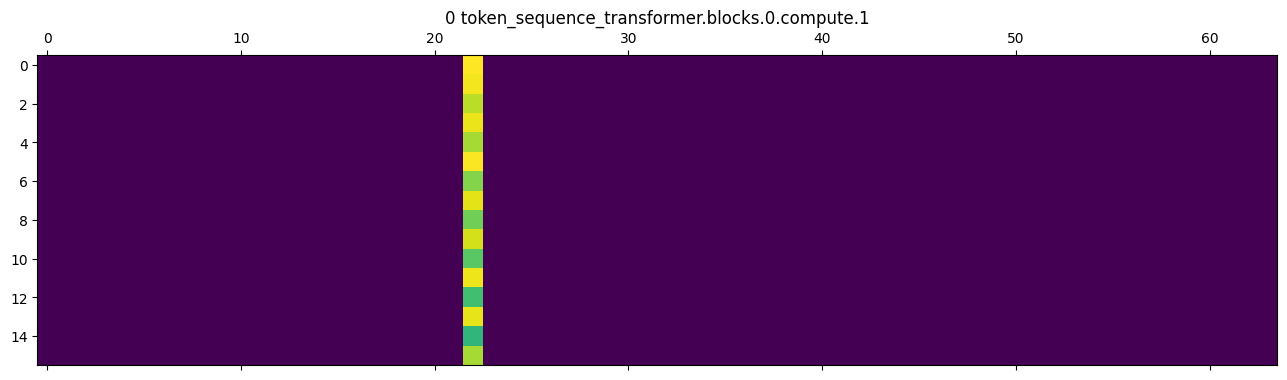

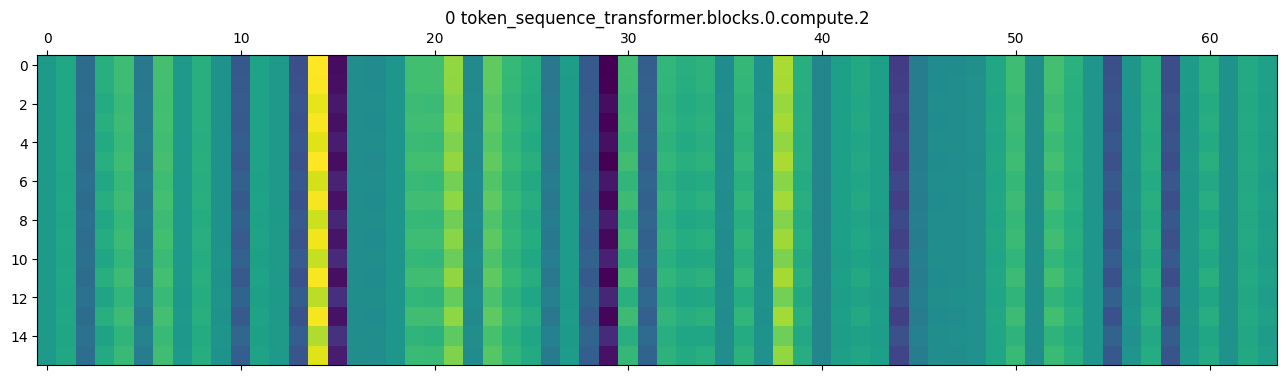

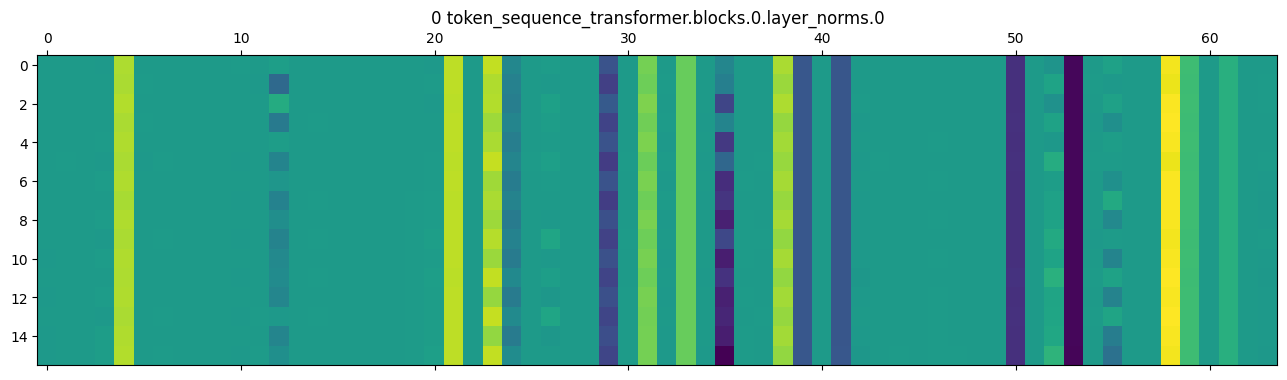

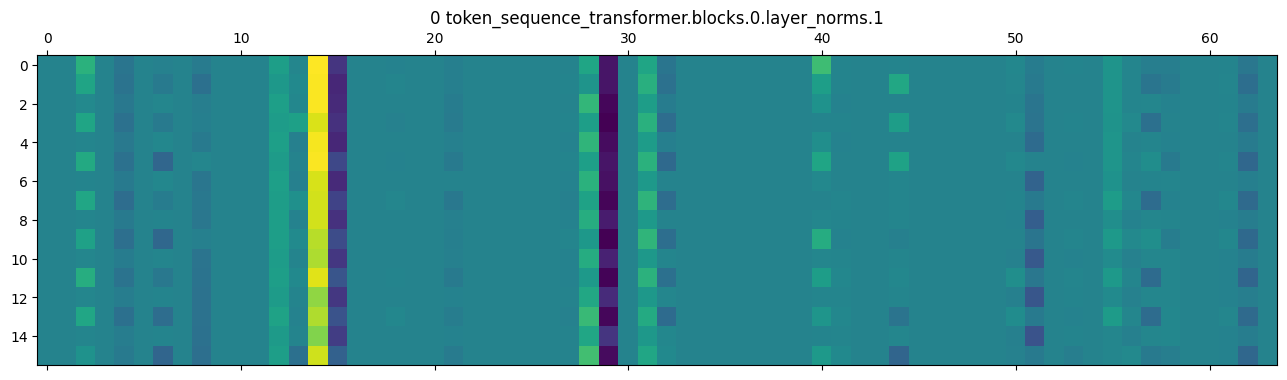

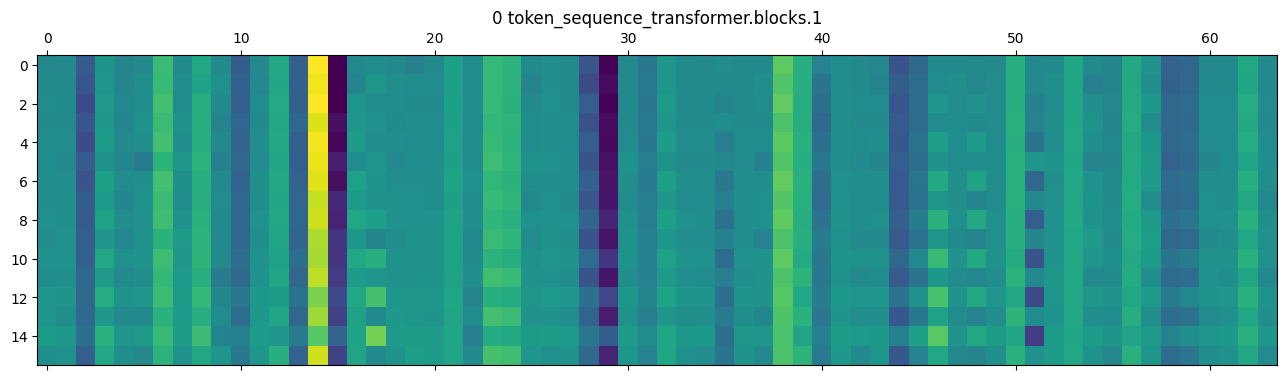

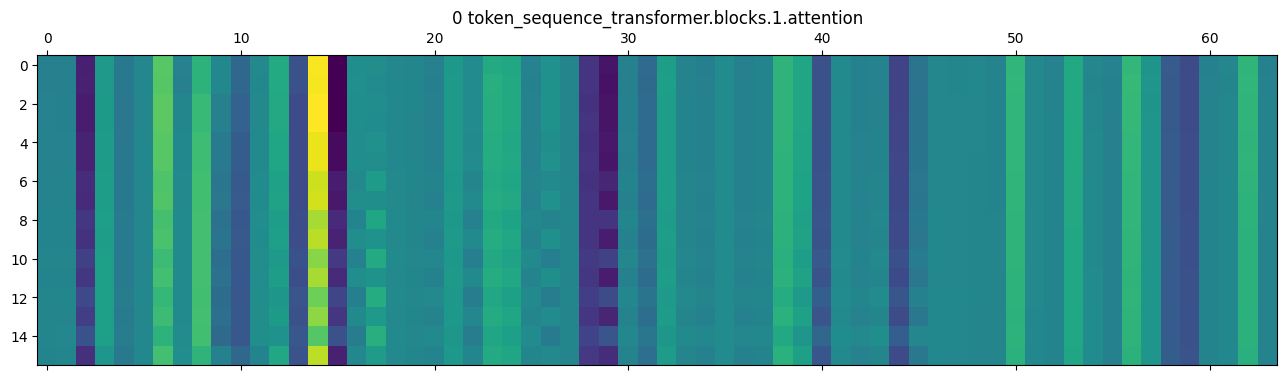

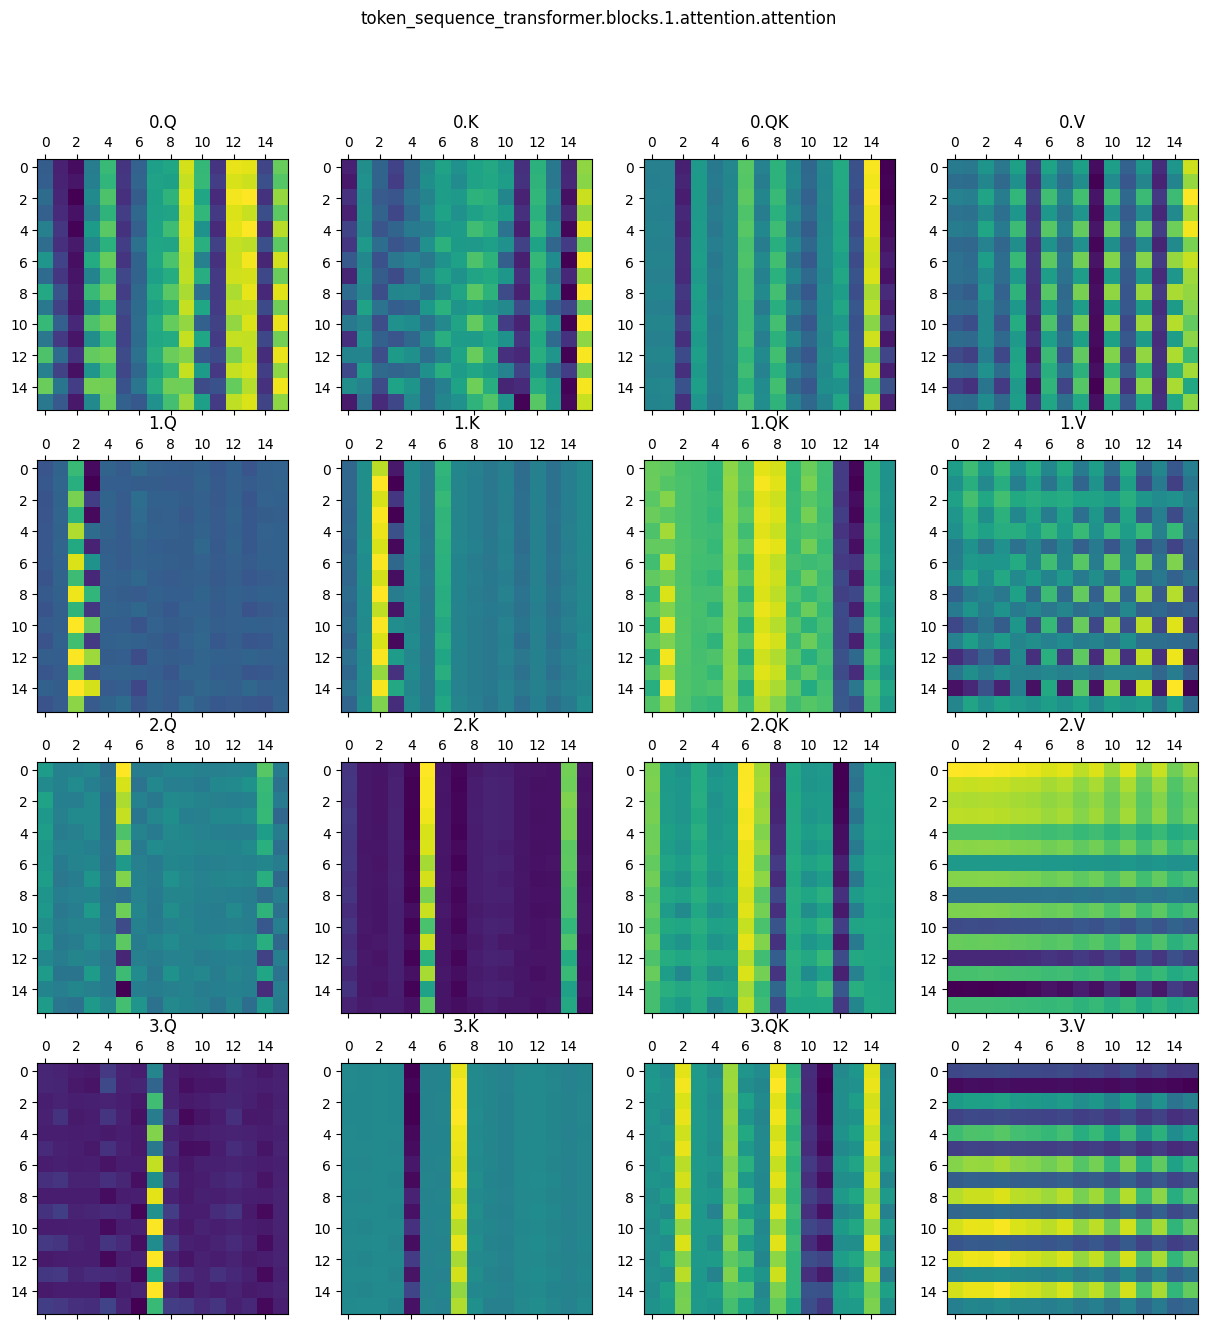

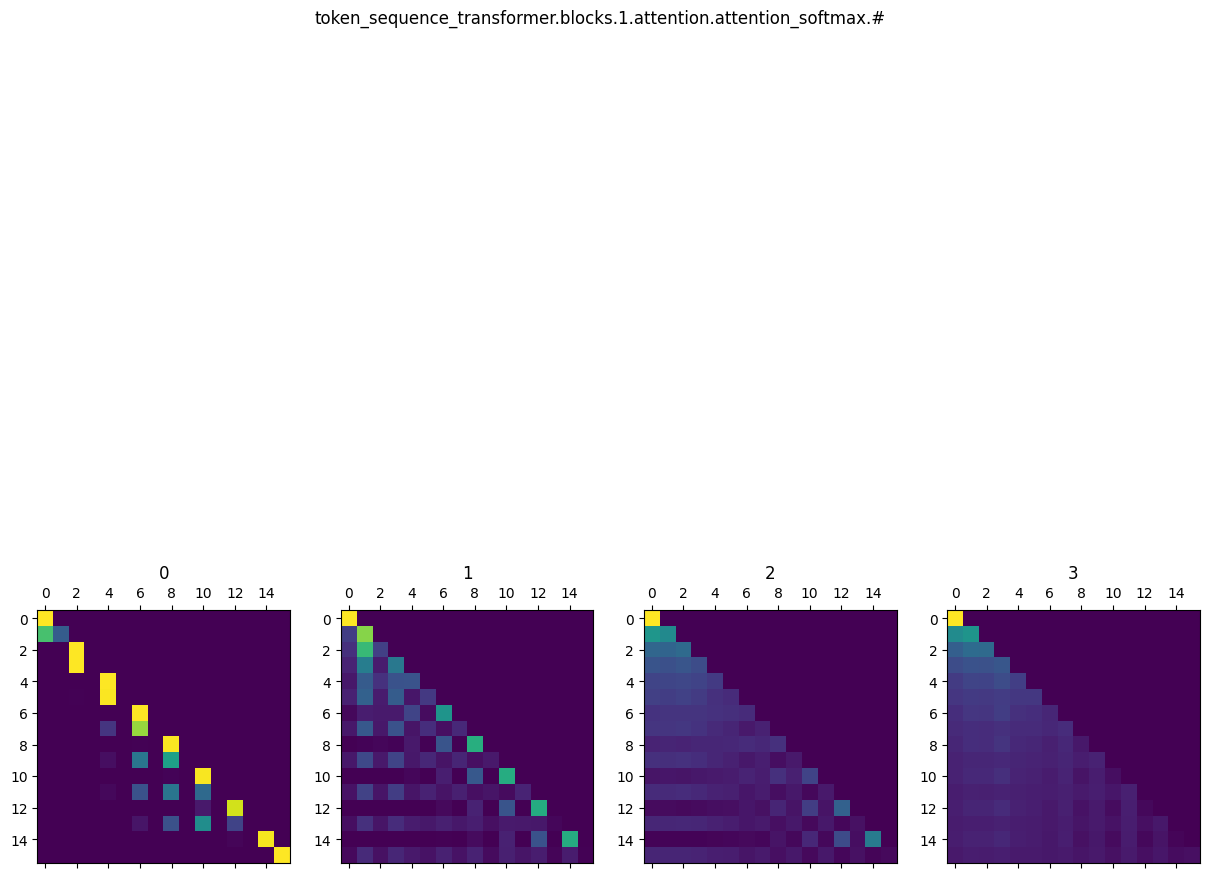

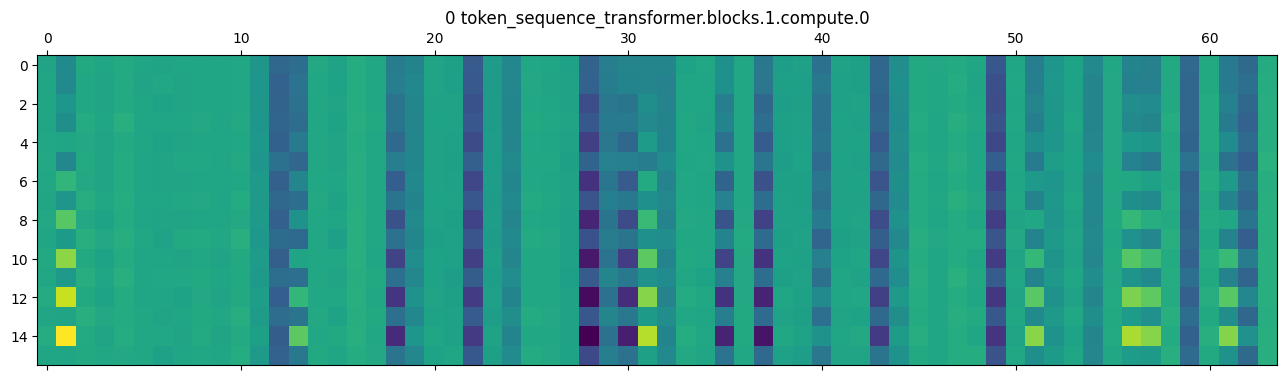

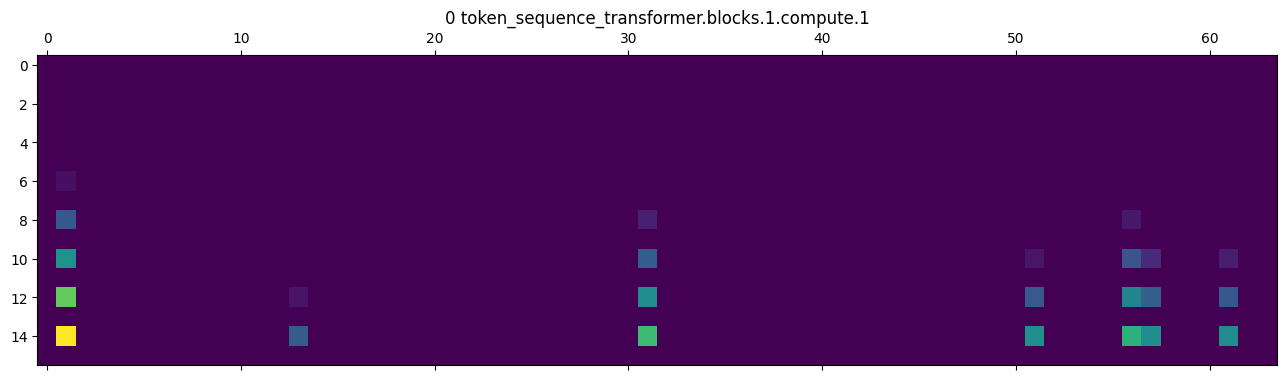

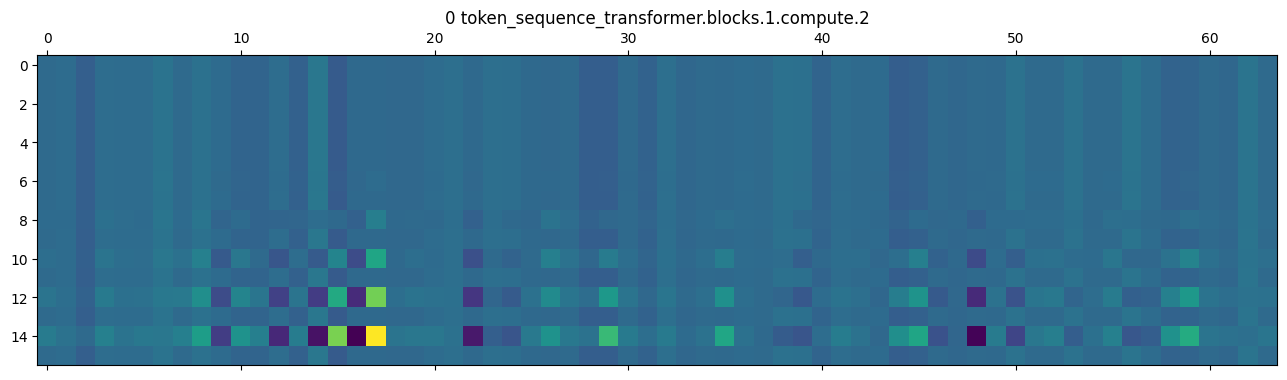

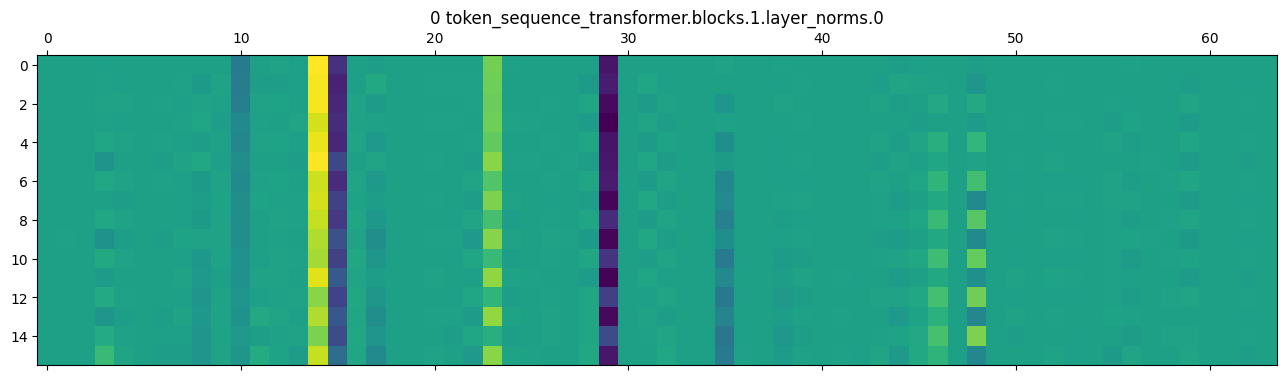

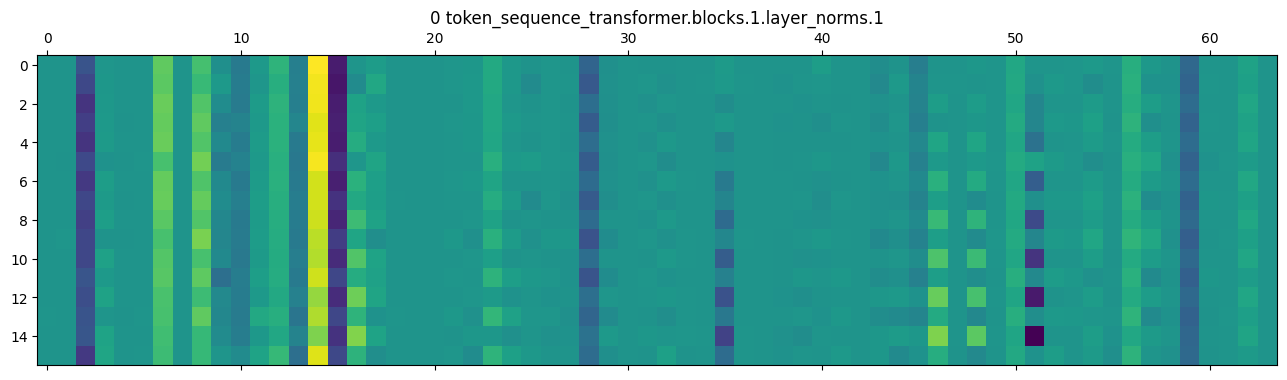

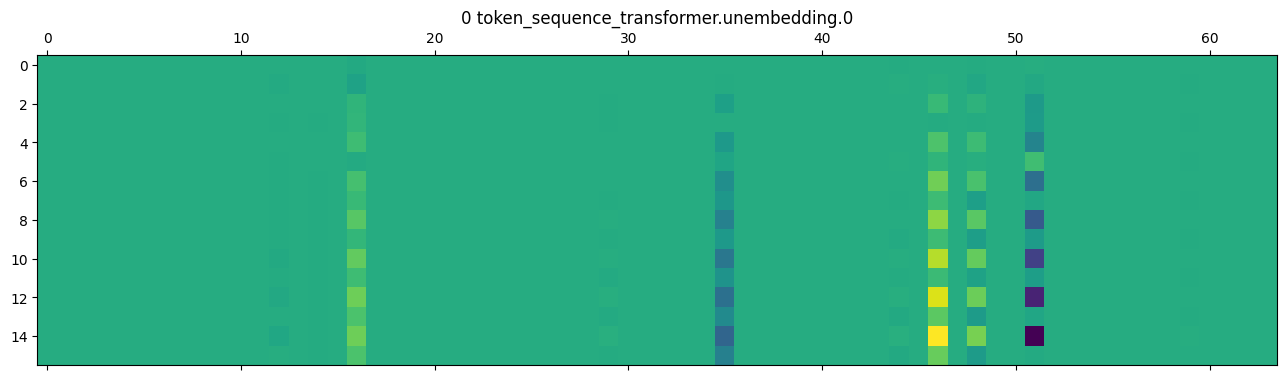

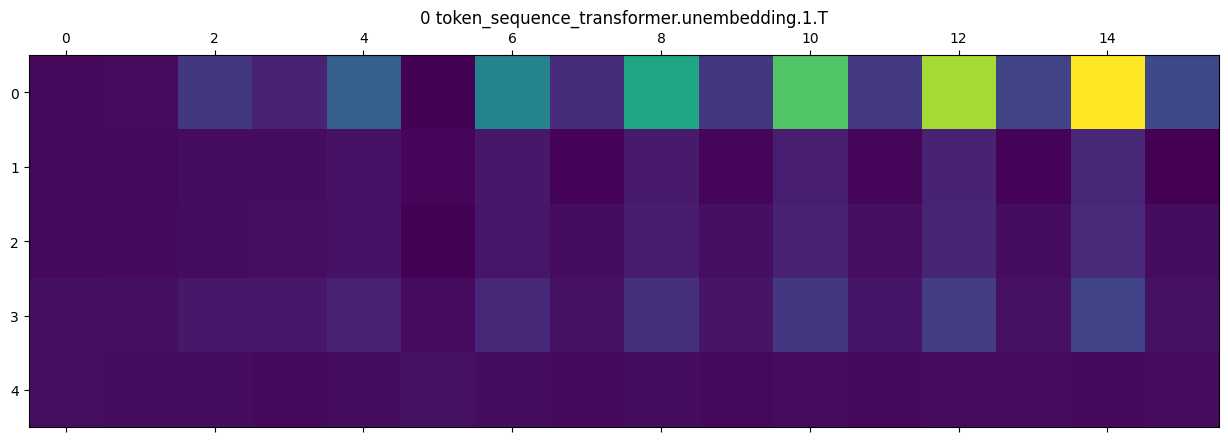

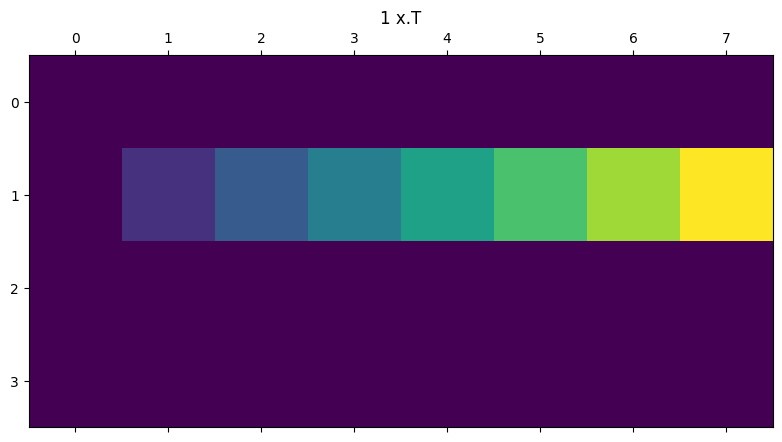

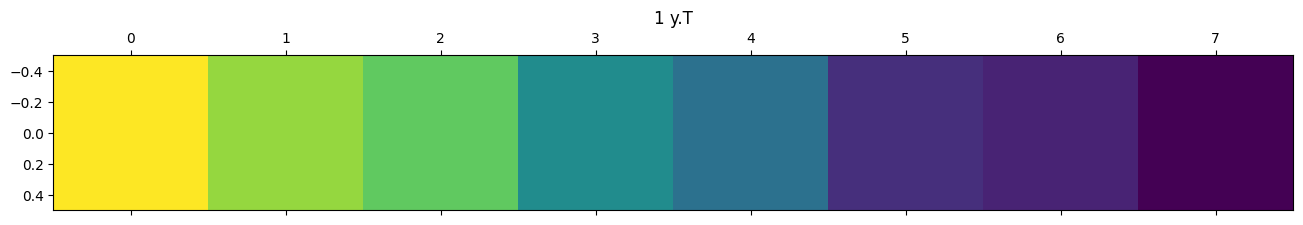

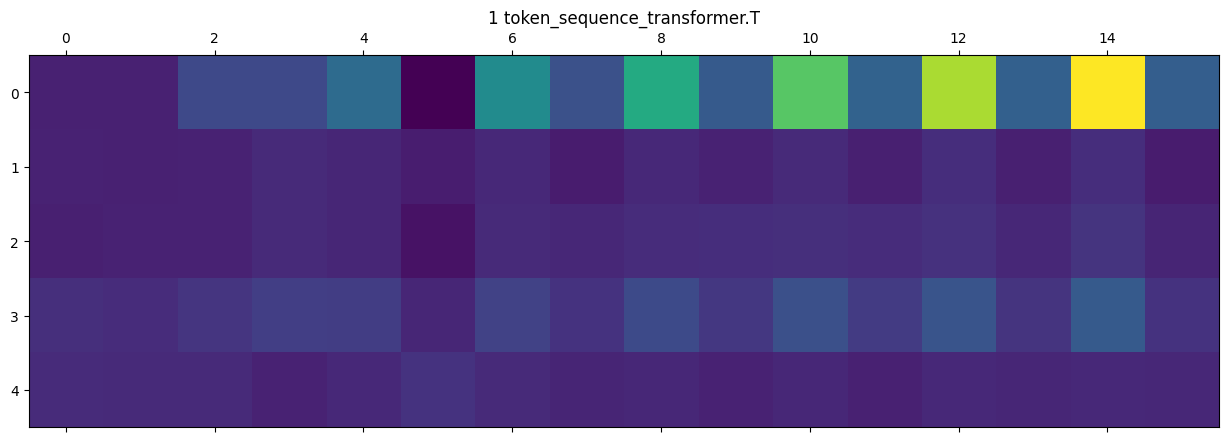

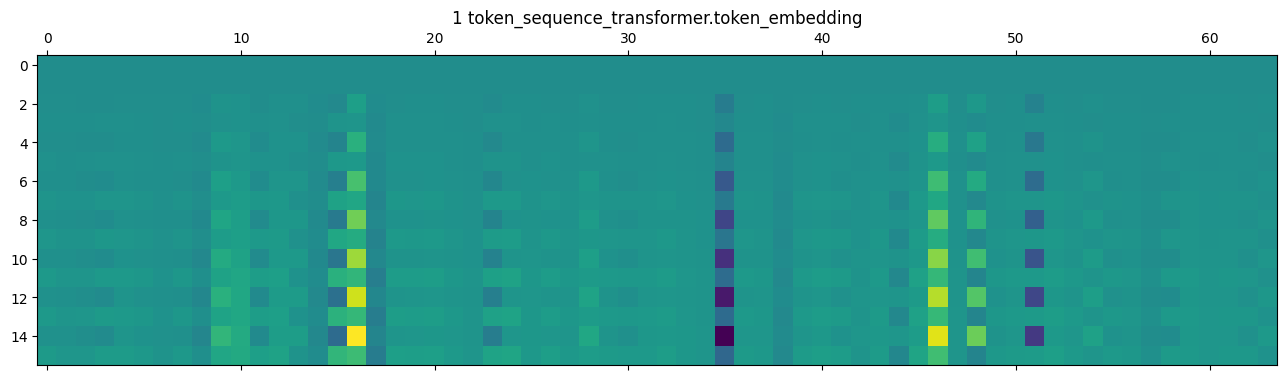

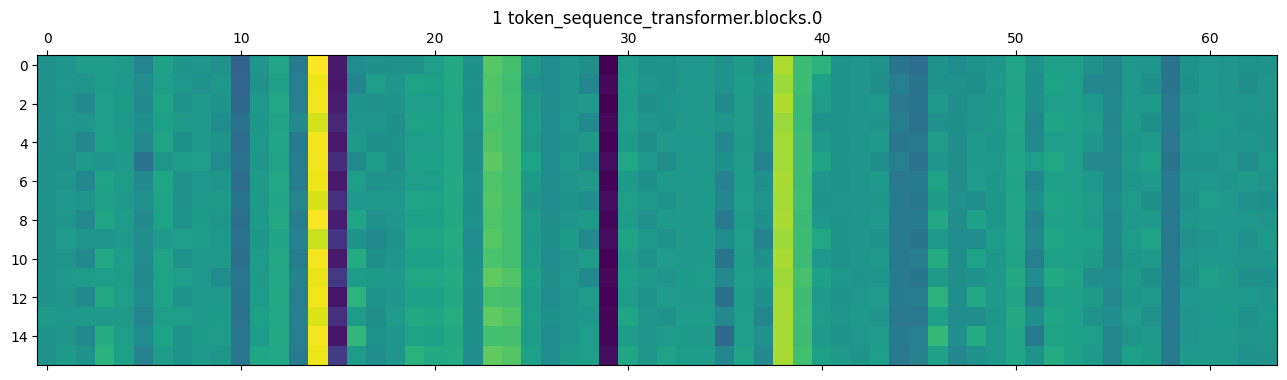

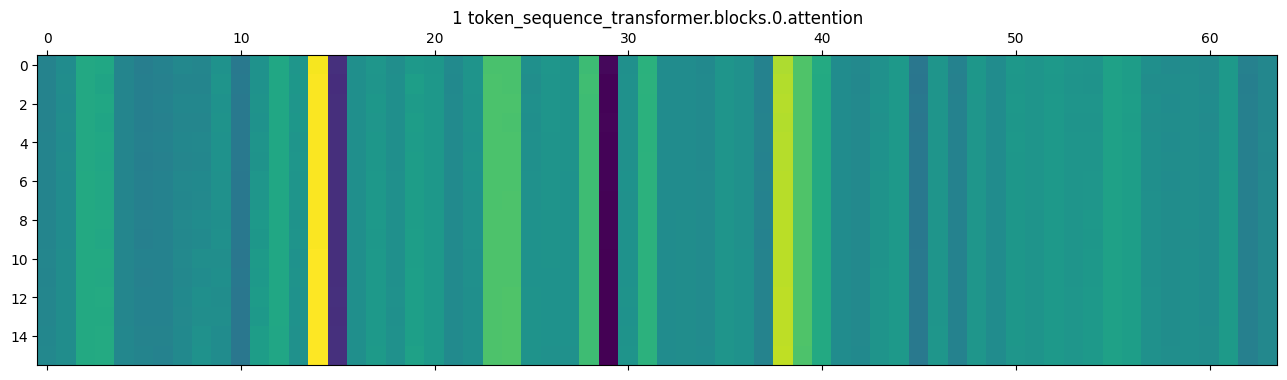

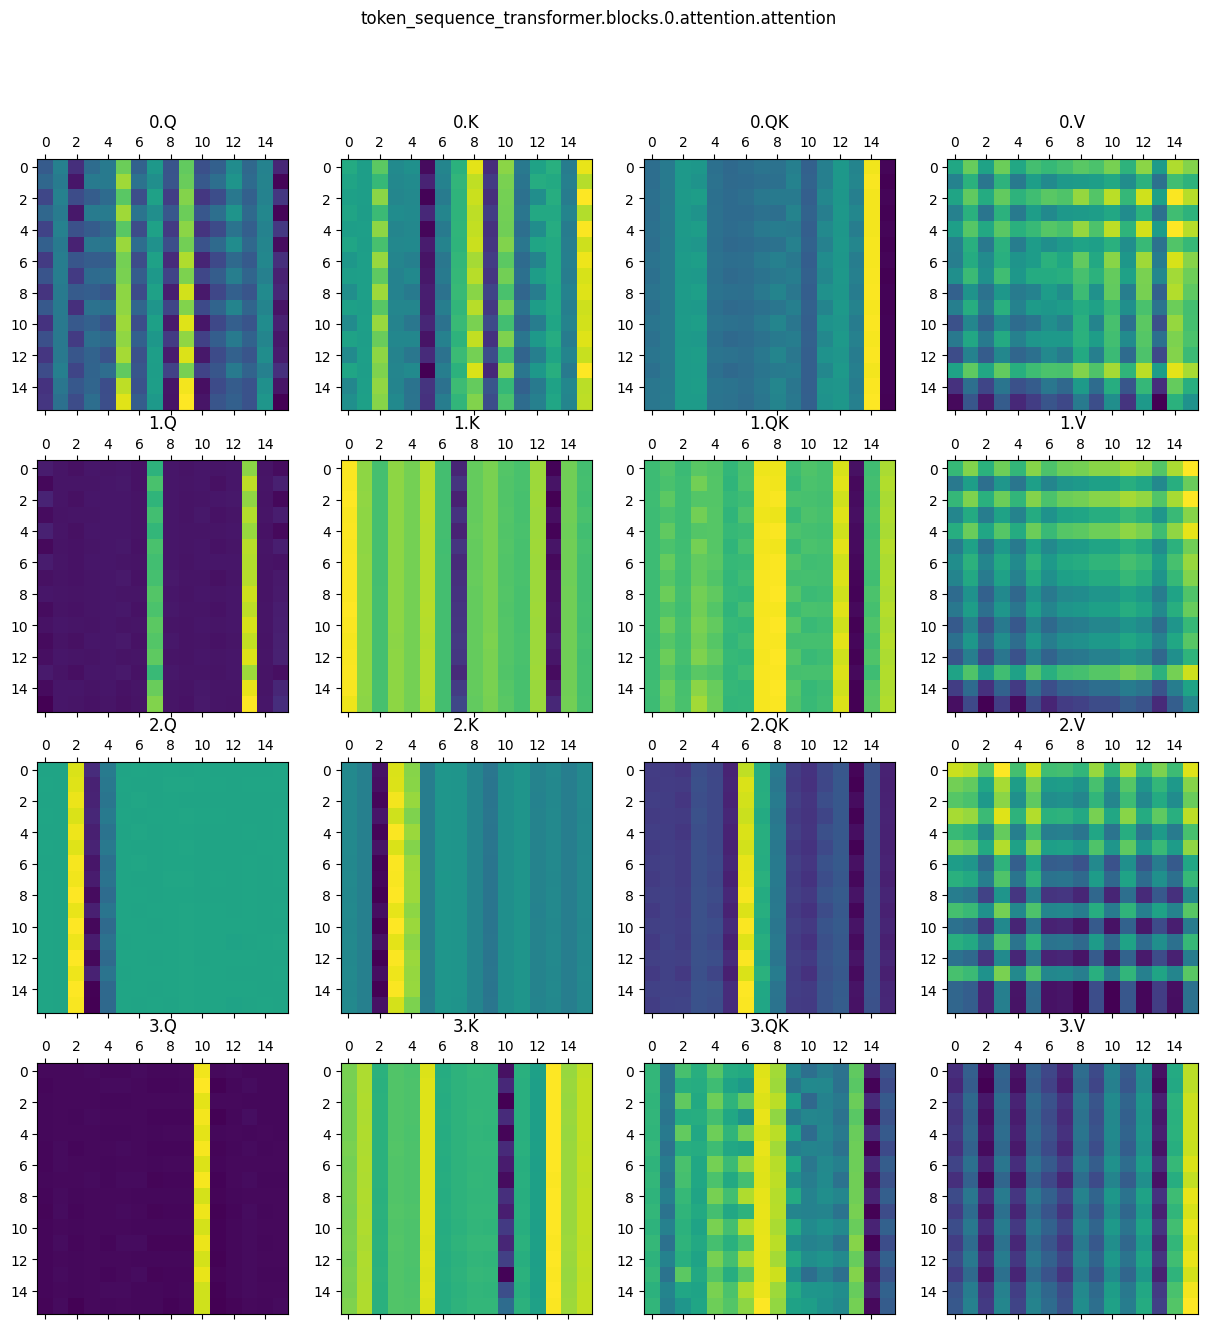

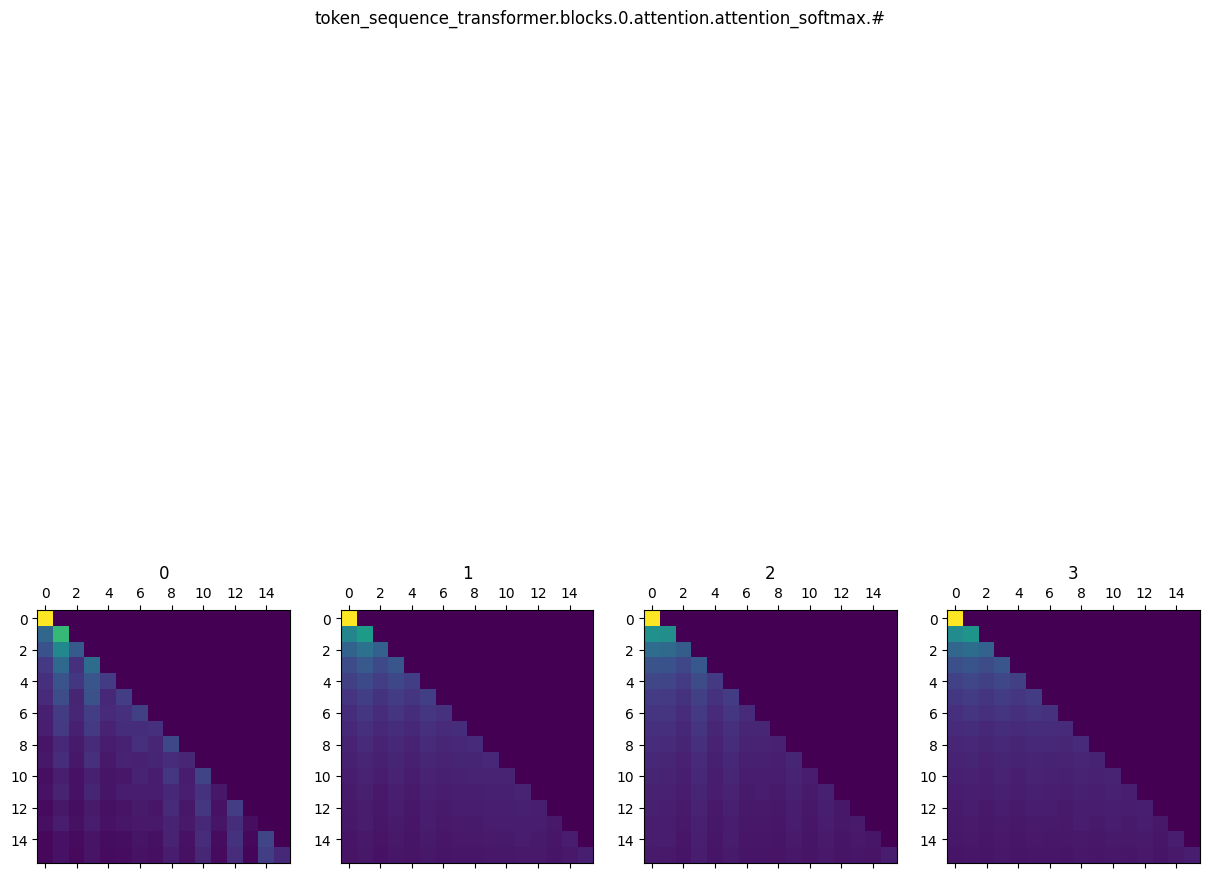

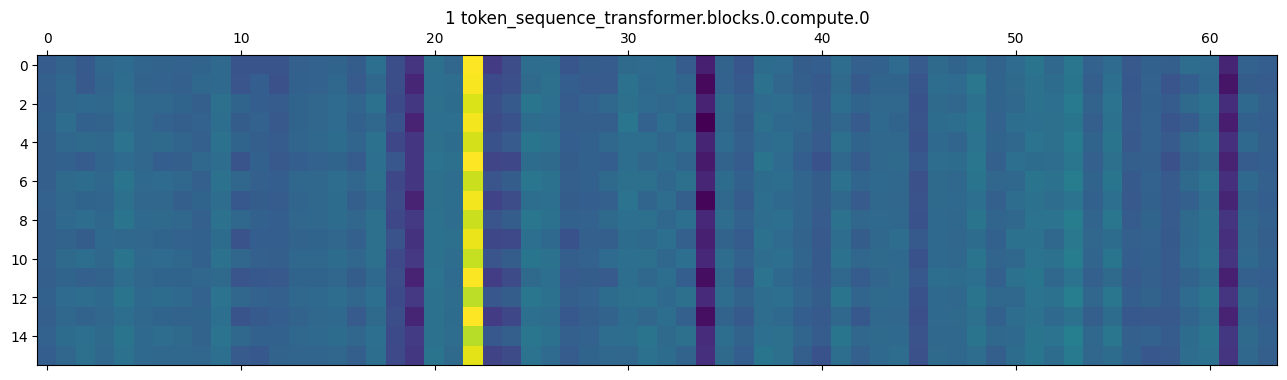

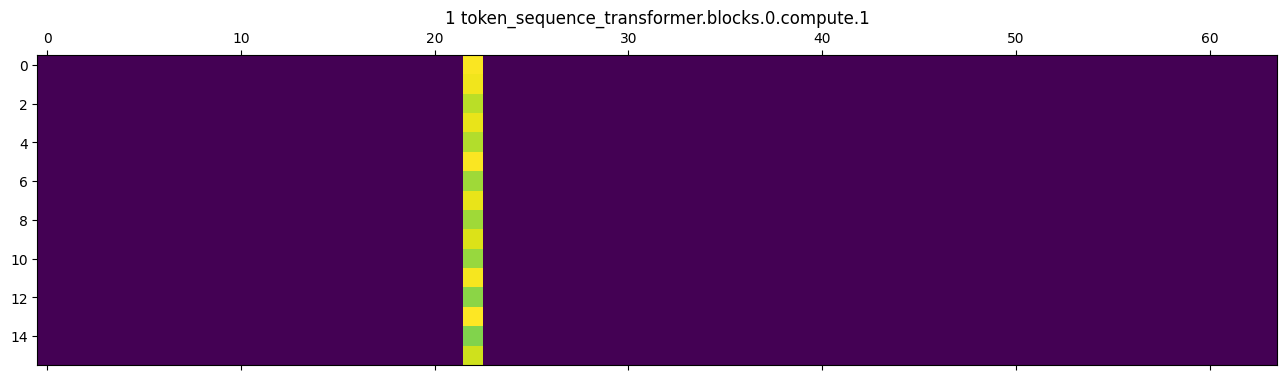

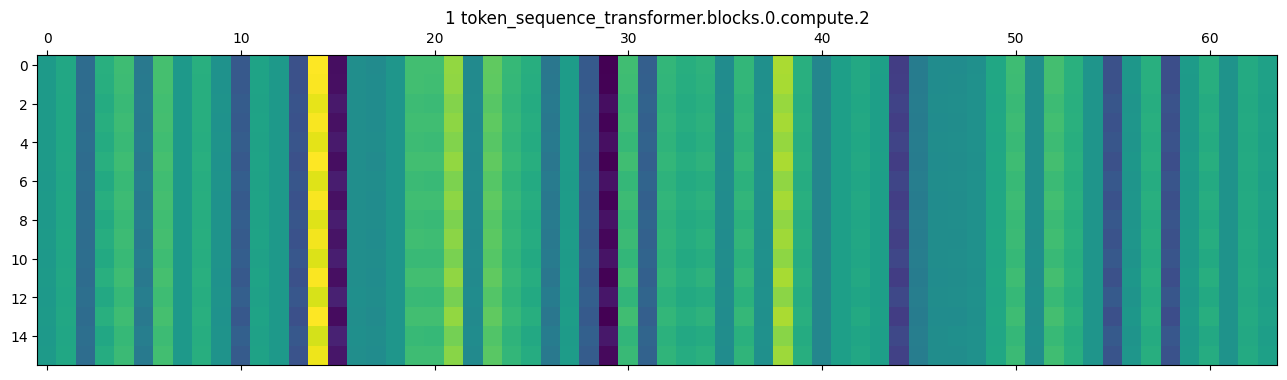

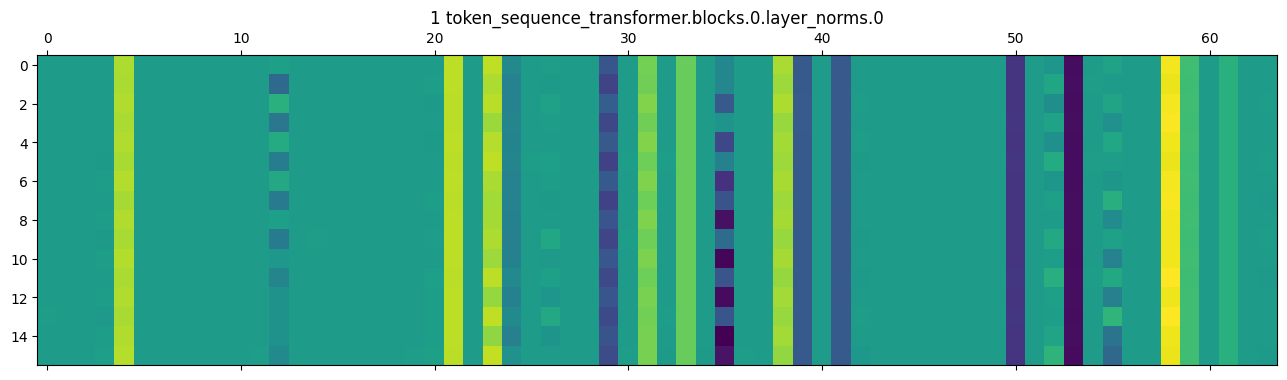

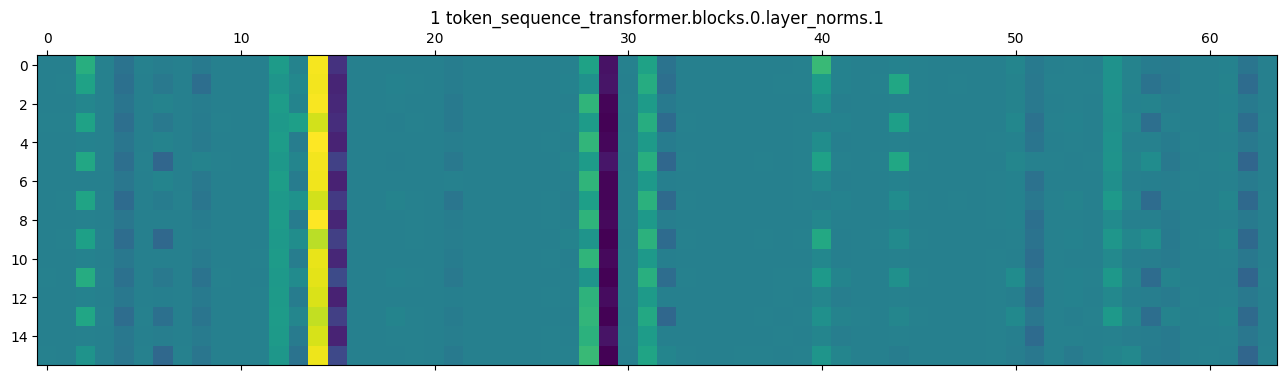

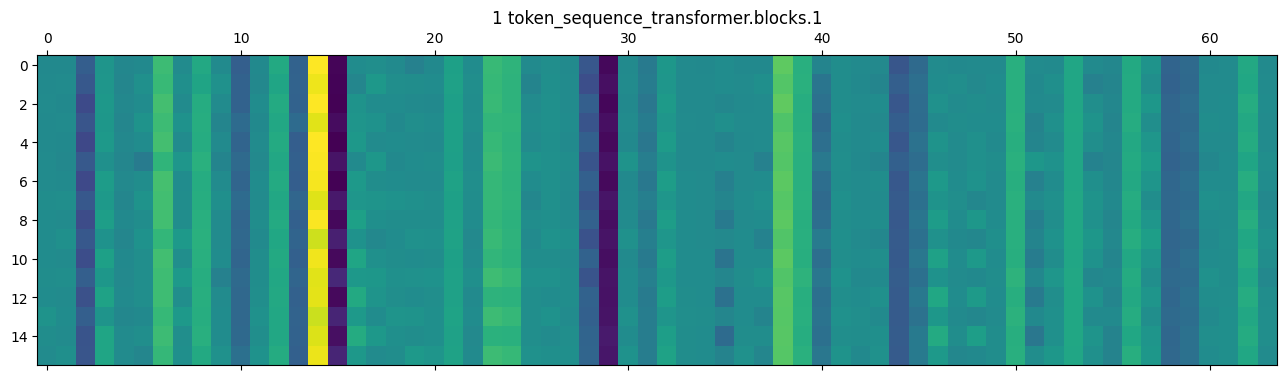

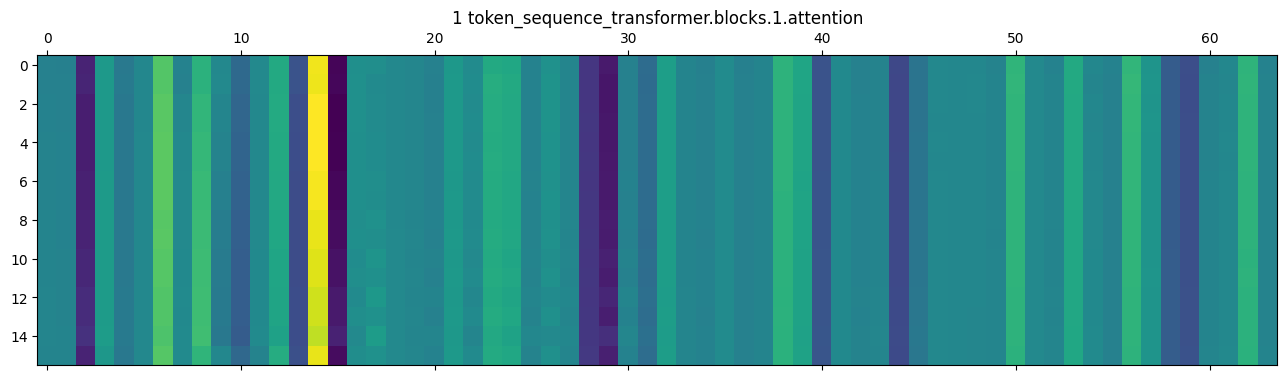

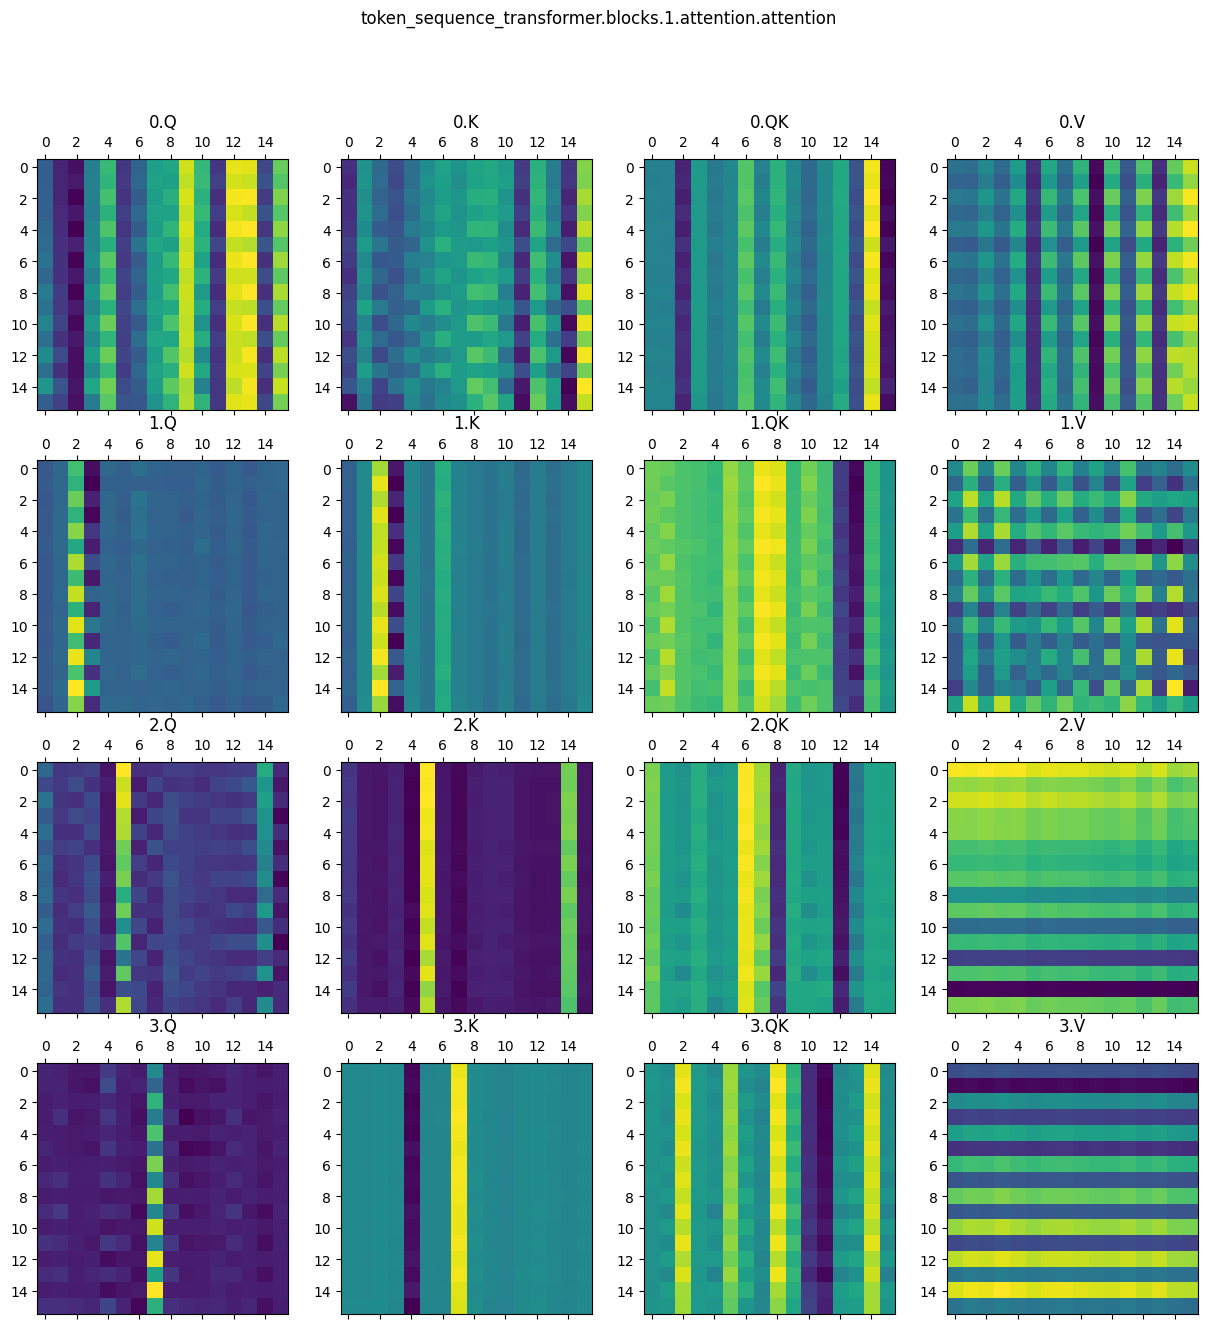

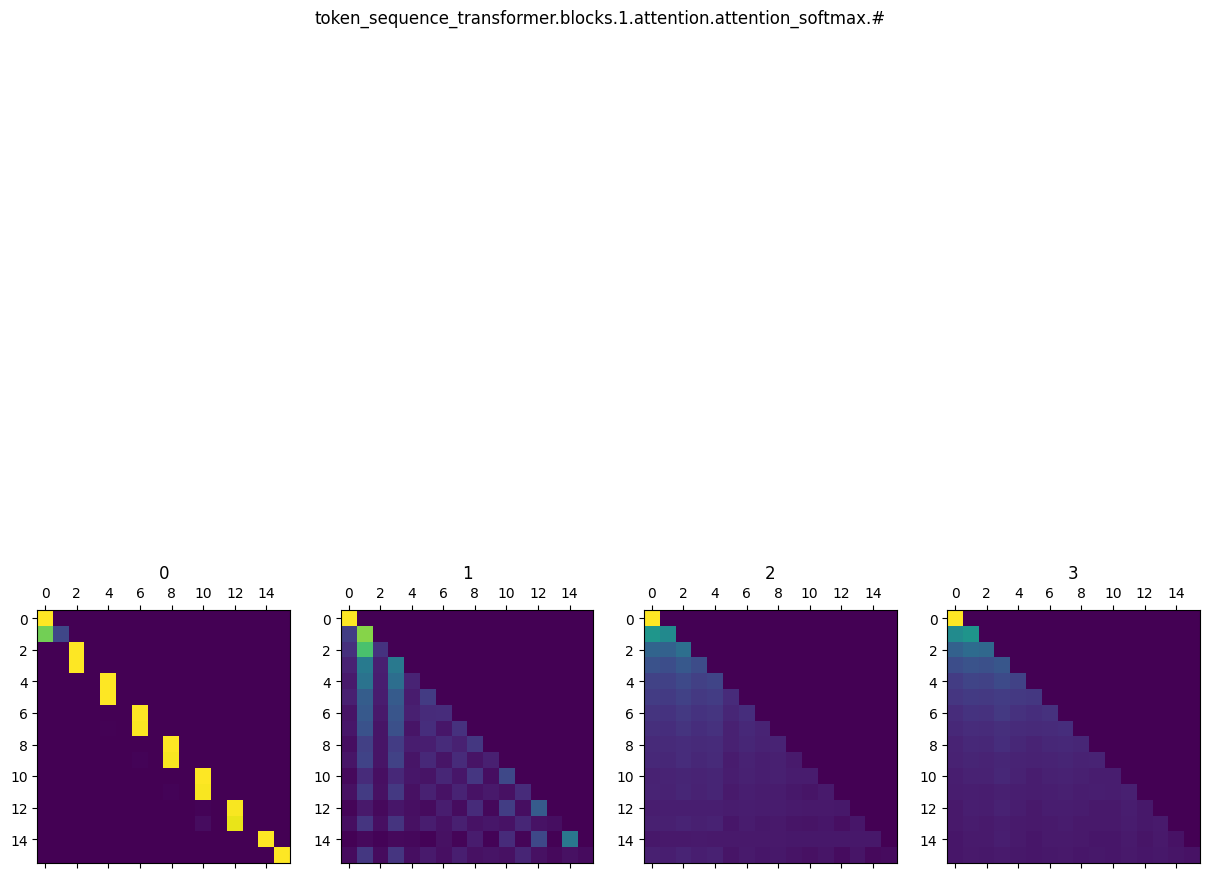

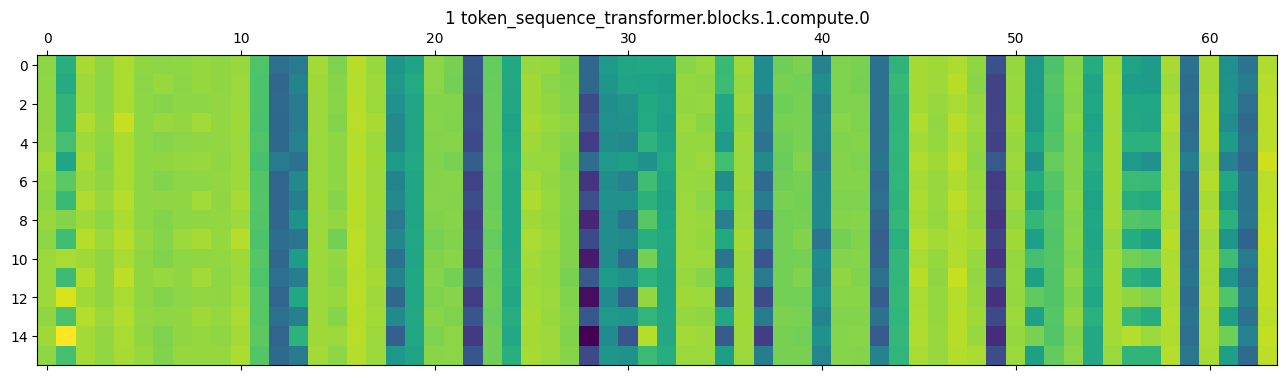

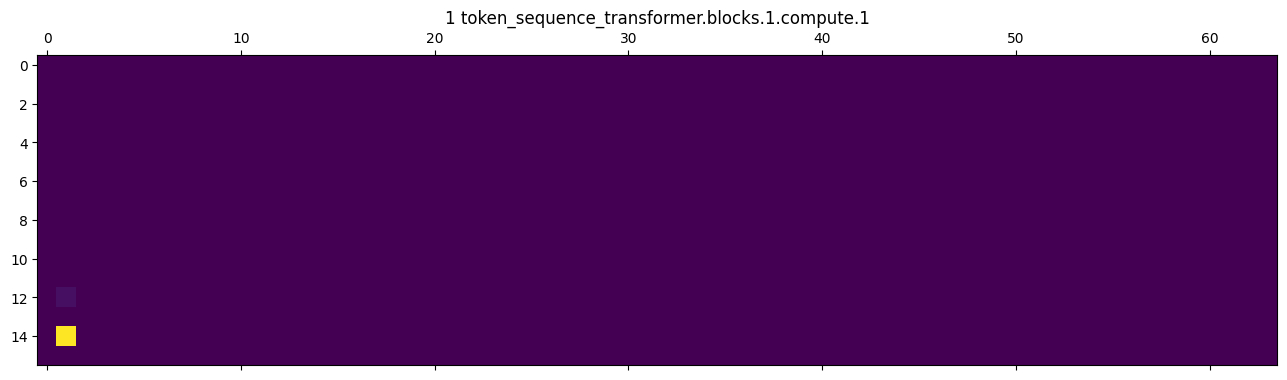

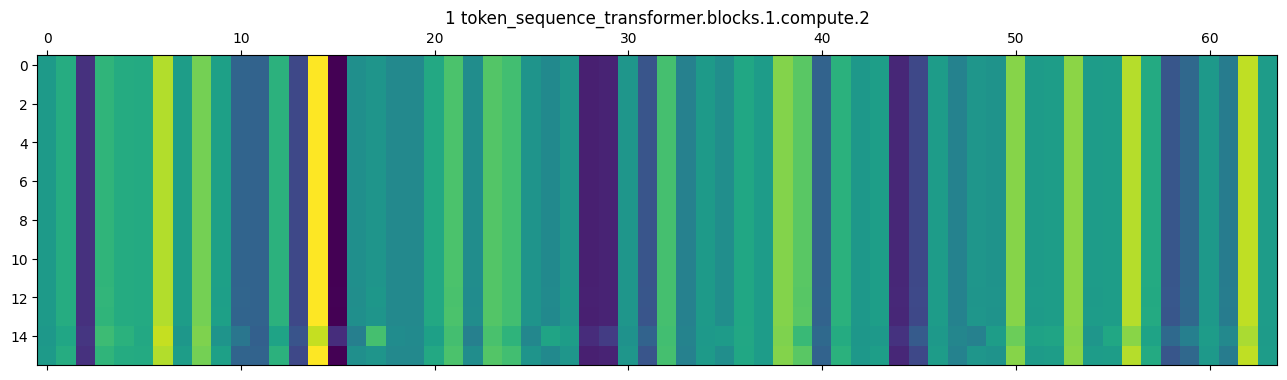

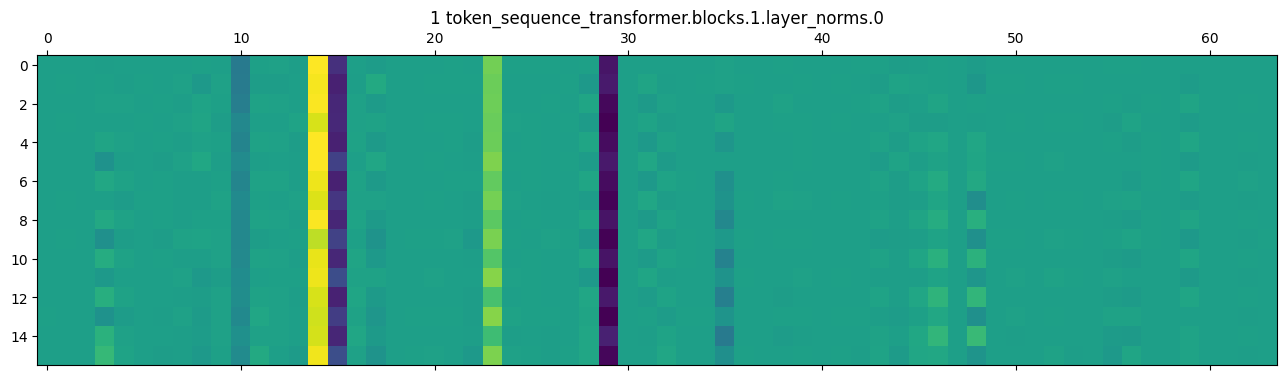

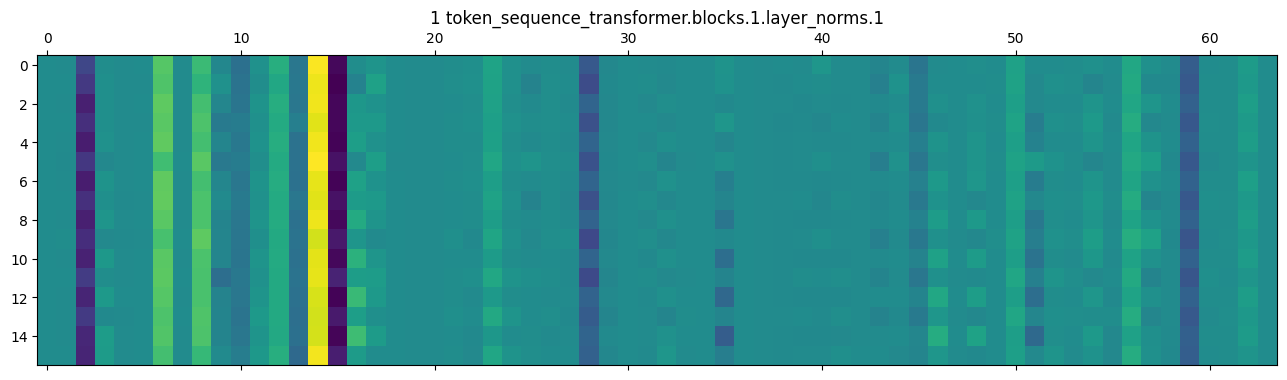

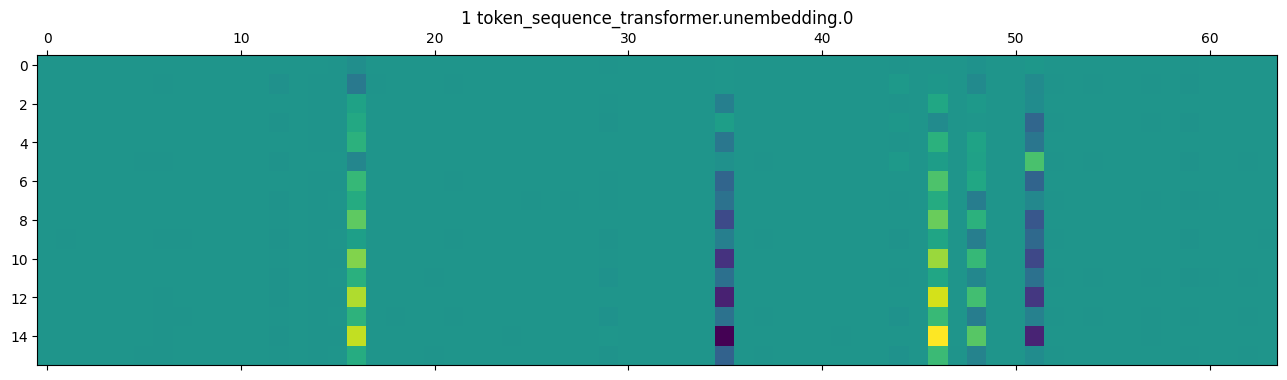

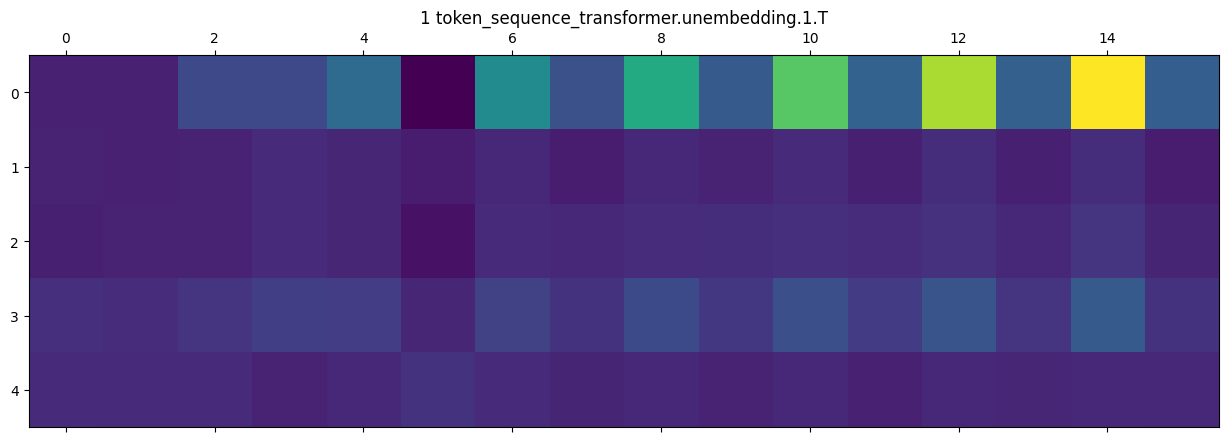

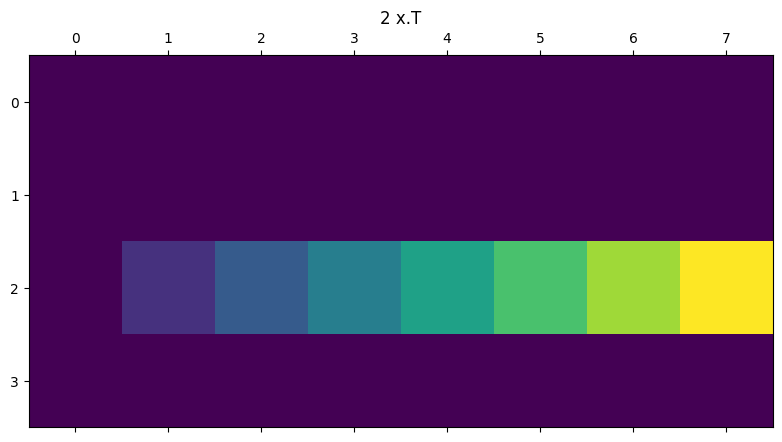

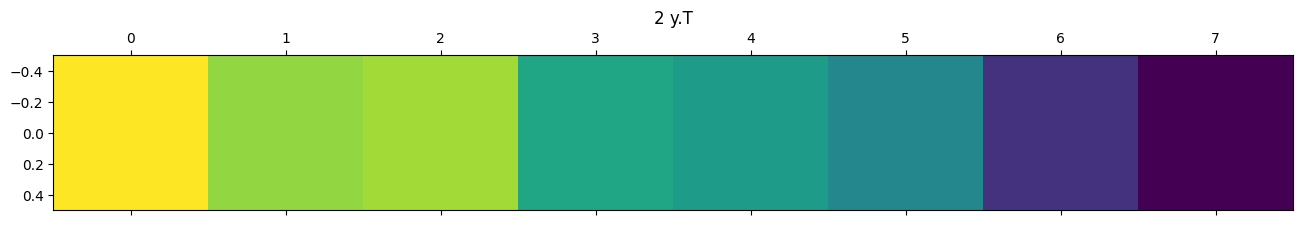

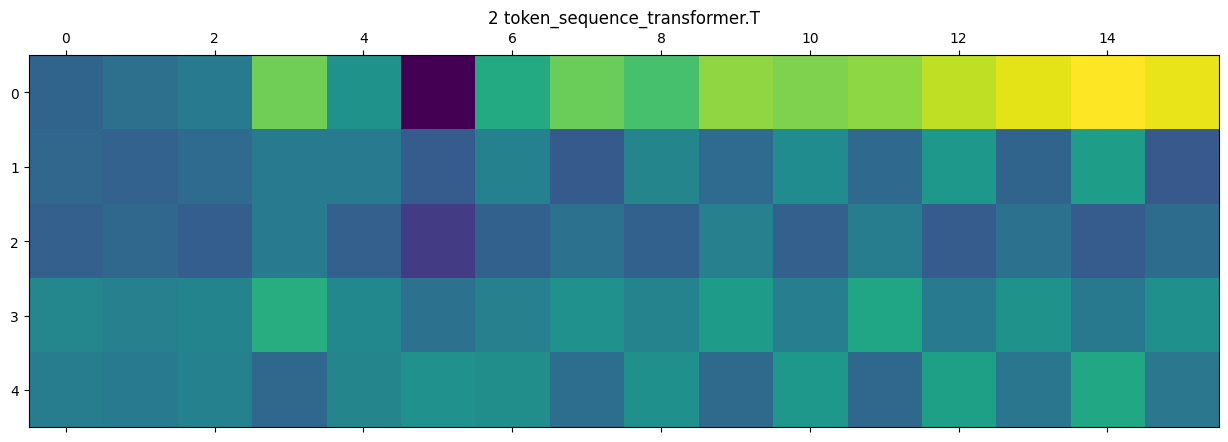

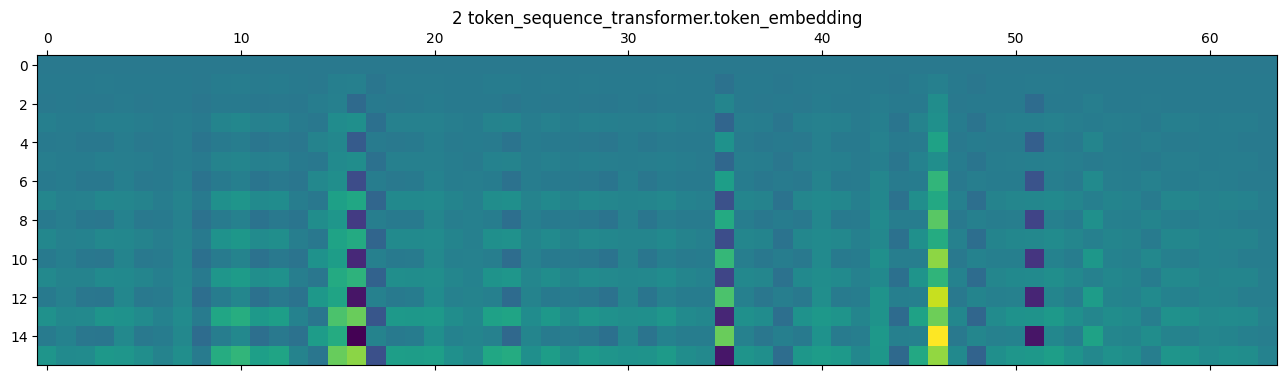

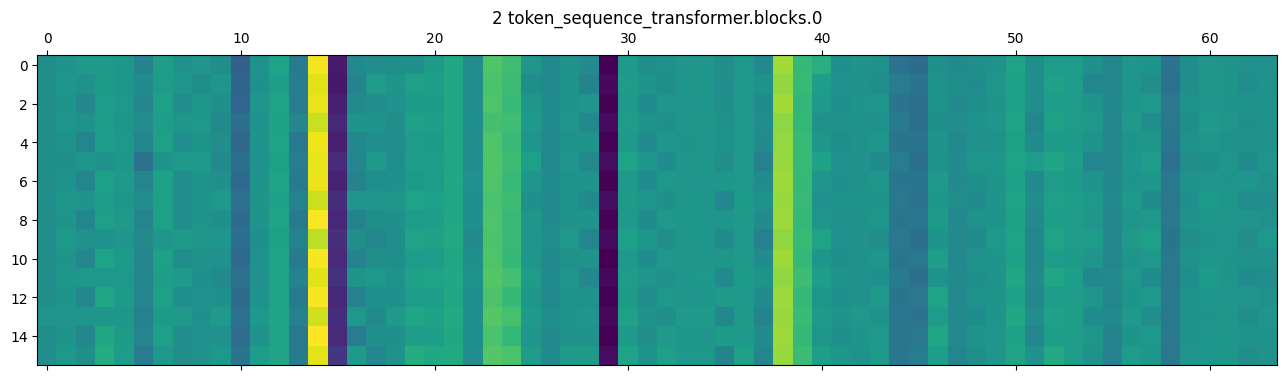

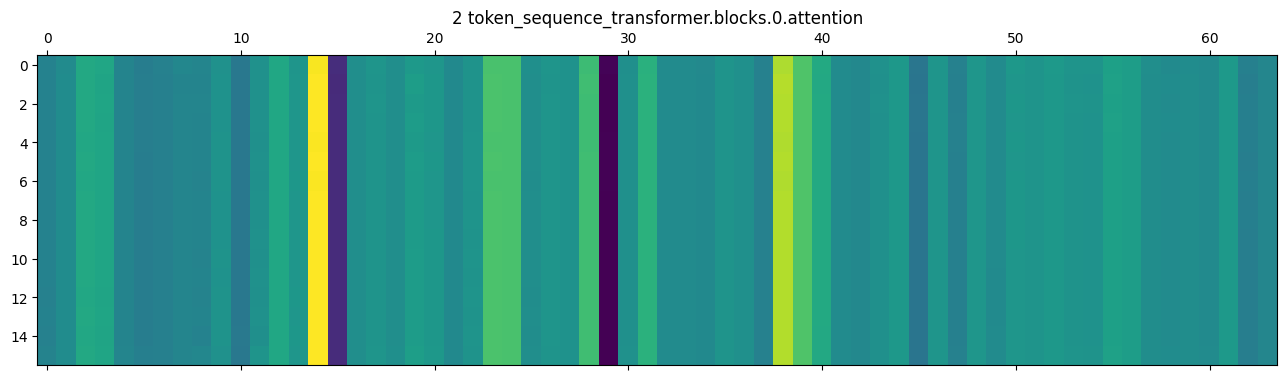

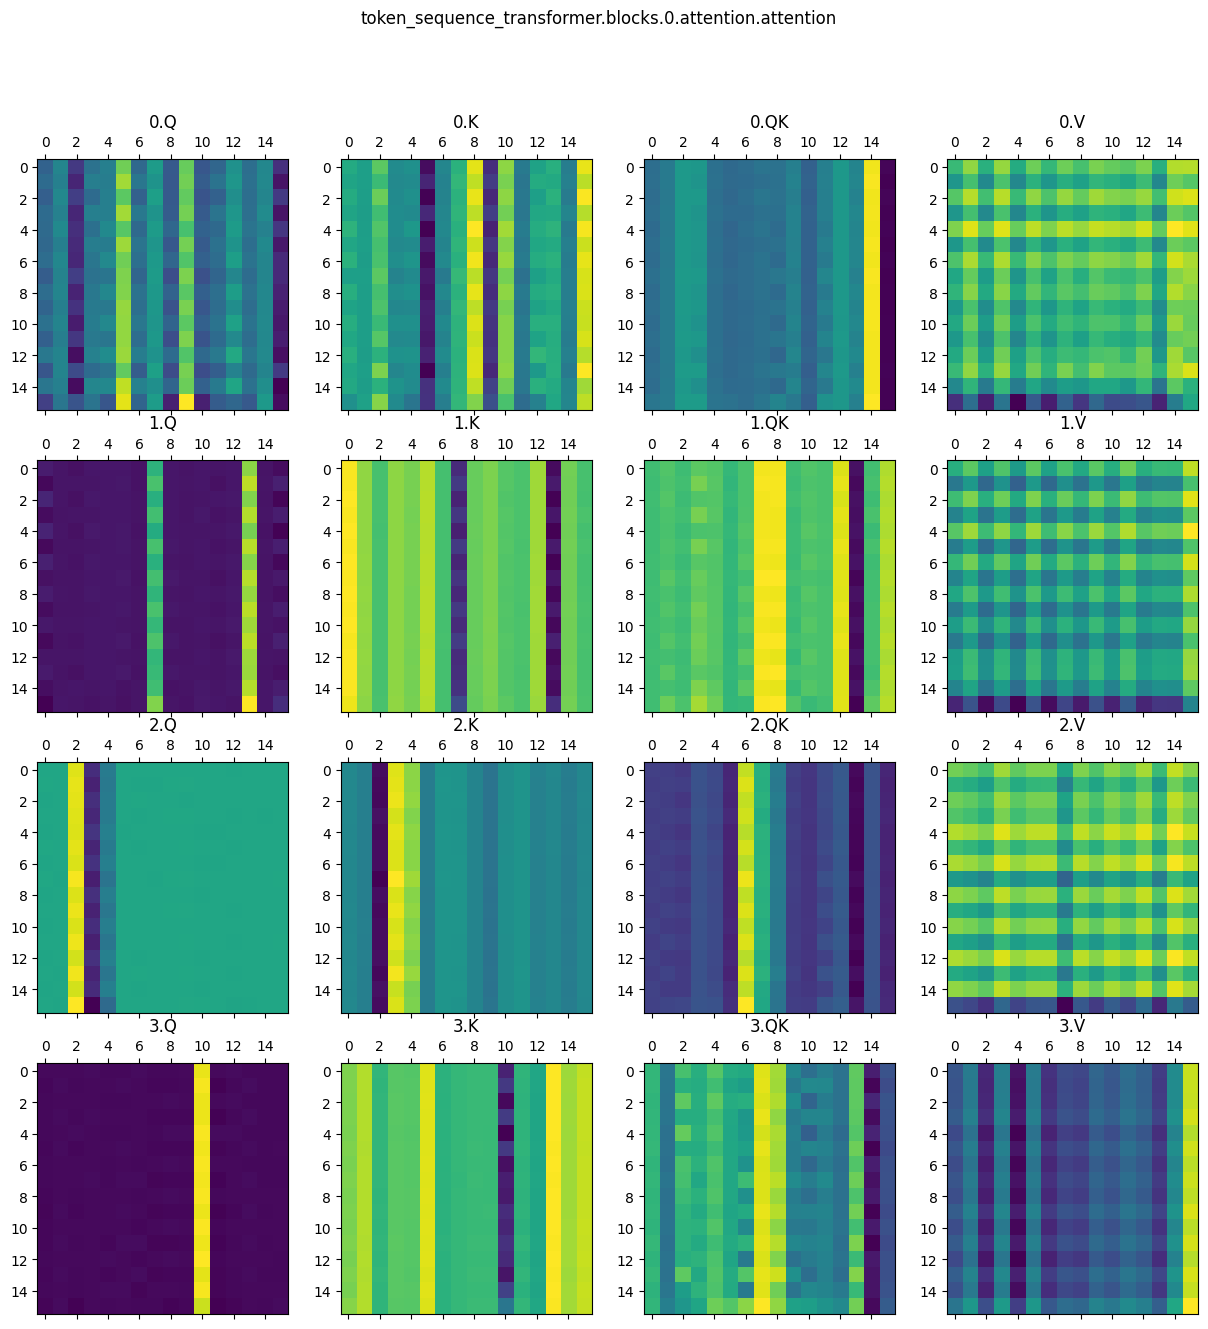

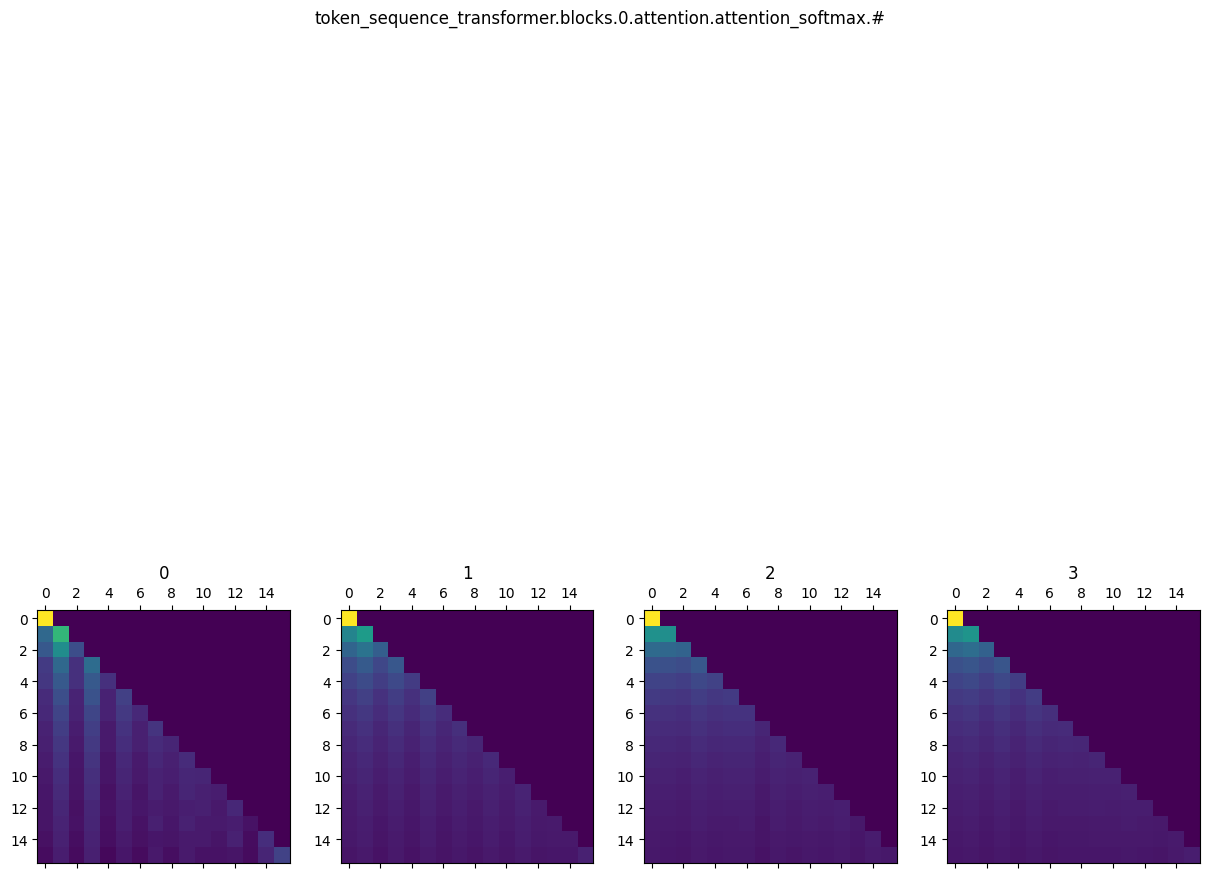

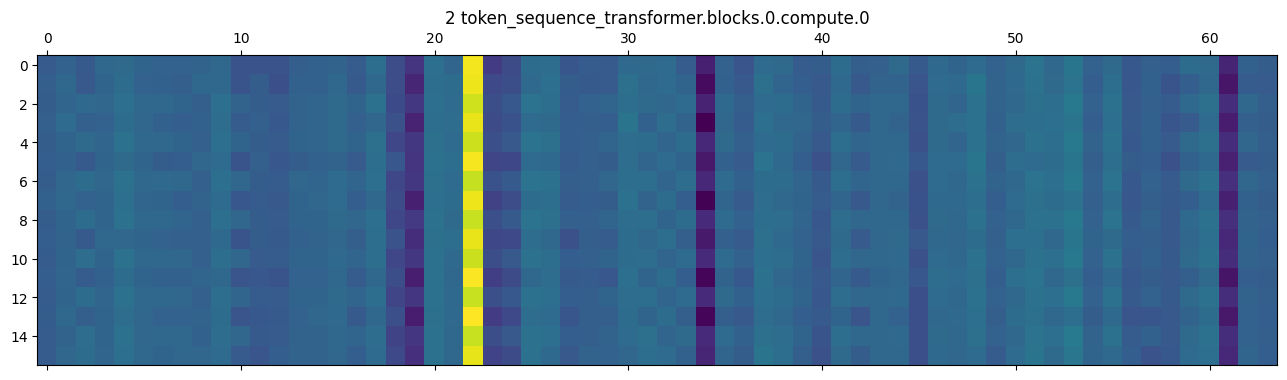

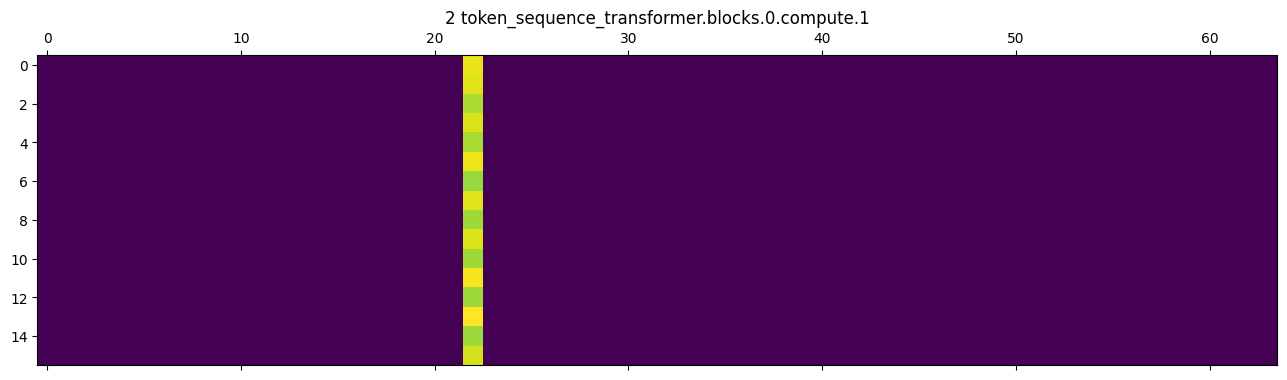

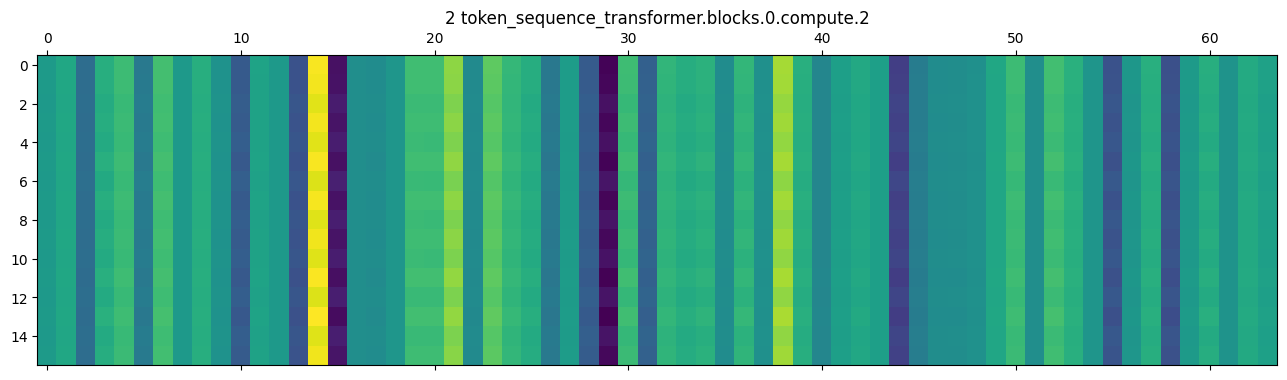

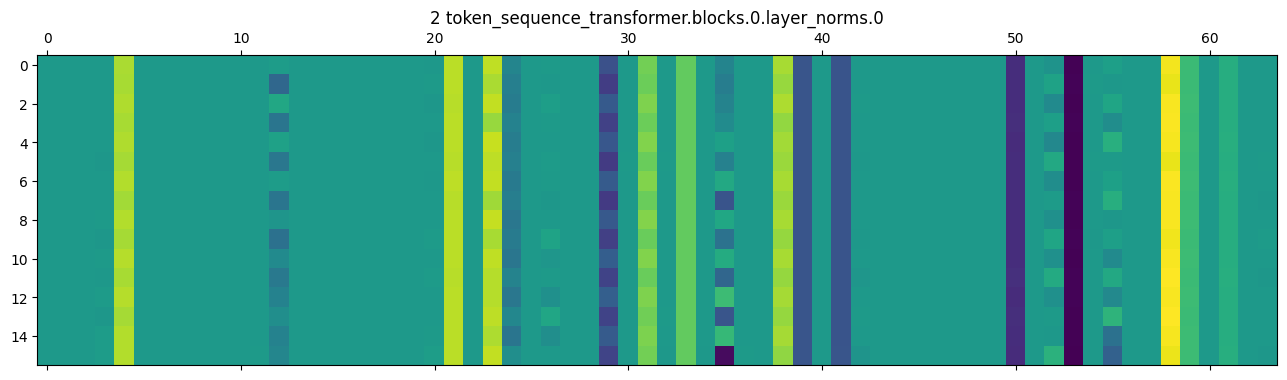

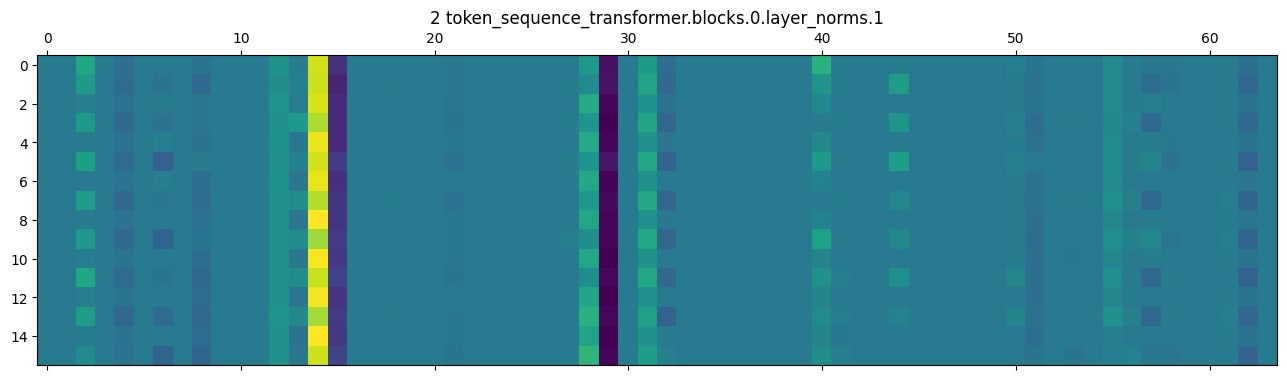

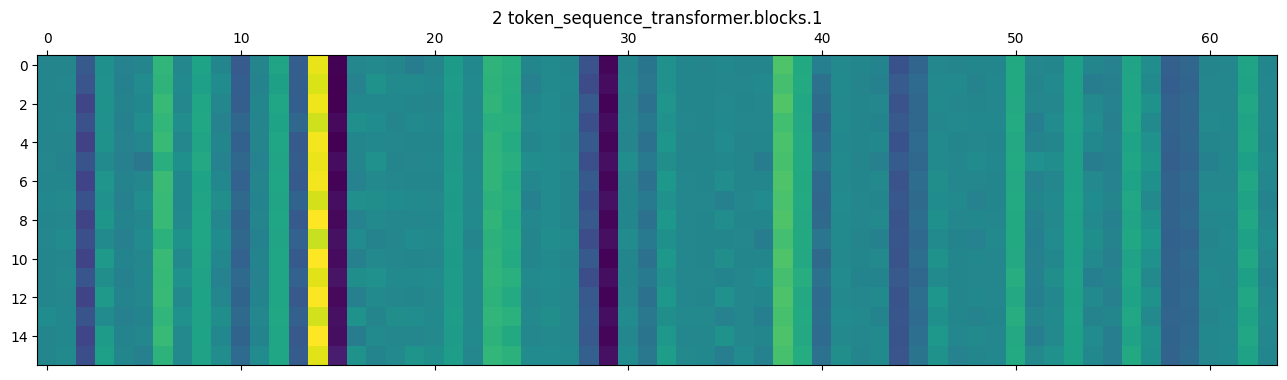

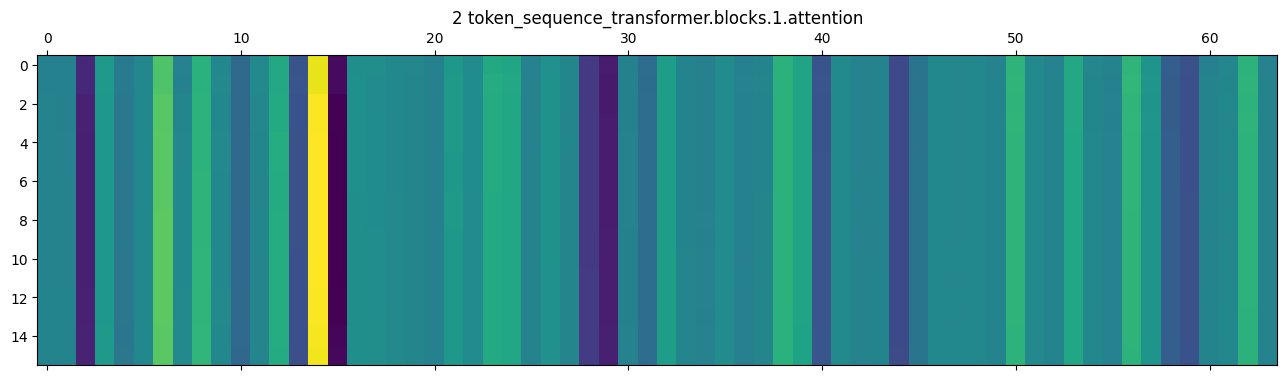

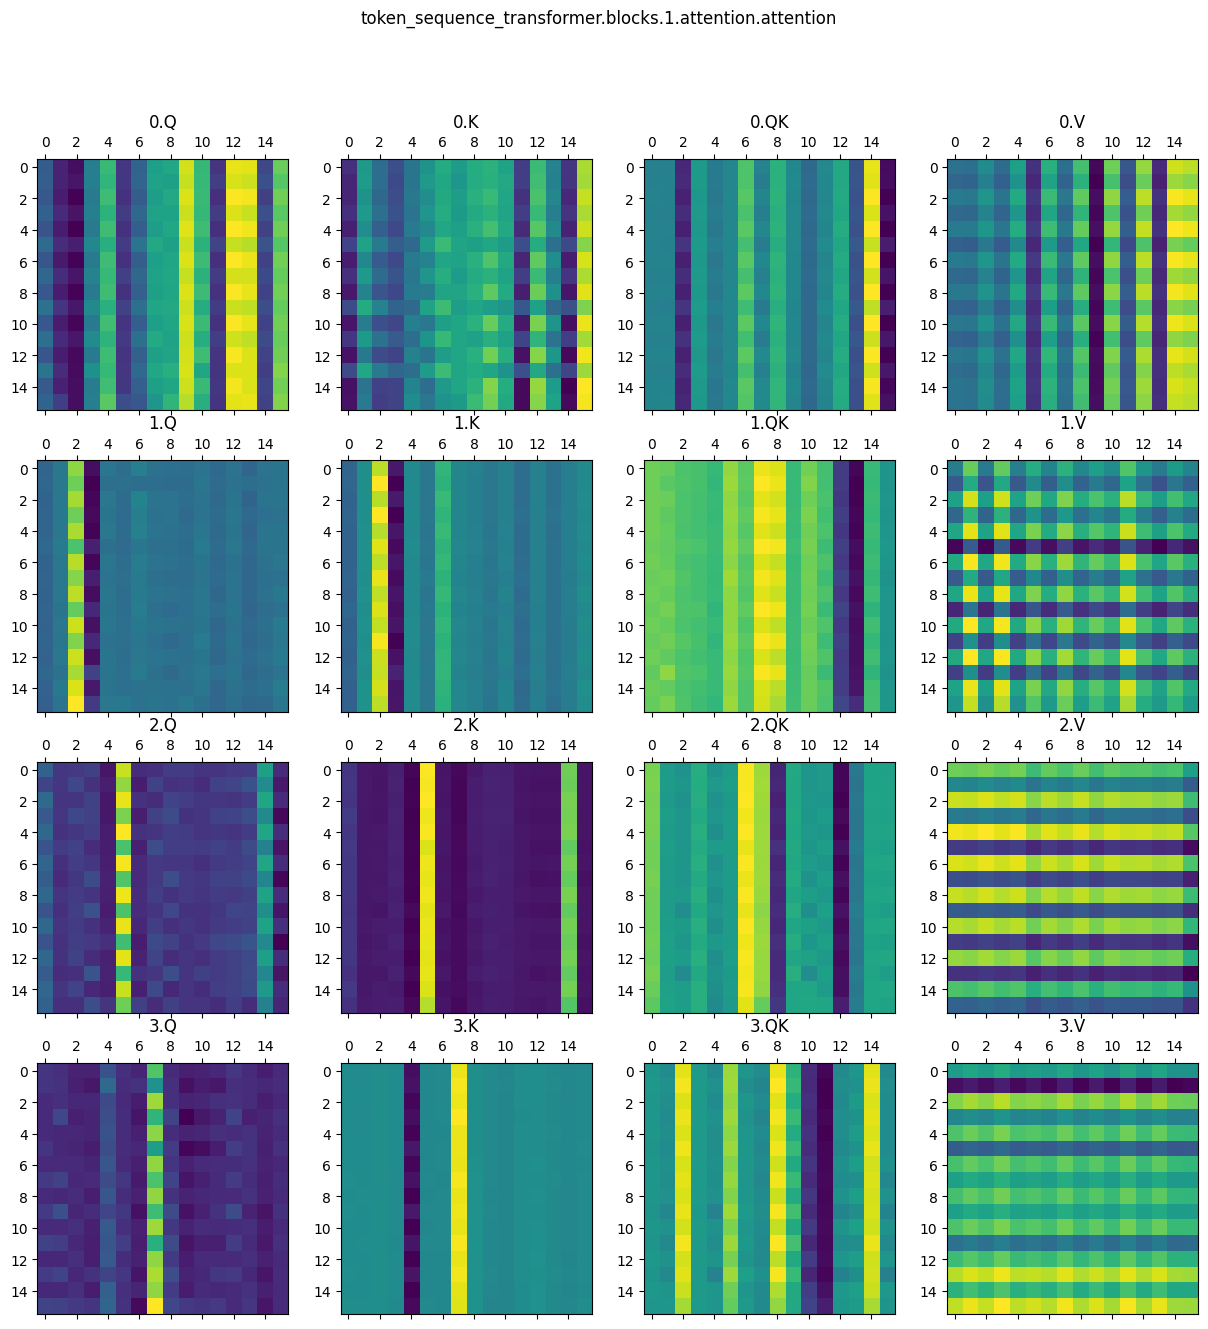

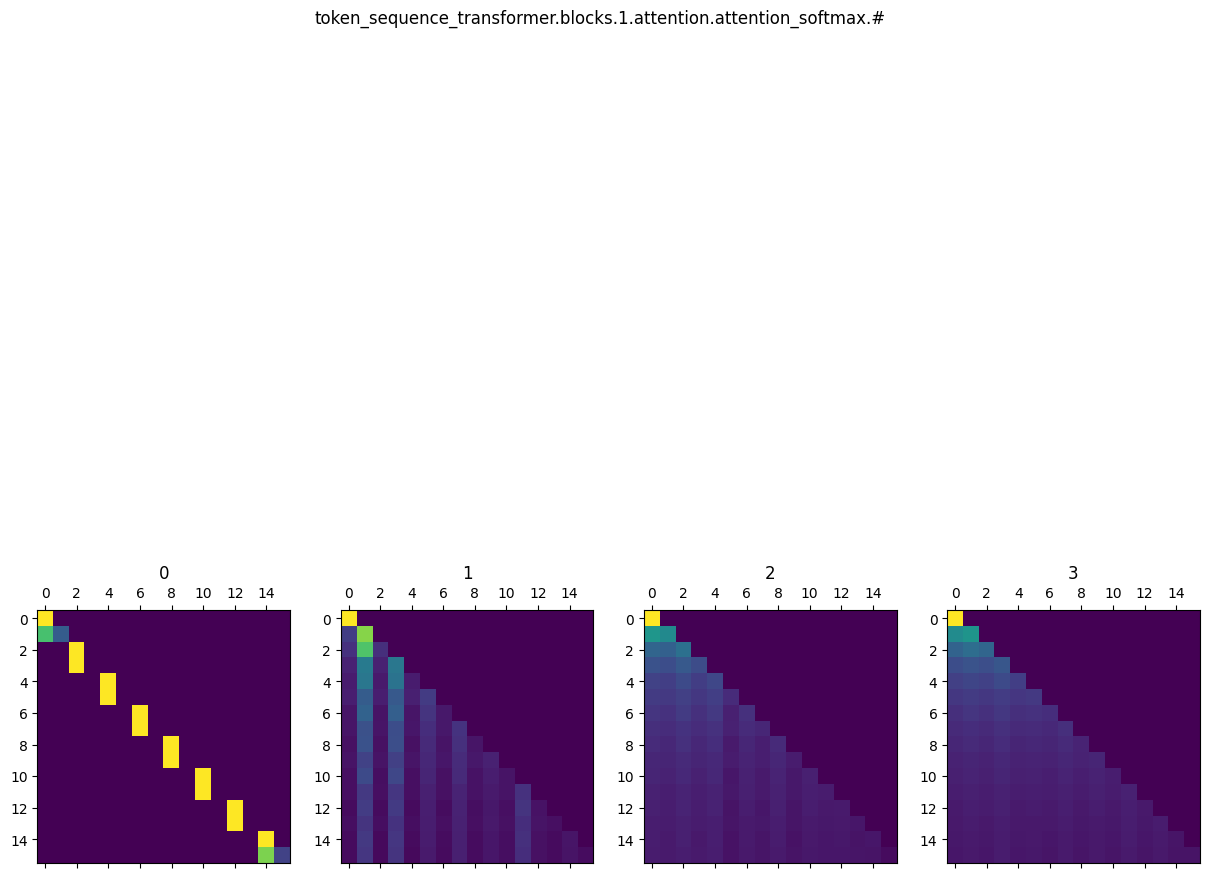

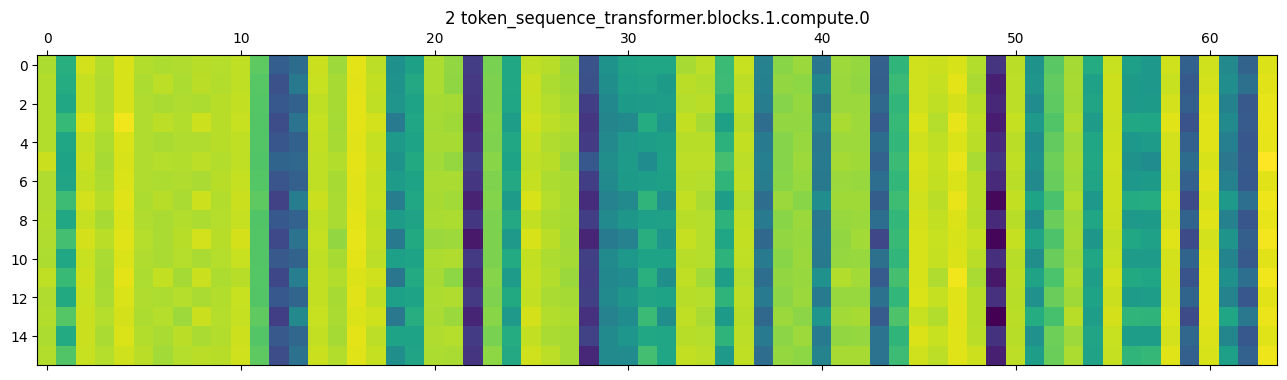

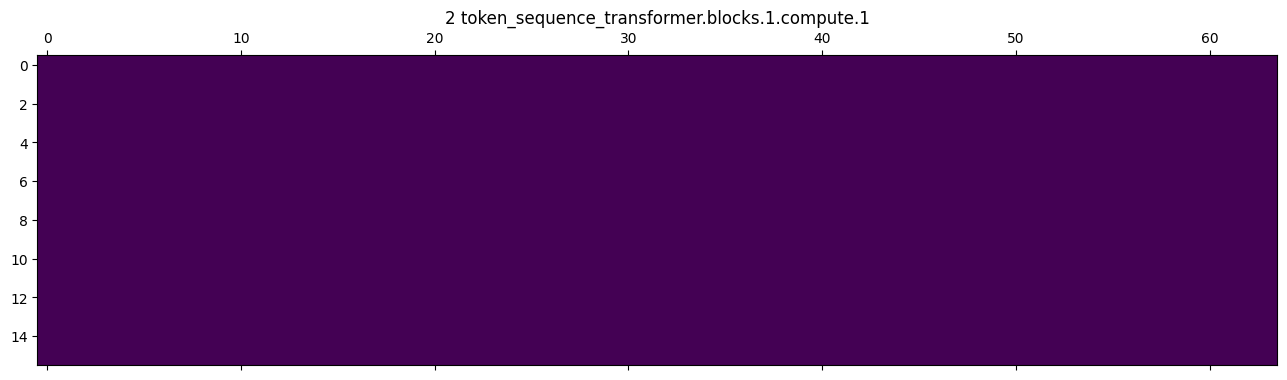

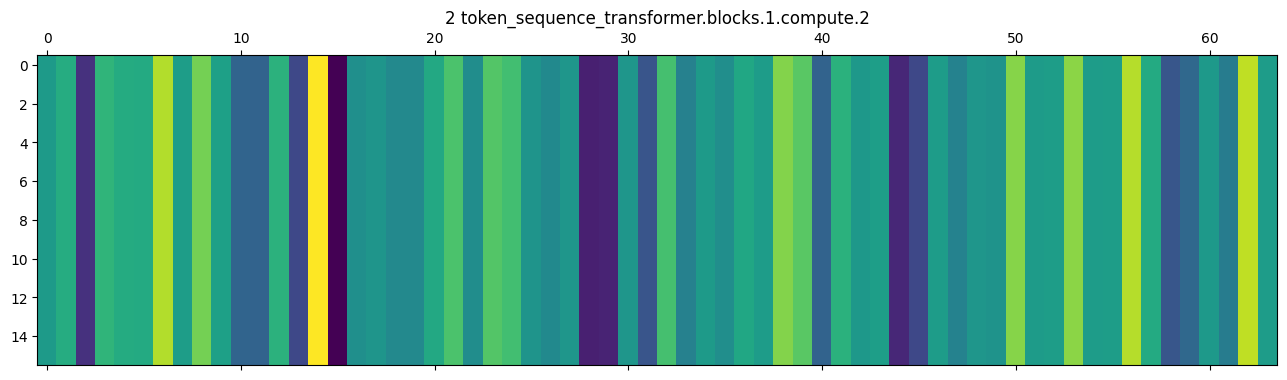

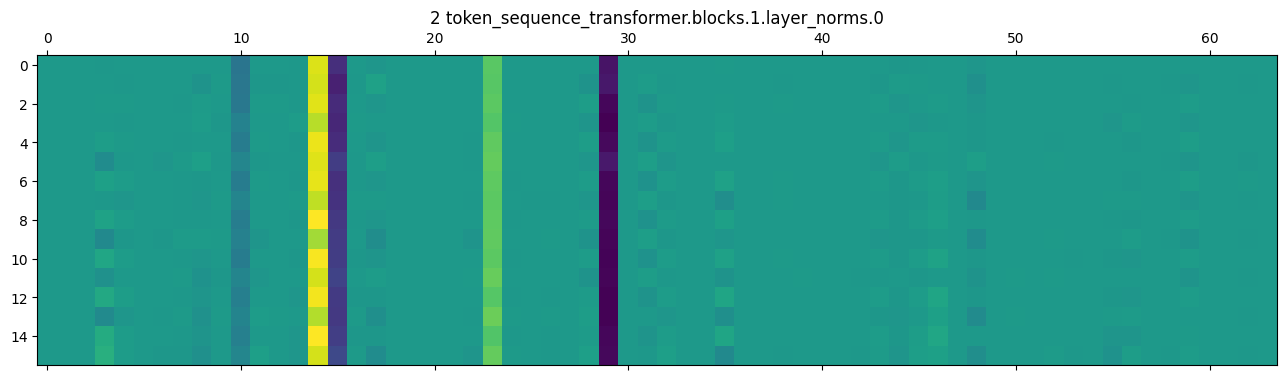

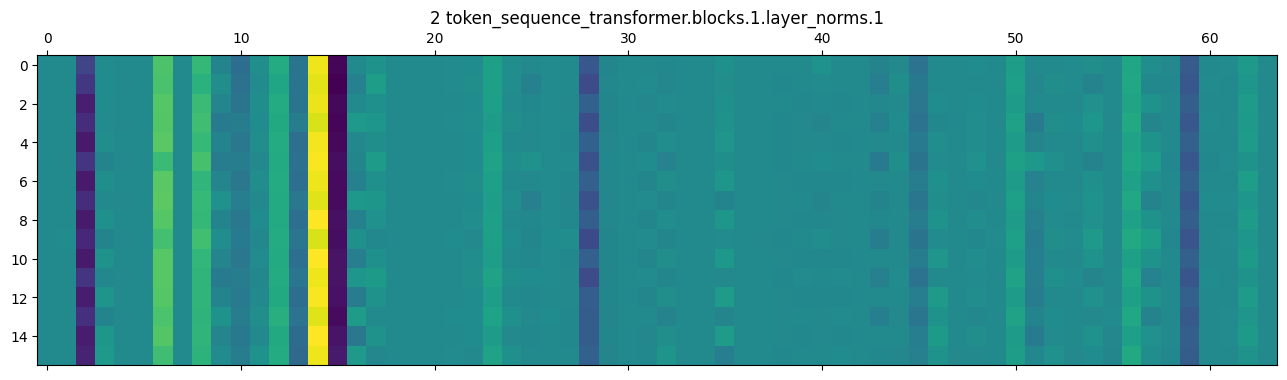

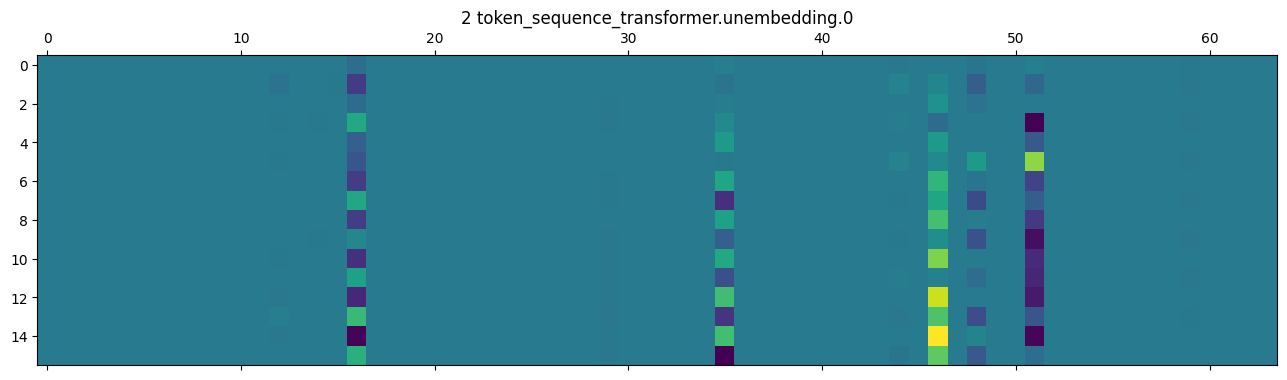

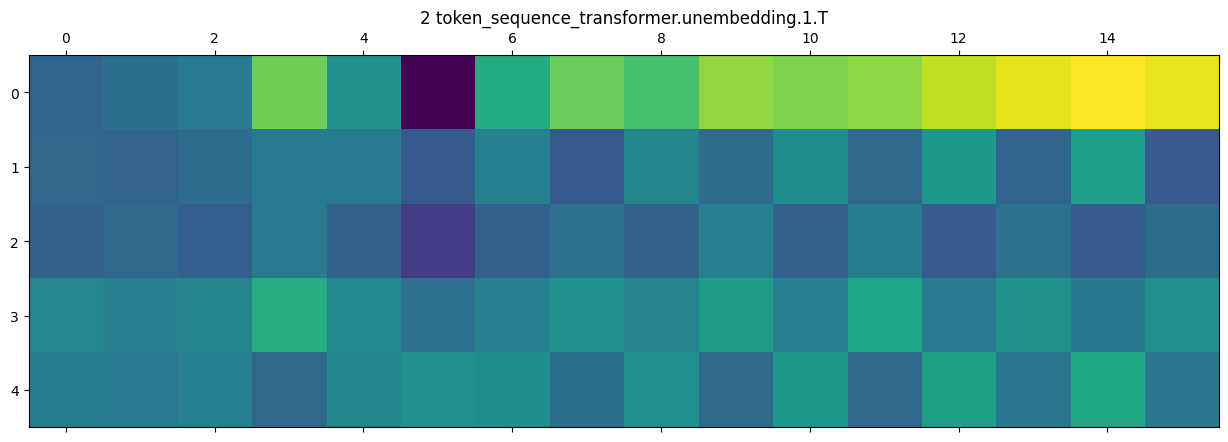

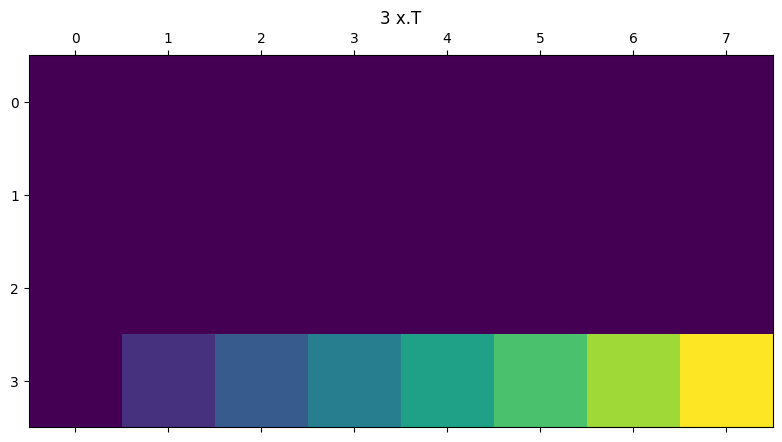

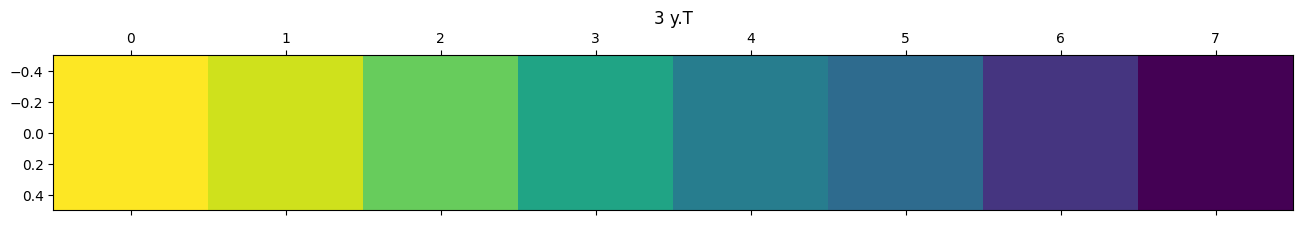

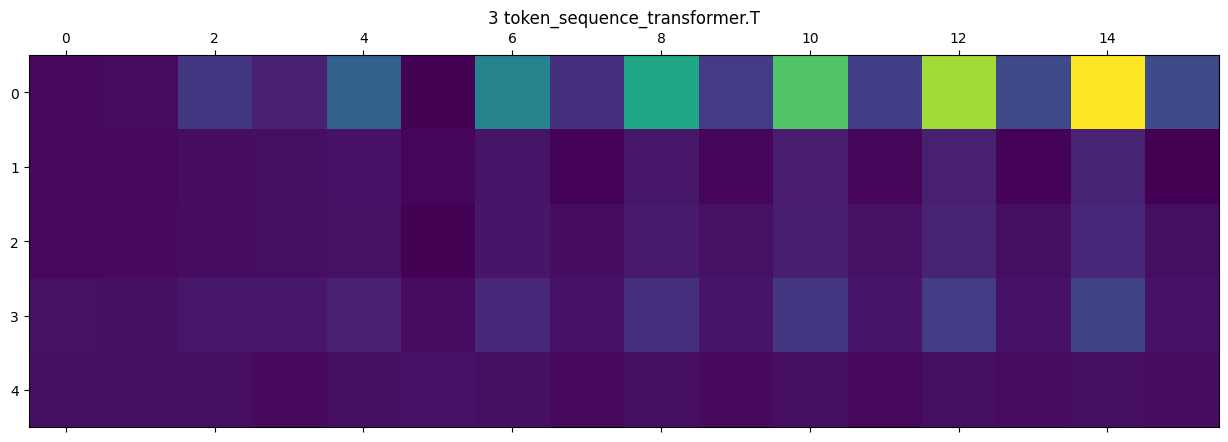

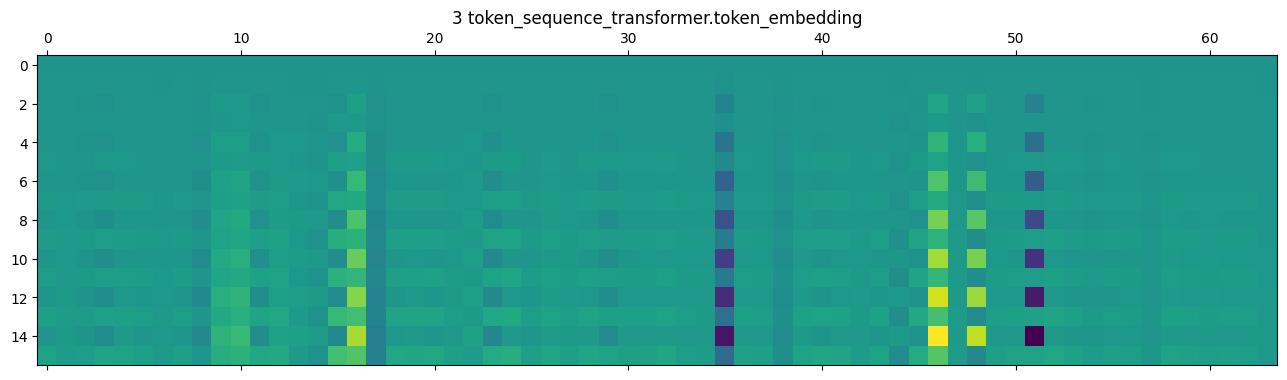

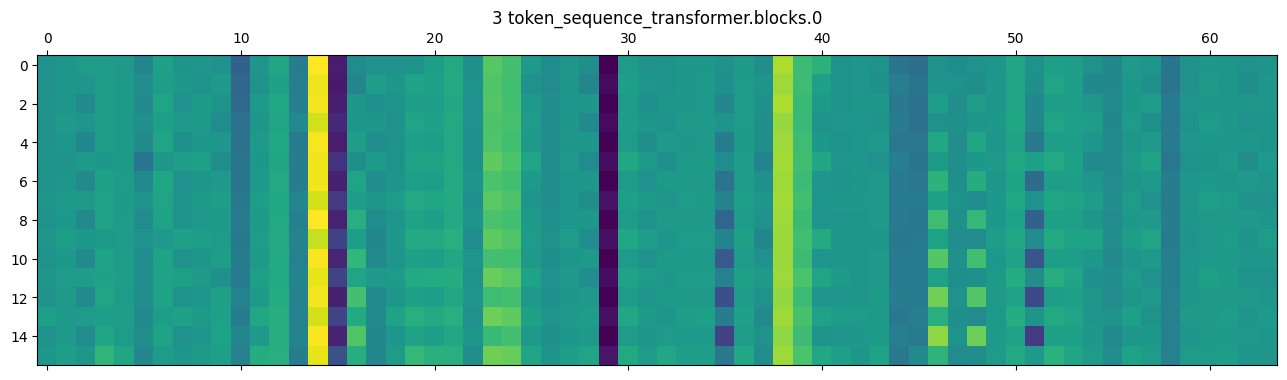

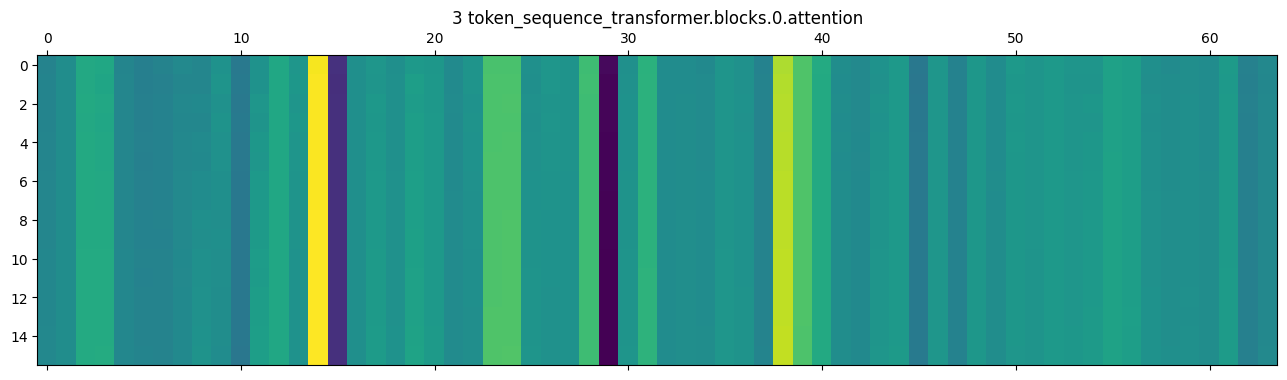

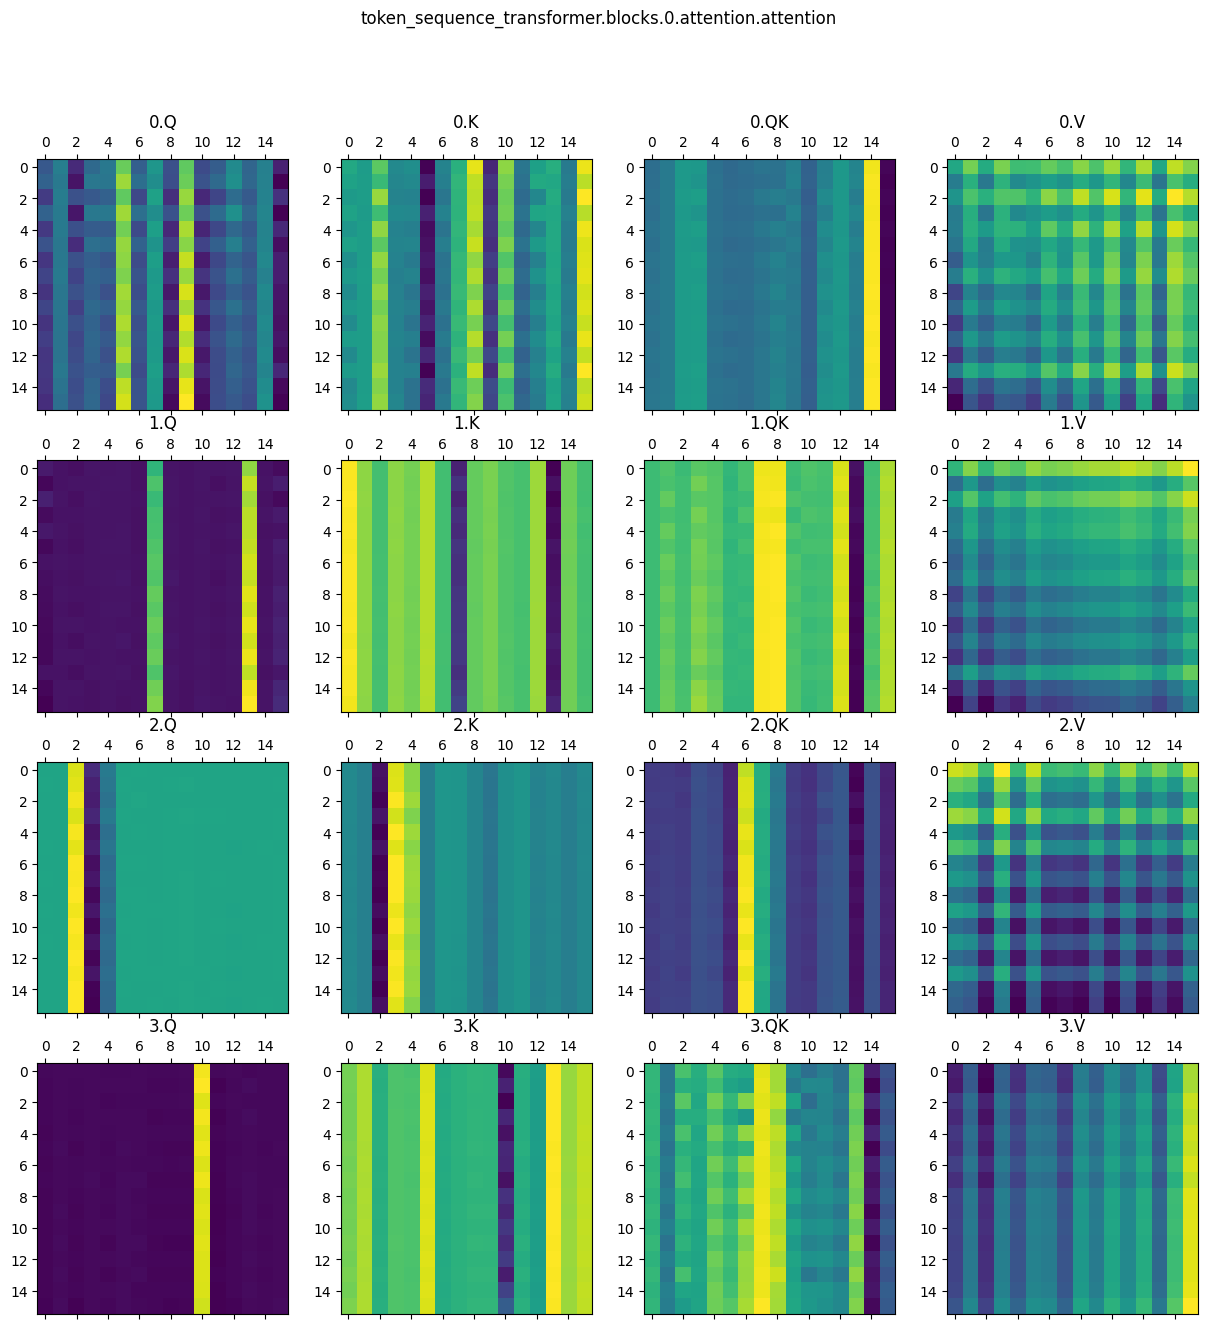

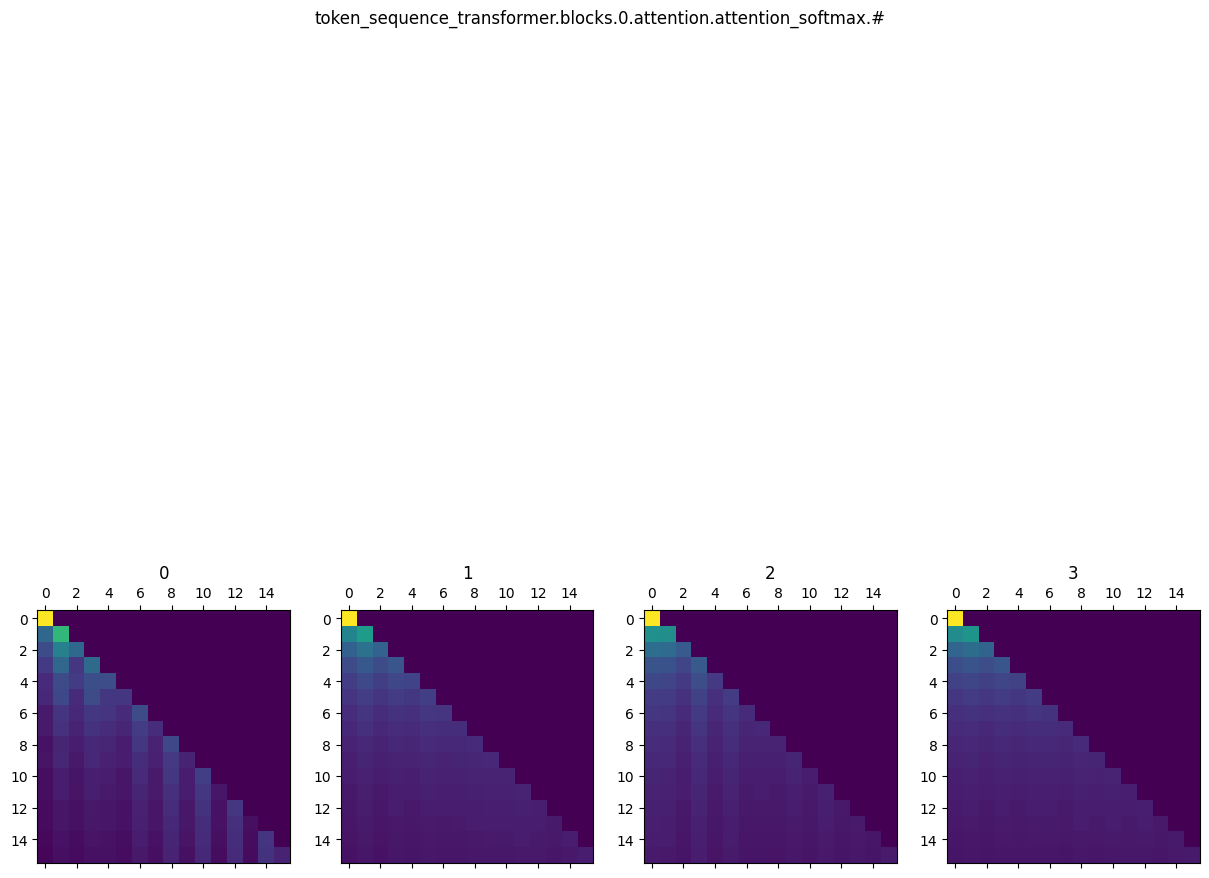

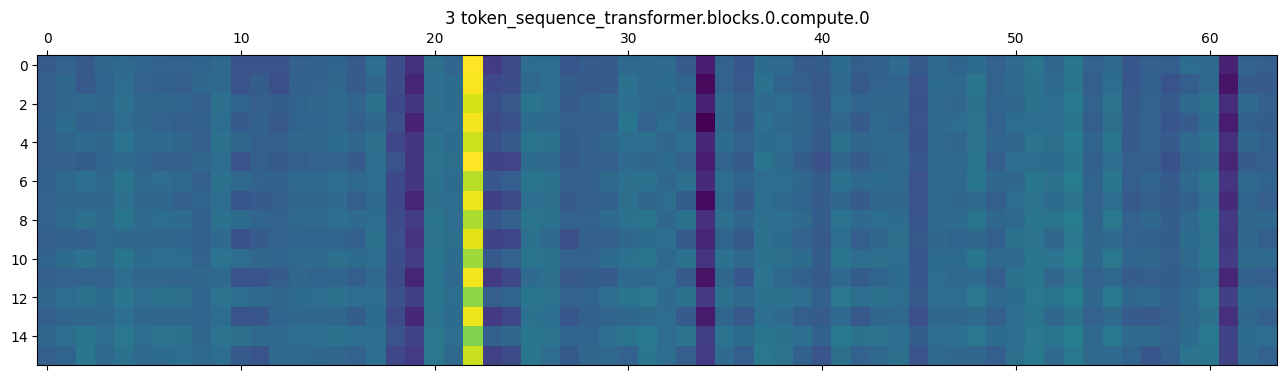

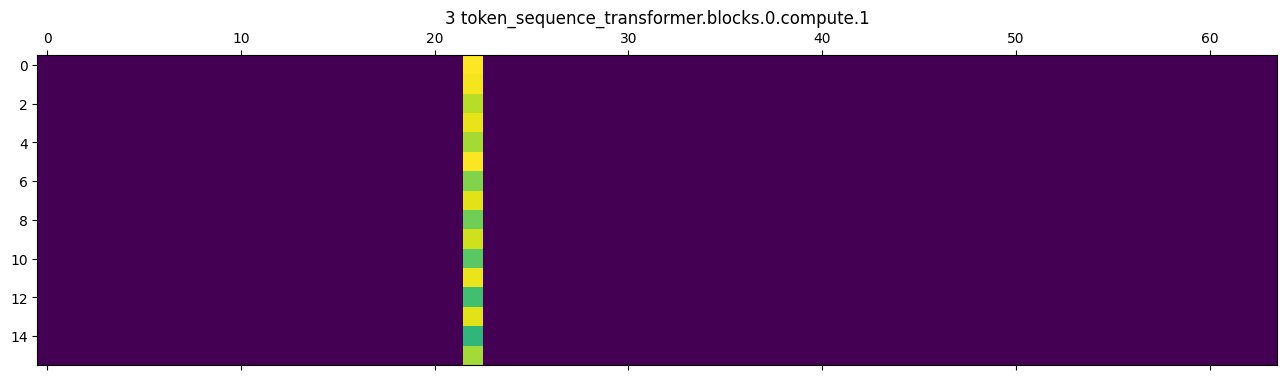

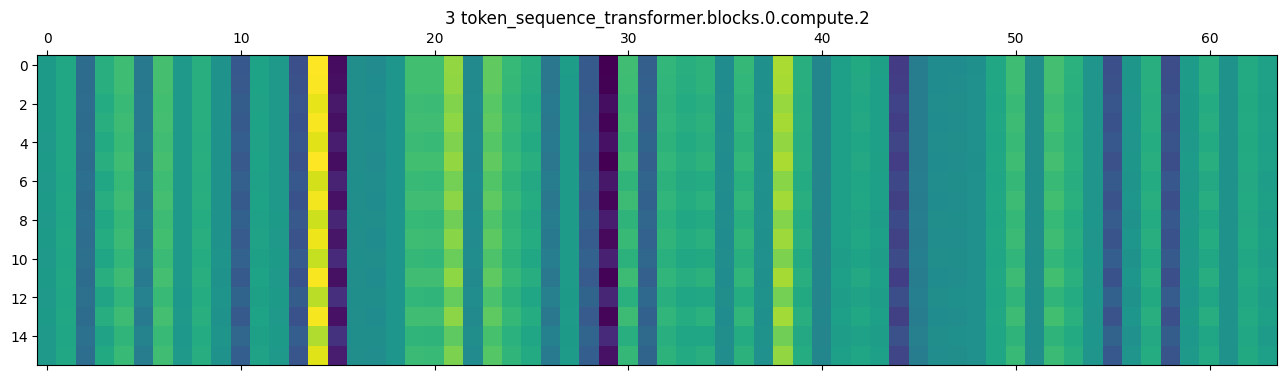

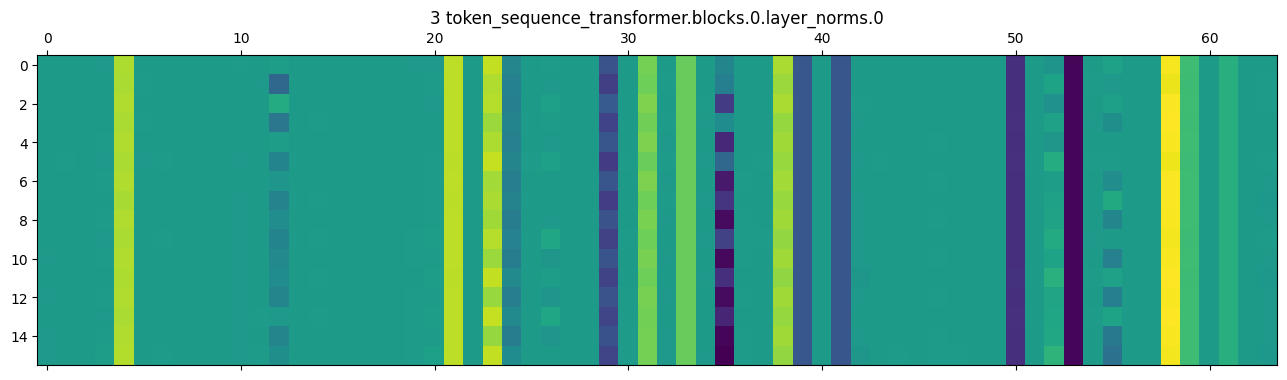

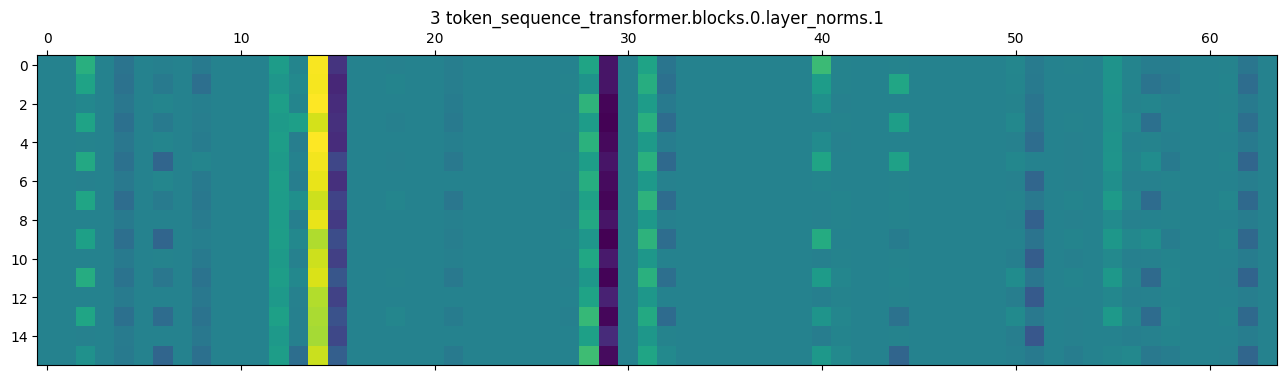

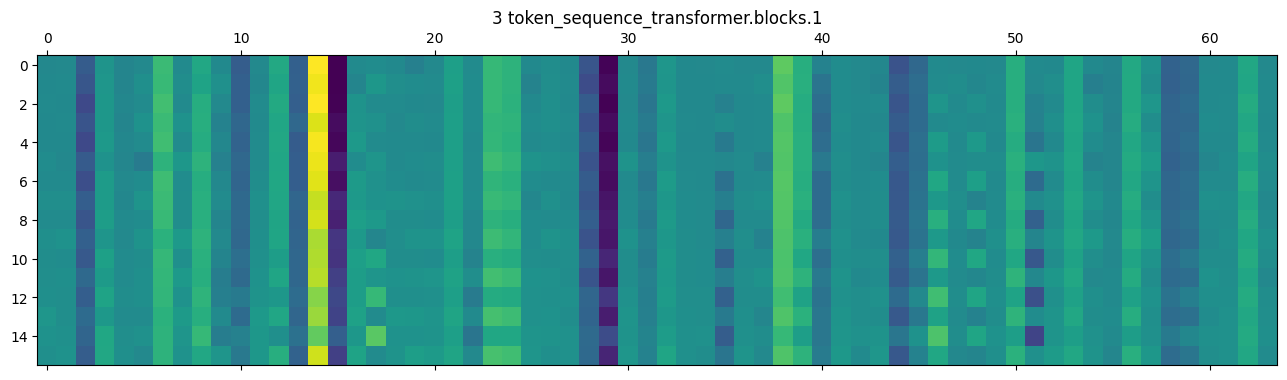

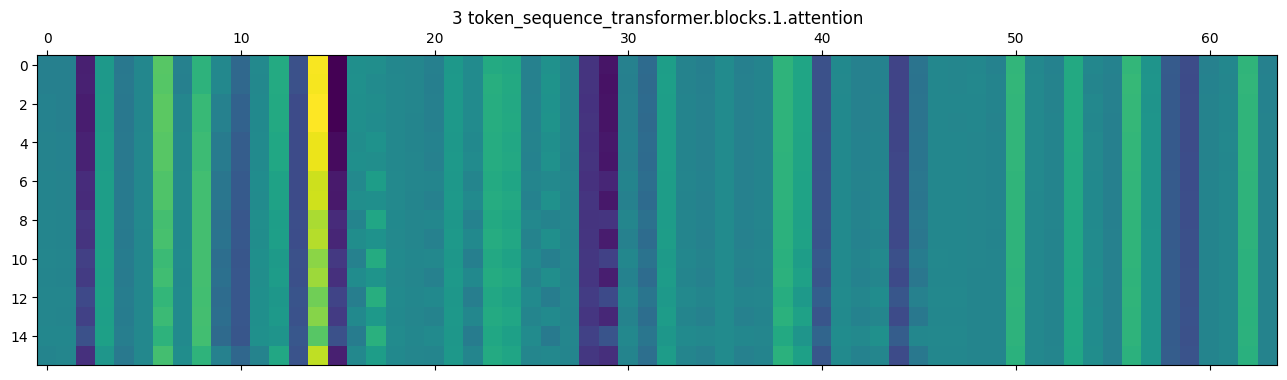

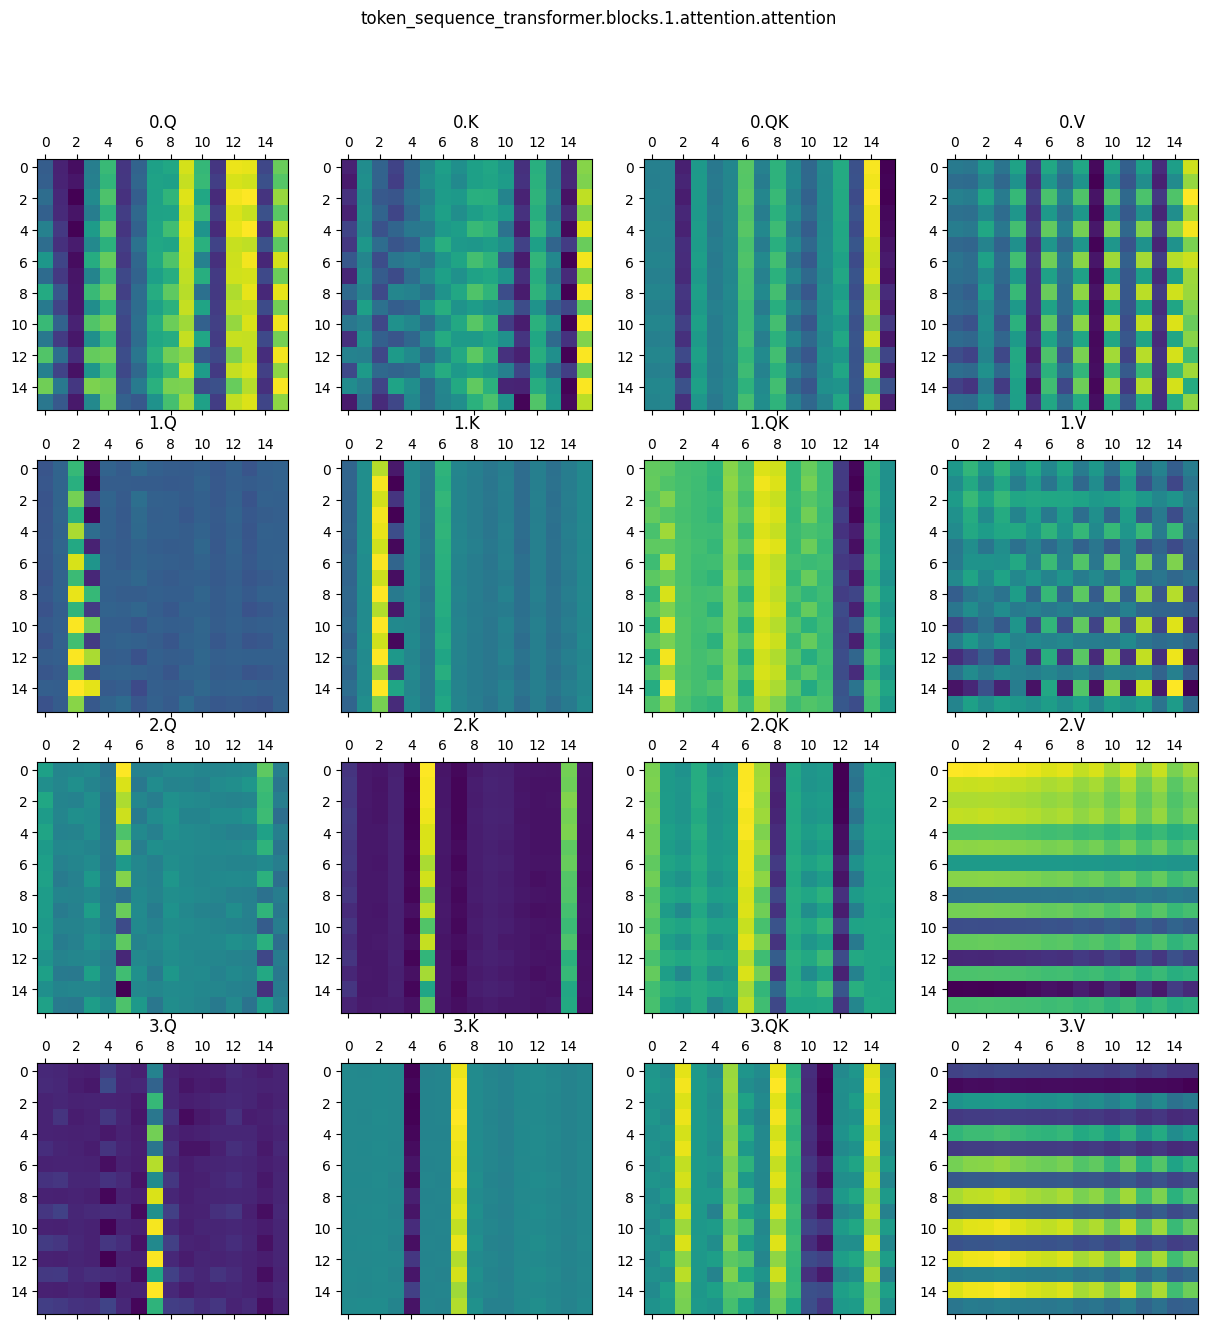

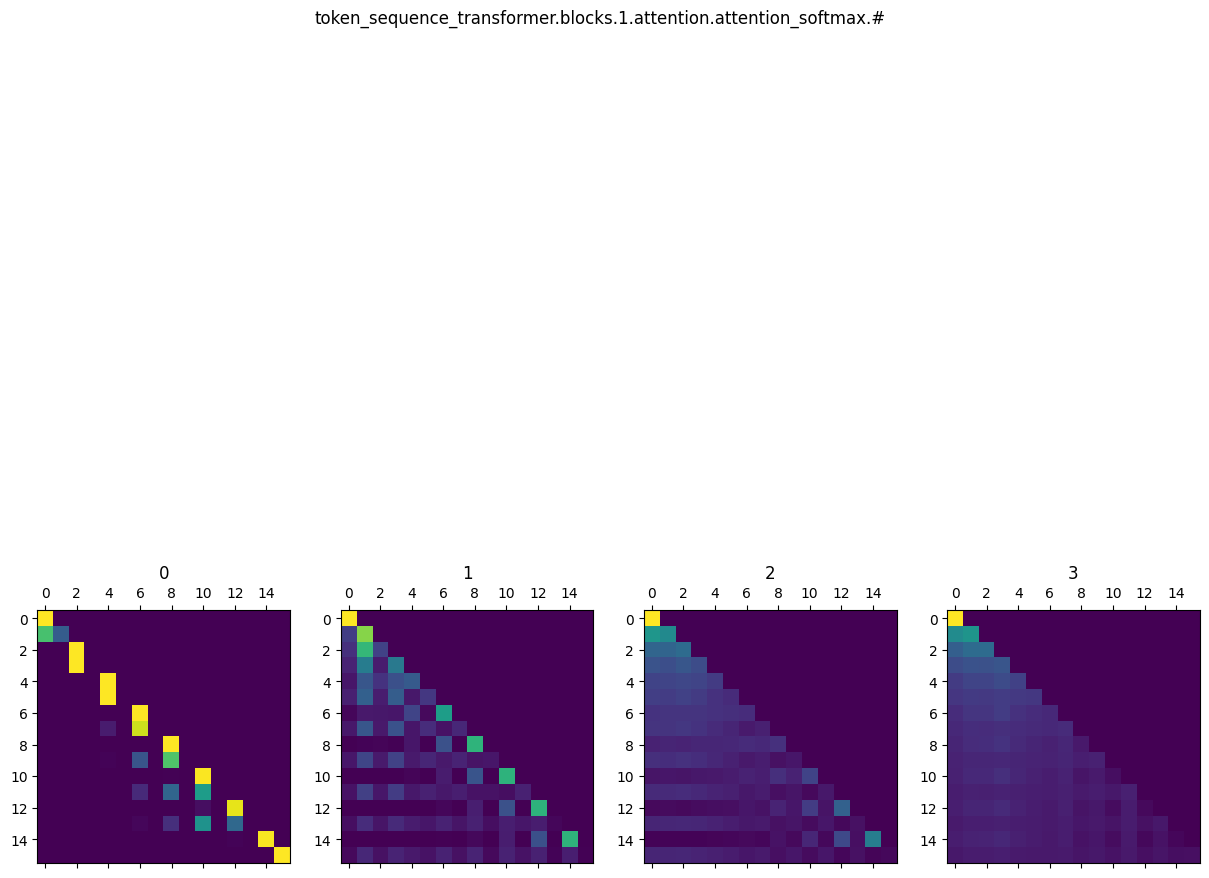

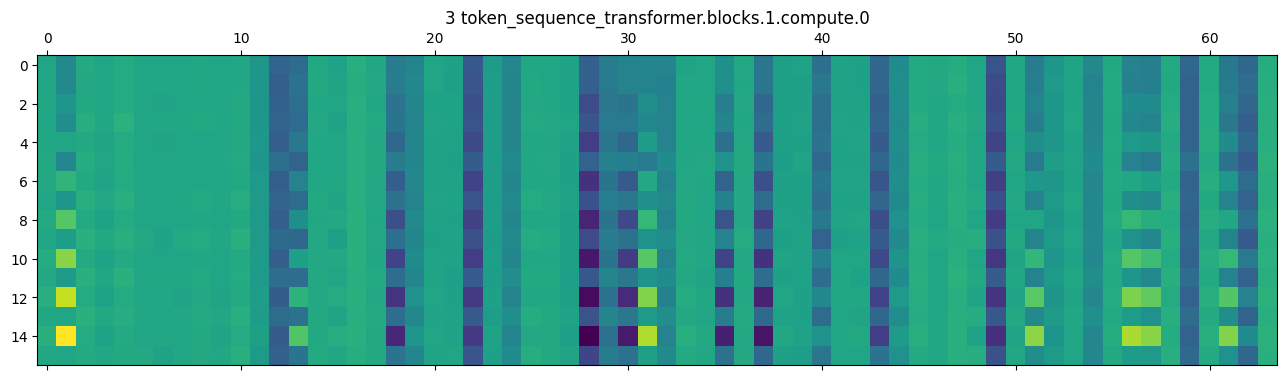

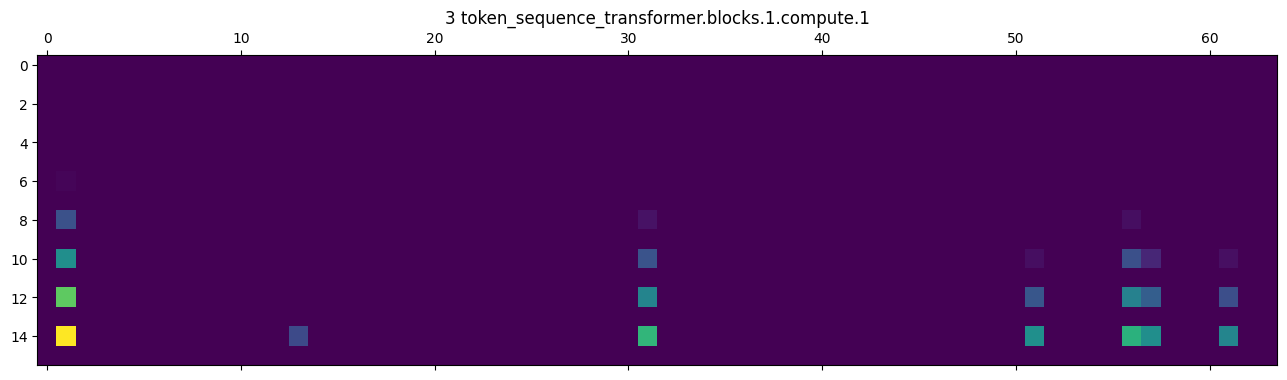

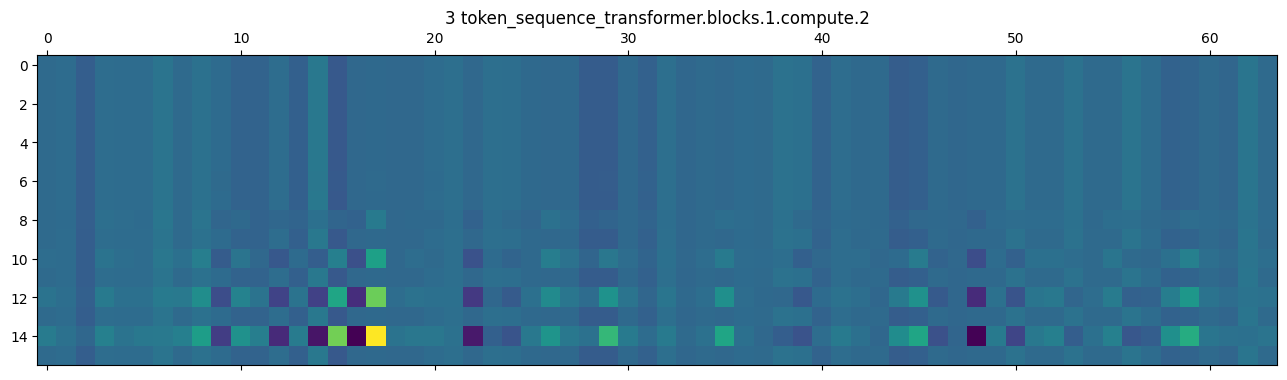

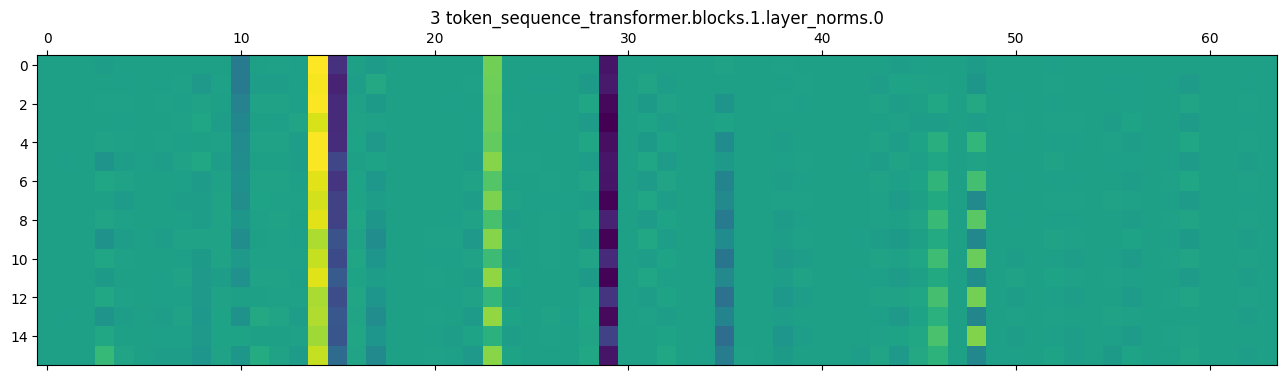

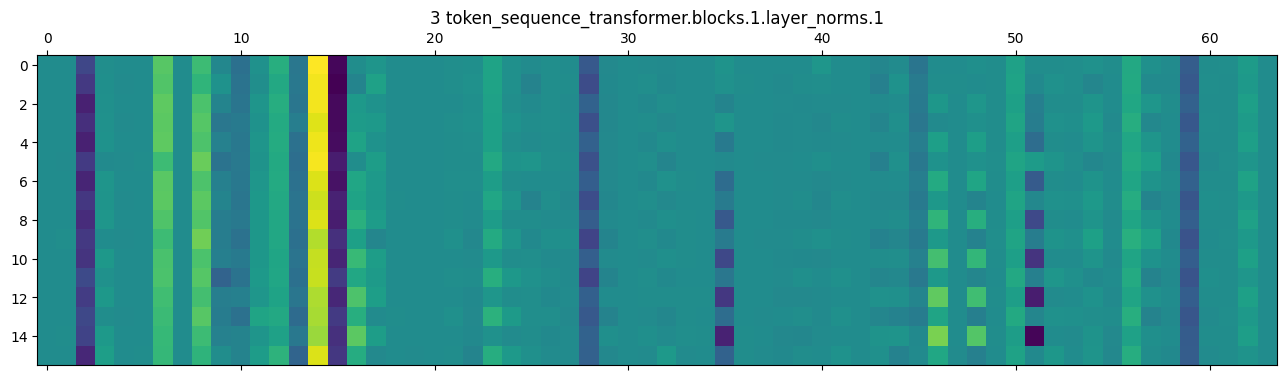

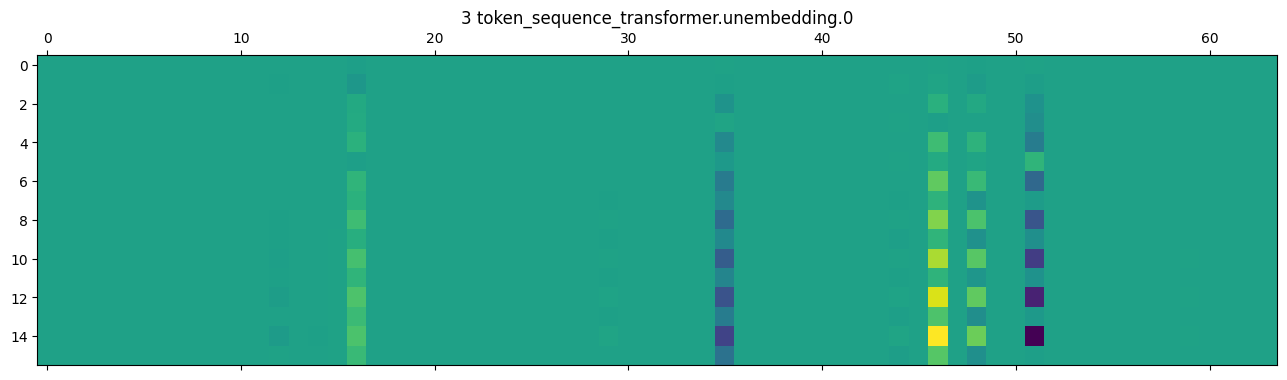

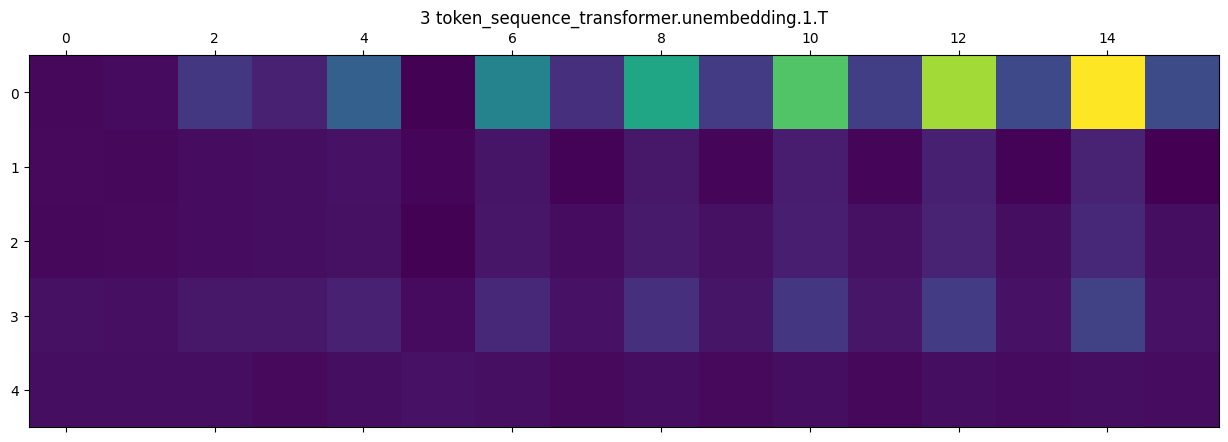

In [122]:
from pathlib import Path
figures = Path("../figures/M=1/across-x-basis-w=0")

output, activations_ = hooked_model.run_with_cache(x_trick, y_trick)

def separate_attention(qkv, num_heads: int, batch_size: int, head_size: int, num_tokens: int):
    return (qkv    # B T C @ C 3C  -> B T 3C
        .view(batch_size, num_tokens, num_heads, 3*head_size)     #               -> B T H 3c
        .transpose(-2, -3)      #               -> B H T 3c
        .split(head_size, dim=-1)       #               -> (B H T c) * 3
    )

E = 64
T = 16
H = 4
B = 4

# separate_attention(activations_, num_heads=4, batch_size=4, head_size=64//4, num_tokens=16)

def optionally_rotate(x, name,):
    if len(x.shape) != 2:
        raise ValueError("Tensor should have two dimensions.")

    if x.shape[0] > x.shape[1]:
        return x.T, f"{name}.T"
    
    return x, name

activations = {}
activations["x"] = x_trick
activations["y"] = y_trick
activations.update(activations_)

for i in range(4):
    if not os.path.exists(figures / f"{i}"):
        os.makedirs(figures / f"{i}")

    for location, v in activations.items():
        activation_slice = v[i] # Batch idx

        if location.endswith("attention.attention"):
            q, k, v = separate_attention(v, num_heads=H, batch_size=B, head_size=E//H, num_tokens=T)
            qk = q @ k.transpose(-2, -1)
            q, k, qk, v = q[i], k[i], v[i], qk[i]
            
            fig, axs = plt.subplots(H, 4, figsize=(15, 15))

            for j, (name, x) in enumerate(zip(["Q", "K", "QK", "V"], [q, k, qk, v])):
                for h in range(H):
                    ax = axs[h, j]
                    ax.matshow(x[h].detach().to("cpu").numpy())
                    ax.set_title(f"{h}.{name}")

            plt.suptitle(f"{location}")
            plt.savefig(figures / f"{i}/{location}.png")
            plt.show()
        elif len(activation_slice.shape) == 2:
            x, name = optionally_rotate(activation_slice, location)
            plt.matshow(x.detach().to("cpu").numpy())
            plt.title(f"{i} {name}")
            plt.savefig(figures / f"{i}/{name}.png")
            plt.show()
        elif len(activation_slice.shape) == 3:  # [heads, xs, ys]
            heads, xs, ys = activation_slice.shape
            fig, axs = plt.subplots(1, heads, figsize=(15, 15))
            for j in range(heads):
                ax = axs[j]
                x, name = optionally_rotate(activation_slice[j], str(j))
                ax.matshow(x.detach().to("cpu").numpy())
                ax.set_title(name)
            plt.suptitle(f"{location}.#")
            plt.savefig(figures / f"{i}/{location}.png")
            plt.show()
        else:
            raise ValueError("Unsupported number of dimensions.")


In [24]:
import os
from PIL import Image

# List of folder paths containing images
folder_paths = [figures / f"{i}" for i in range(4)]  # Add more folders as needed

if not os.path.exists(figures / "overview"):
    os.makedirs(figures/"overview")

# Create a dictionary to store images by filename
images_by_filename = {}

# Load images from each folder and organize them by filename
for folder_path in folder_paths:
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.png')]  # Change the extension as needed
    for filename in filenames:
        img = Image.open(os.path.join(folder_path, filename))
        if filename in images_by_filename:
            images_by_filename[filename].append(img)
        else:
            images_by_filename[filename] = [img]

print(images_by_filename)

# Create comparison images for each unique filename
for filename, image_list in images_by_filename.items():
    # Calculate the width and height of the result image
    width = sum(img.width for img in image_list)
    height = max(img.height for img in image_list)

    # Create a new image for the comparison
    result_image = Image.new('RGB', (width, height))

    # Paste images side by side
    x_offset = 0
    for img in image_list:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    # Display or save the result image
    result_image.save(figures / f"overview/{filename}")  # You can replace this with result_image.save() to save the comparison images

{'token_sequence_transformer.blocks.1.layer_norms.1.png': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F8738718EB0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F87895B5400>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F877955E880>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F87795732B0>], 'token_sequence_transformer.blocks.1.layer_norms.0.png': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F87387181C0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F87895B5460>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F871C860F70>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400 at 0x7F8779573190>], 'token_sequence_transformer.blocks.0.attention.attention_softmax.png': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x1500 at 0x7F8738718D00>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x15

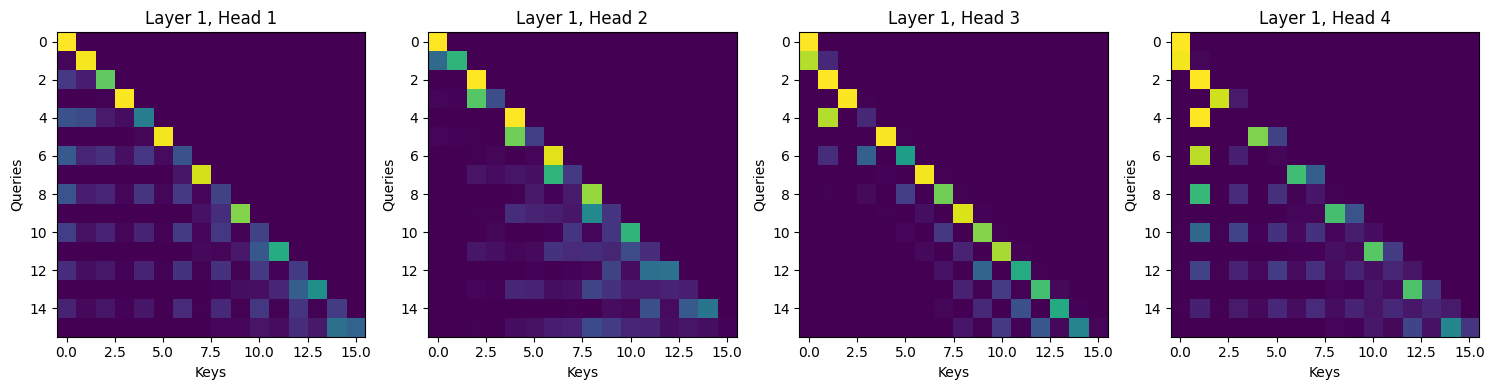

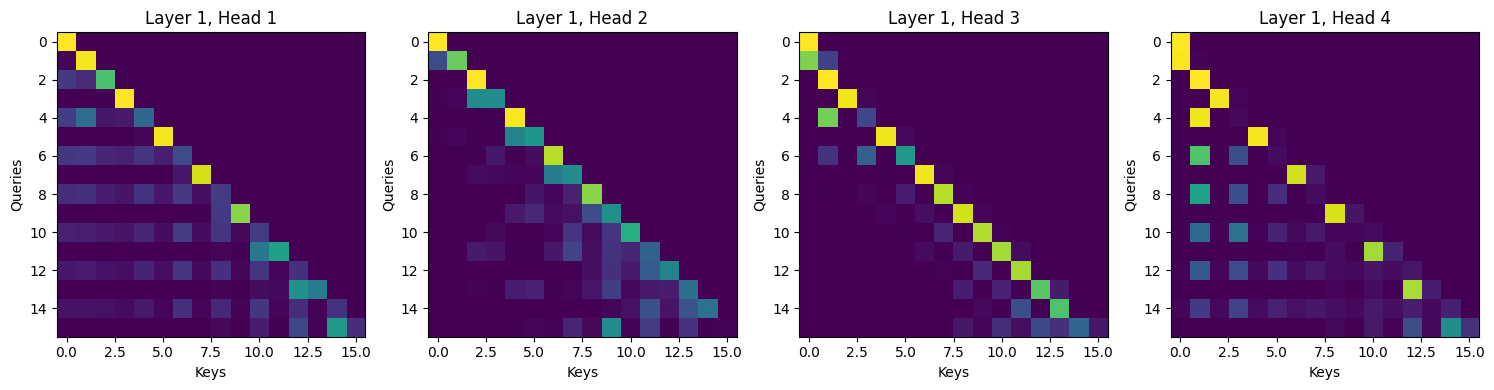

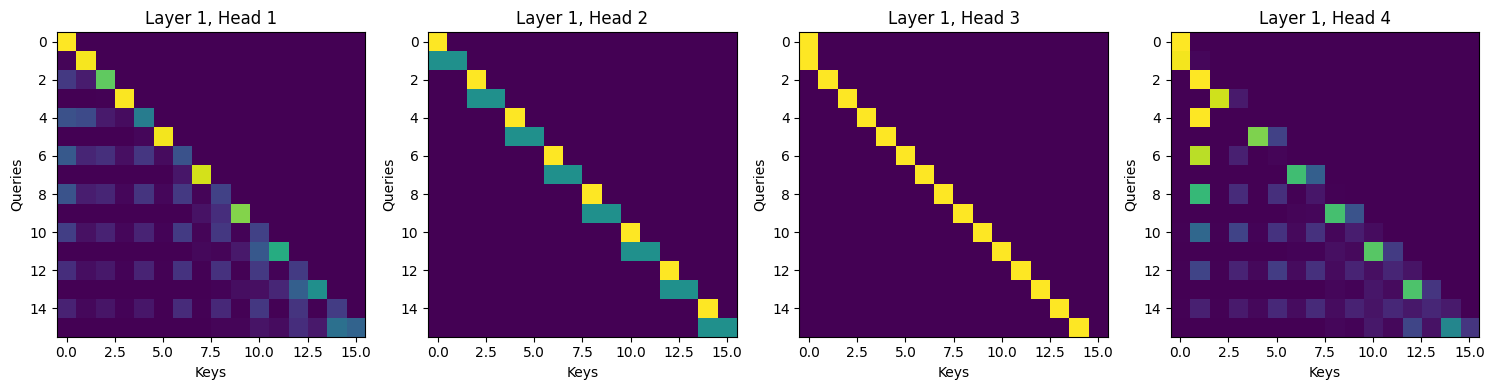

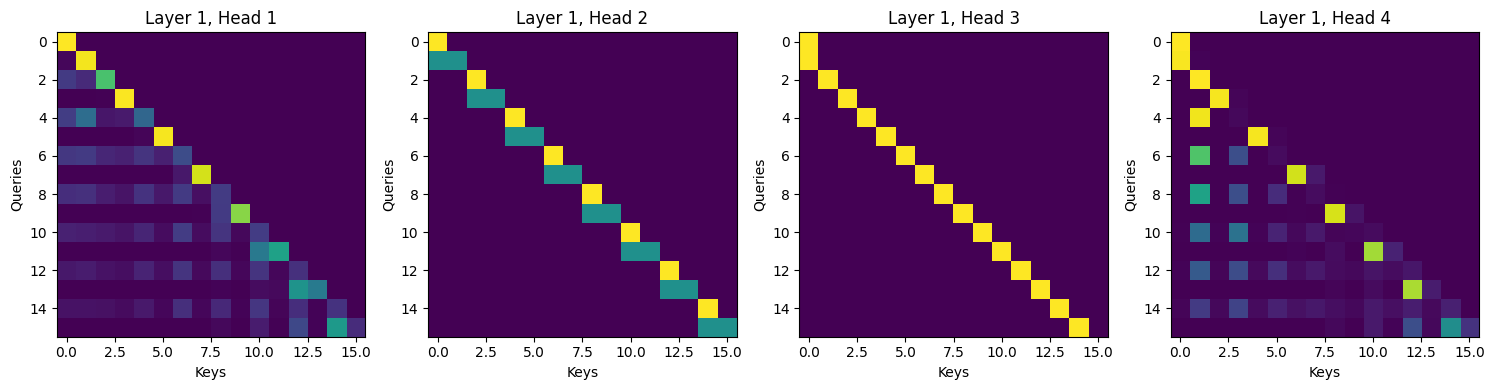

{'pretrain/mse': 0.3804860115675849,
 'pretrain/delta_dmmse': tensor(254.8114, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.0620, device='mps:0'),
 'pretrain/token/0': 0.0,
 'pretrain/token/1': 0.3128649594656394,
 'pretrain/token/2': 1.0676559408727717,
 'pretrain/token/3': 1.532682846138029,
 'pretrain/token/4': 1.8476079817940705,
 'pretrain/token/5': 1.5657485248196903,
 'pretrain/token/6': 0.9957731870797163,
 'pretrain/token/7': 0.8493404827087085,
 'true/mse': -0.002216349858745562,
 'true/delta_dmmse': tensor(0.1963, device='mps:0'),
 'true/delta_ridge': tensor(-0.0041, device='mps:0'),
 'true/token/0': 0.0,
 'true/token/1': -0.008318505079415426,
 'true/token/2': 0.003558735694062952,
 'true/token/3': -0.013730530337234481,
 'true/token/4': 0.009376319359371,
 'true/token/5': -0.0087264504755074,
 'true/token/6': -0.009033320702908796,
 'true/token/7': 0.011588581502825912}

In [118]:
from copy import deepcopy
import operator
from typing import Callable, List

def patch(module: nn.Module):
    if isinstance(module, nn.ModuleList):
        return PatchedList(module)
    elif isinstance(module, nn.Sequential):
        return PatchedSequential(module)
    else:
        return Patched(module)


class Patched(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.__dict__["_current"] = module
        self.__dict__["_original"] = module

        for n, c in self._current.named_children():
            print(n, c)
            self.add_module(n, patch(c))

    def forward(self, *args, **kwargs):
        return self._current(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return self._current.__getattr__(name)
        
    def __setattr__(self, name, value):
        current_value = getattr(self, name)

        if isinstance(current_value, (Patched, PatchedList, PatchedSequential)):
            current_value._current = value
        else:
            super().__setattr__(name, value)

    def set(self, new_value):
        self._current = new_value
    
    def reset(self):
        self._current = self._original

        for c in self._current.children():
            if isinstance(c, (Patched, PatchedList, PatchedSequential)):
                c.reset()

    @property
    def _current(self):
        return self.__dict__["_current"]
    
    @property
    def _original(self):
        return self.__dict__["original"]


class PatchedList(nn.Module):
    def __init__(self, module_list: nn.ModuleList):
        super().__init__()
        module_list = [patch(c) for c in module_list]
        self.__dict__["_current"] = module_list
        self.__dict__["_original"] = module_list

        for i, module in module_list:
            self.add_module(str(i), module)

    def __setattr__(self, name, value):
        current_value = getattr(self, name)

        if isinstance(current_value, (Patched, PatchedList, PatchedSequential)):
            current_value._current = value
        else:
            super().__setattr__(name, value)

    def __setitem__(self, index, value):
        self[index].set(value)

    def __getitem__(self, index):
        return self._current[index]
    
    def __iter__(self):
        return iter(self._current)
    
    def __len__(self):
        return len(self._current)

    def set(self, new_value):
        self._current = new_value
    
    def reset(self):
        self._current = self._original

        for c in self:
            if isinstance(c, (Patched, PatchedList, PatchedSequential)):
                c.reset()

    @property
    def _current(self):
        return self.__dict__["_current"]
    
    @property
    def _original(self):
        return self.__dict__["original"]
    
class PatchedSequential(PatchedList):
    def forward(self, x):
        for layer in self:
            x = layer(x)

        return x


def set_head_to(i, output):
    def new_softmax(self, x):
        y = nn.functional.softmax(x, dim=-1)
        y[:, i, :, :] = output
        return y 
    
    return new_softmax

def set_heads_to(mappings):
    def new_softmax(self, x):
        y = nn.functional.softmax(x, dim=-1)

        for k, v in mappings.items():
            y[:, k, :, :] = v
        return y 
    
    return new_softmax

class Patch(nn.Module):
    def __init__(self, callable: Callable):
        self.callable = callable

    def forward(self, *args, **kwargs):
        return self.callable(*args, **kwargs)


def patch_(module: nn.Module, callable: Callable):
    if isinstance(module, Hooked):
        module._original = module._forward
        module._forward = callable

        def reset():
            module._forward = module._original
            del module._forward
            del module.reset

        module.reset = reset
        return module

    else:
        module._original = module.forward
        module.forward = callable

        def reset():
            module.forward = module._original
            del module._forward
            del module.reset

        module.reset = reset
        return module

model = deepcopy(run.model)
patched_model = model #  patch(model)
hooked_patched_model = hook(patched_model) # hook(patch(run.model))

def apply_binop_dicts(d1, d2, op):
    return {
        k: op(d1[k], d2[k]) for k in d1.keys()
    }

# probe = ActivationProbe(masked_model, "token_sequence_transformer.blocks.0.attention.attention_softmax")
# probe.register_hook()
_, activations = hooked_patched_model.run_with_cache(x_trick[:2], y_trick[:2])
plot_activations([activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]])

evals_1 = run.evaluator(hooked_patched_model)

head_2 = torch.zeros((16, 16), device="mps")
for i in range(0,16, 2):
    head_2[i, i] = 1

for i in range(0, 16, 2):
    head_2[i+1, i] = head_2[i+1, i+1] = 0.5


head_3 = torch.zeros((16, 16), device="mps")
for i in range(15):
    head_3[i+1, i] = 1
head_3[0, 0] = 1

layer = patch_(hooked_patched_model.token_sequence_transformer.blocks[0].attention.attention_softmax, set_heads_to({1: head_2, 2: head_3}))
_, activations = hooked_patched_model.run_with_cache(x_trick[:2], y_trick[:2])
plot_activations([activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]])

evals_2 = run.evaluator(hooked_patched_model)

apply_binop_dicts(evals_1, evals_2, lambda x, y: (y-x)/x)


In [5]:
# Ready to investigate
run.model

InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

In [26]:
from typing import List
from torchtyping import TensorType


def get_attention(model, xs, ys):
    num_layers = len(model.token_sequence_transformer.blocks)
    probes = []

    for b in range(num_layers):
        probe = ActivationProbe(model, f"token_sequence_transformer.blocks.{b}.attention.attention_softmax")
        probe.register_hook()
        probes.append(probe)

    # Run the model
    model(xs, ys)

    for probe in probes:
        probe.unregister_hook()

    # Get the activations
    return [probe.activation for probe in probes]

def plot_activations(activations: List[TensorType["batch", "heads", "tokens", "tokens"]]):       
    num_layers = len(activations)
    num_samples, num_heads, num_tokens, _ = activations[0].shape

    for sample_idx in range(num_samples):
        # Create a new figure
        plt.figure(figsize=(15, 4 * num_layers))

        # Loop through each head
        for layer_idx, activation in enumerate(activations):
            for head_idx in range(num_heads):
                head_activation = activation[sample_idx, head_idx].detach().cpu().numpy()

                # Create a subplot for each head
                ax = plt.subplot(num_layers, num_heads, layer_idx * num_heads + head_idx + 1)

                # Plot the activation
                ax.imshow(head_activation, cmap='viridis', aspect='auto')

                # Add title and labels
                ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
                ax.set_xlabel('Keys')
                ax.set_ylabel('Queries')

        plt.tight_layout()
        plt.show()

def compose2(f, g):
    return lambda *a, **kw: f(g(*a, **kw))

def compose(*fs):
    from functools import reduce
    return reduce(compose2, fs)

get_and_plot_activations = compose(plot_activations, get_attention)

In [13]:
ws = run.pretrain_dist.task_distribution.tasks
print(ws)

tensor([[-1.5256, -0.7502, -0.6540, -1.6095],
        [-0.1002, -0.6092, -0.9798, -1.6091],
        [-0.7121,  0.3037, -0.7773, -0.2515],
        [-0.2223,  1.6871,  0.2284,  0.4676]], device='mps:0')


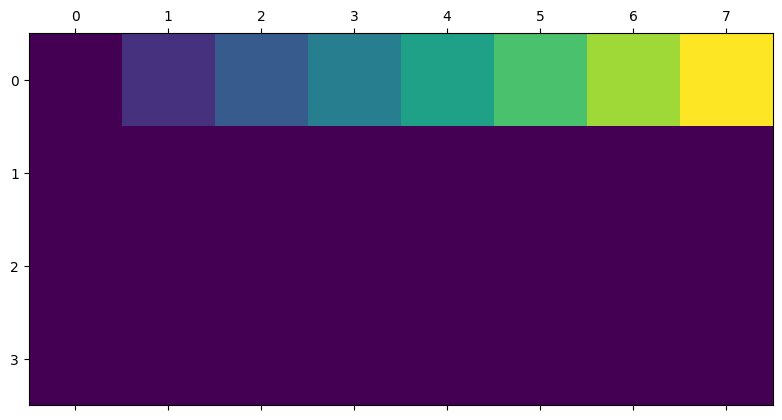

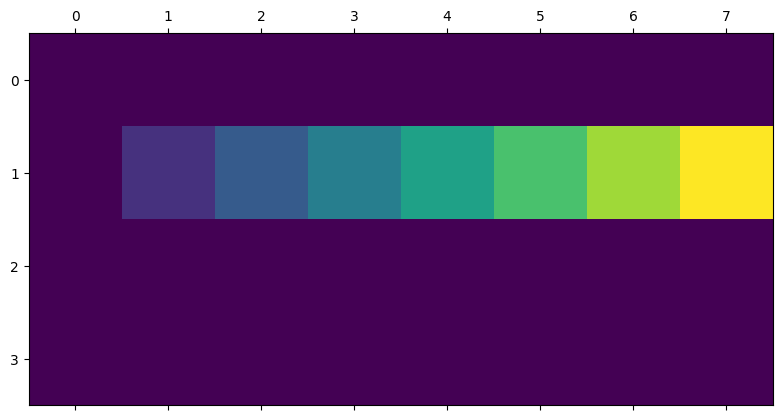

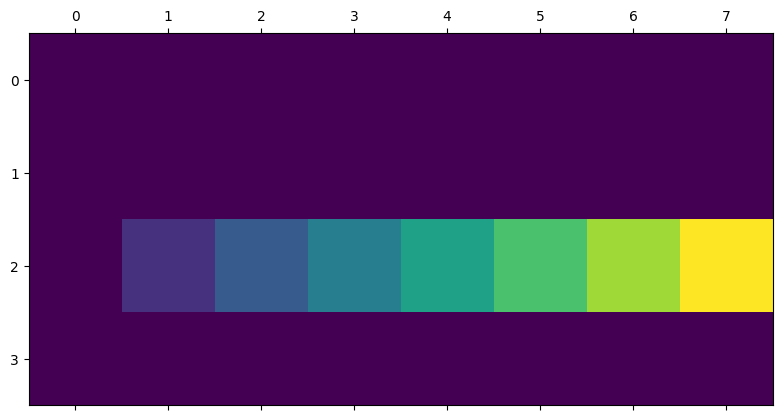

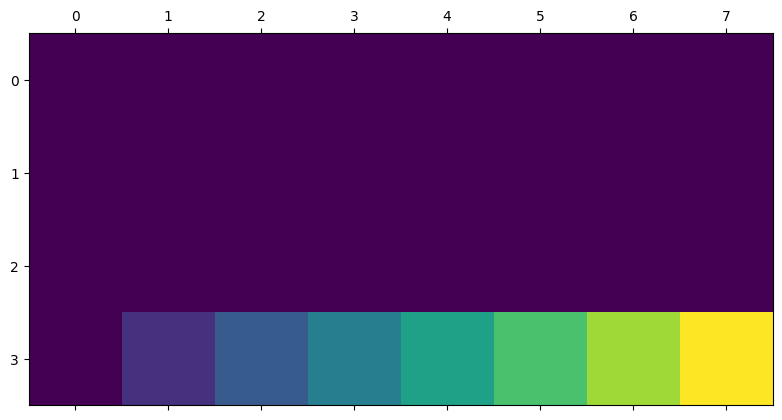

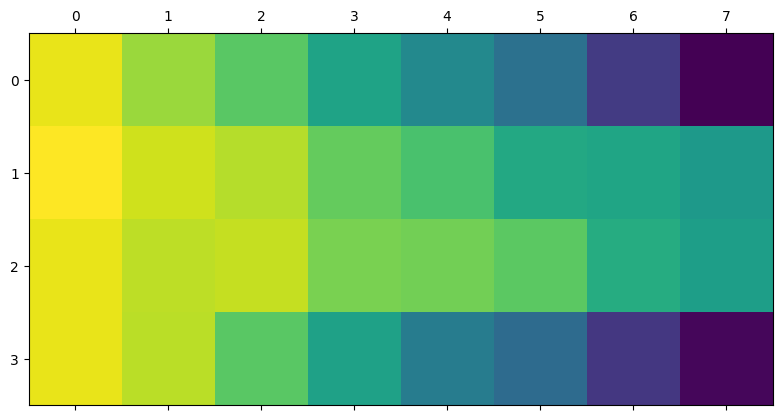

In [19]:
from icl.tasks import apply_transformations

# x_trick = torch.zeros((4, 8, 4))
# x_trick[:, :, 0] = torch.arange(0, 8)
# # y_trick = torch.zeros((1, 8, 1))
# x_trick = x_trick.to("mps")
# y_trick = apply_transformations(ws, x_trick, run.pretrain_dist.std, device="mps")

x_trick = torch.zeros((4, 8, 4))
for i in range(4):
    x_trick[i, :, i] = torch.arange(0, 8)

# y_trick = torch.zeros((1, 8, 1))
x_trick = x_trick.to("mps")
y_trick = apply_transformations(ws[0].repeat(4), x_trick, run.pretrain_dist.std, device="mps")

for i in range(4):
    plt.matshow(x_trick[i].T.detach().cpu().numpy())

plt.matshow(y_trick.detach().cpu().numpy())

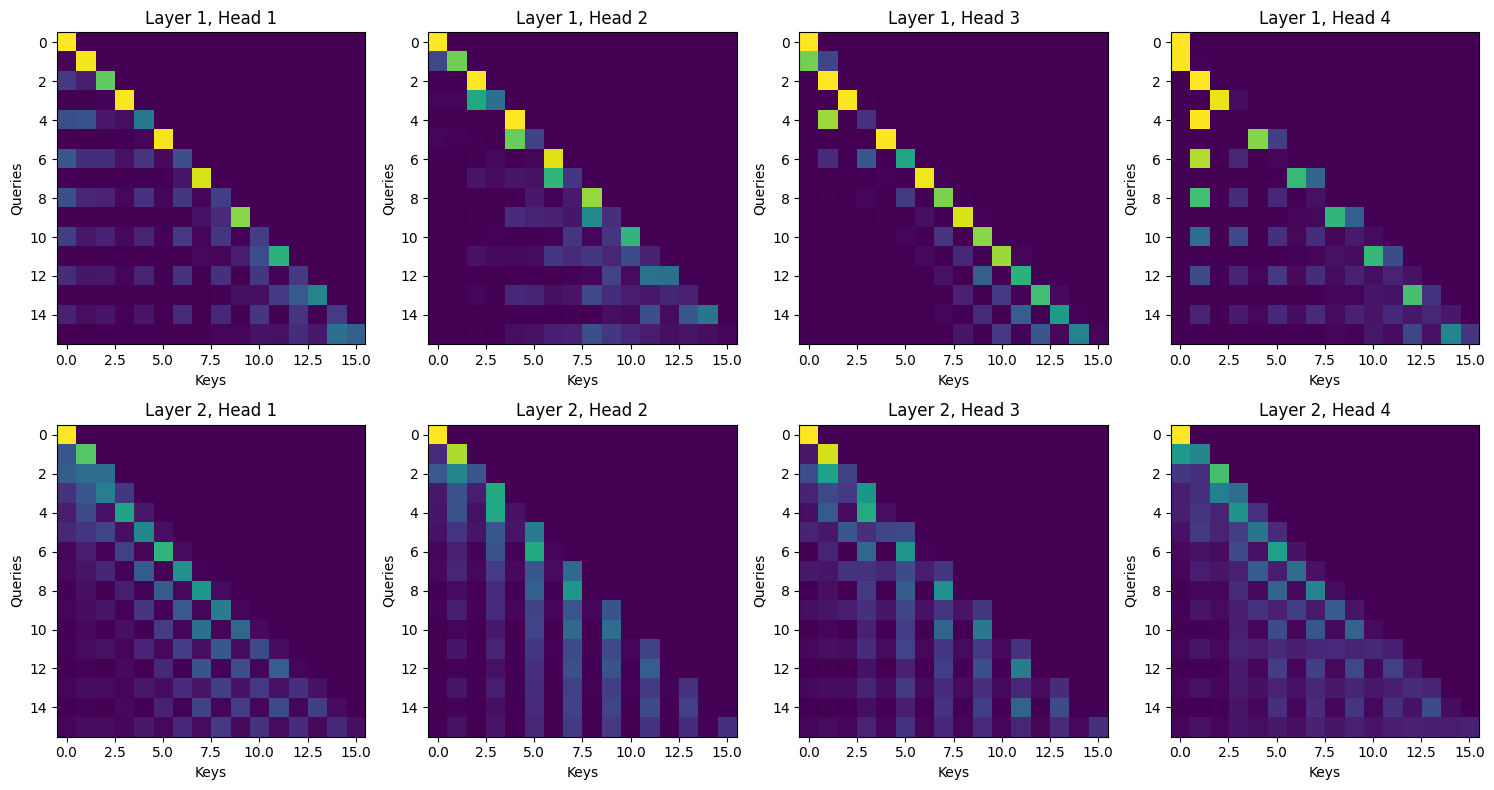

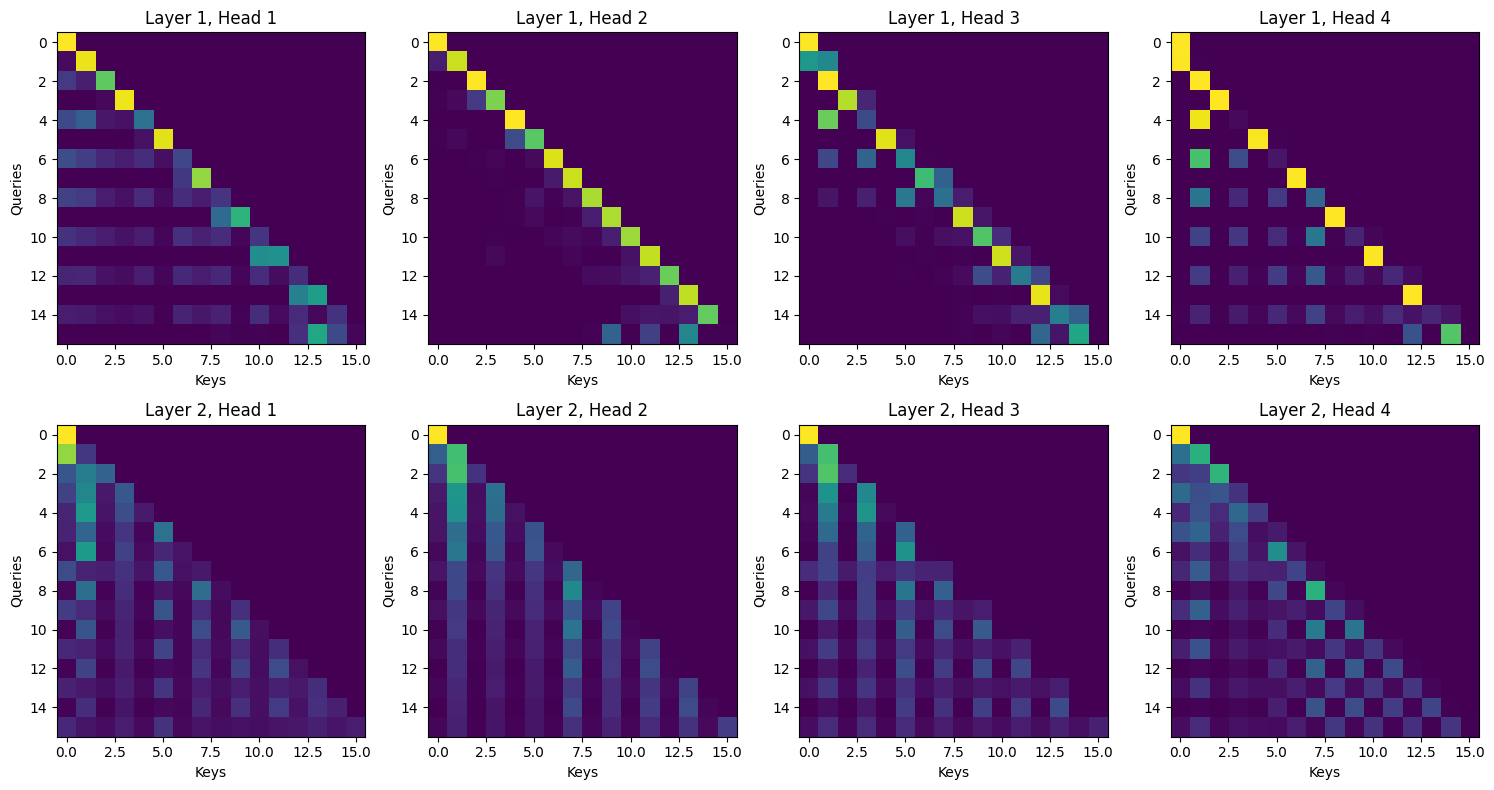

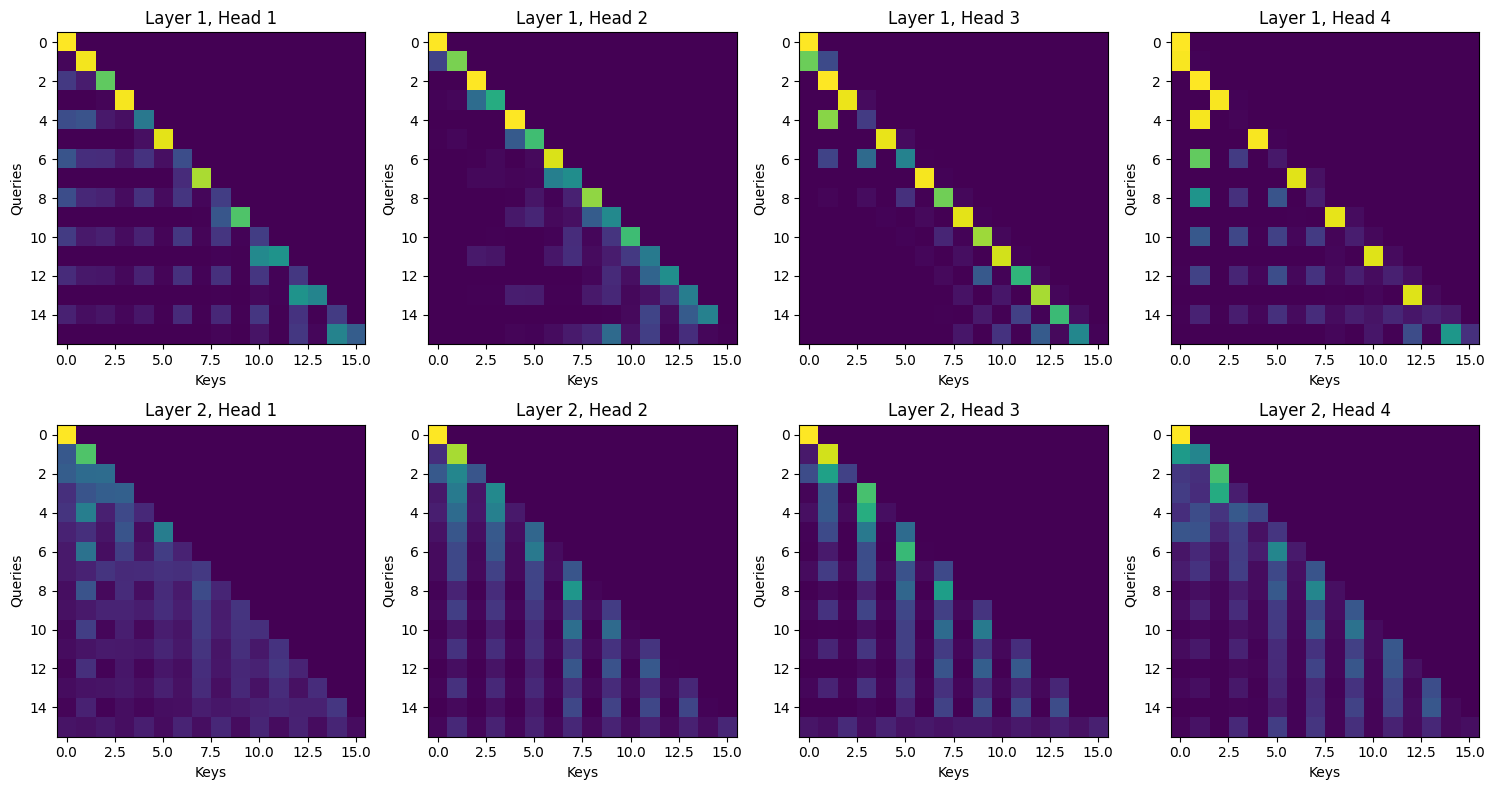

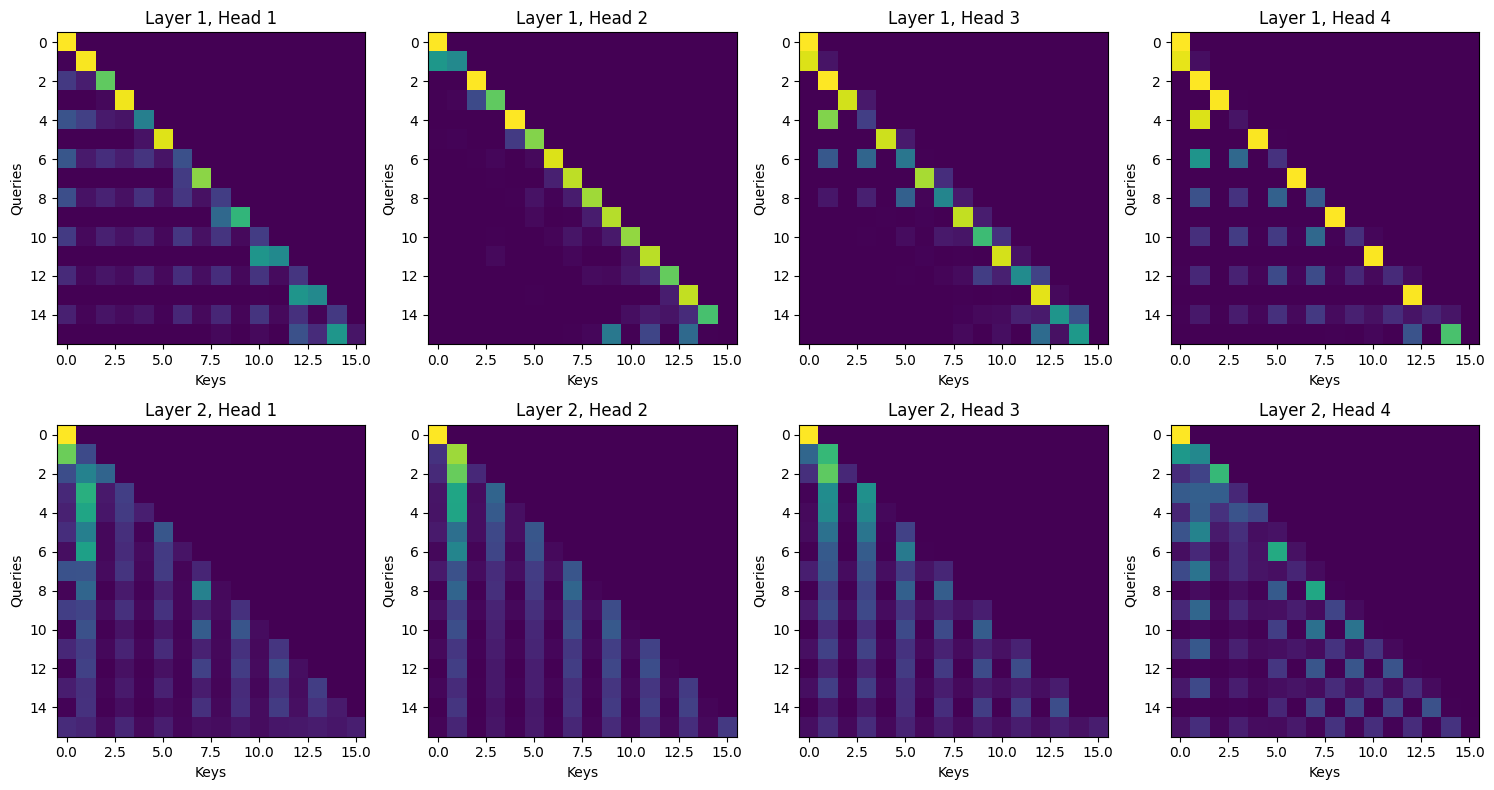

In [26]:
# xs, ys = run.pretrain_dist.get_batch(8, 1)
# get_and_plot_activations(run.model, xs=xs, ys=ys)
get_and_plot_activations(run.model, xs=x_trick, ys=y_trick)

/Users/Jesse/Projects/devinterp/devinterp/utils.py:46: UserWarning: Number of steps in int_logspace is not 100, got 91.
/Users/Jesse/Projects/devinterp/devinterp/utils.py:46: UserWarning: Number of steps in int_logspace is not 50, got 47.
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


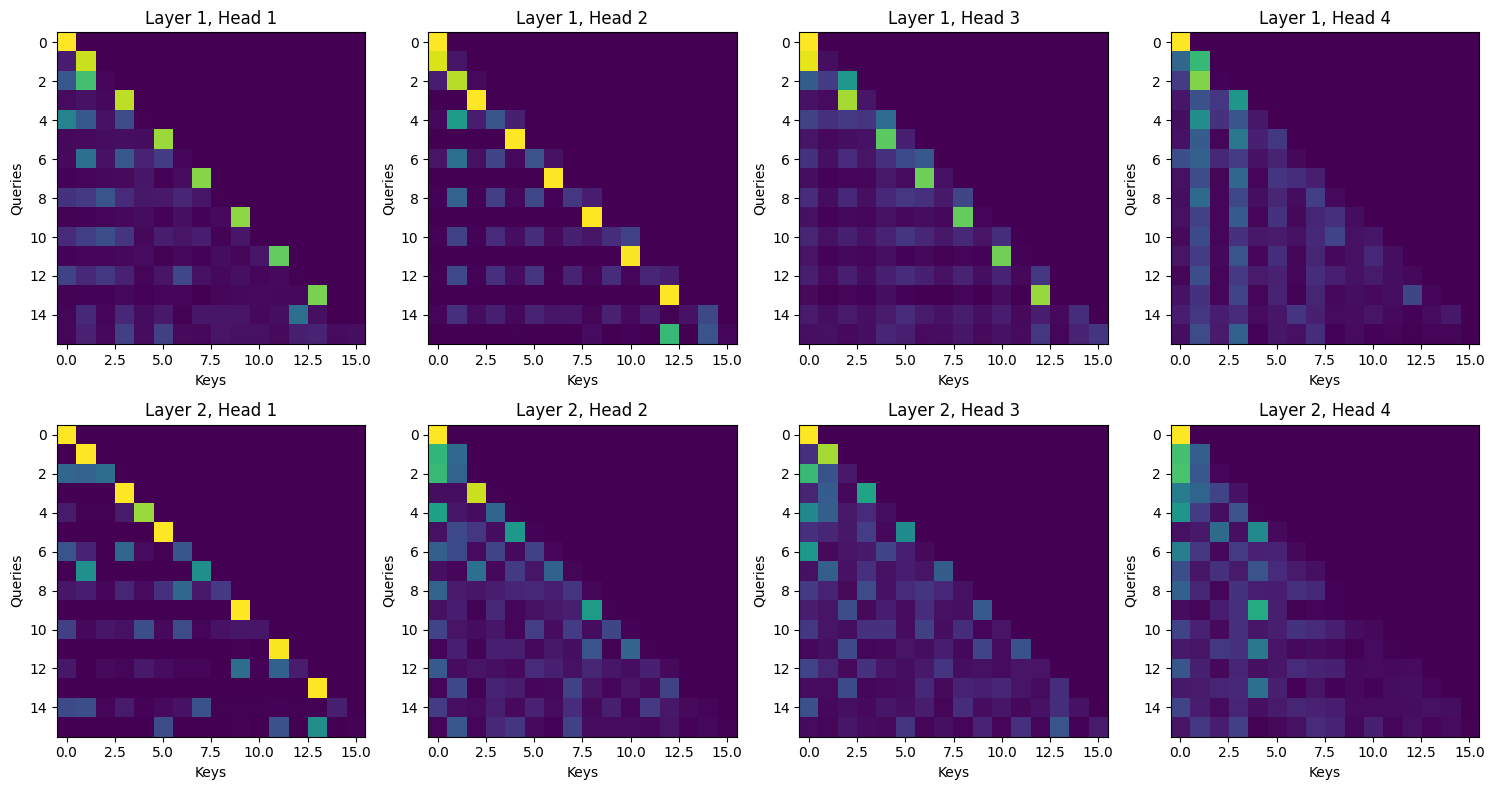

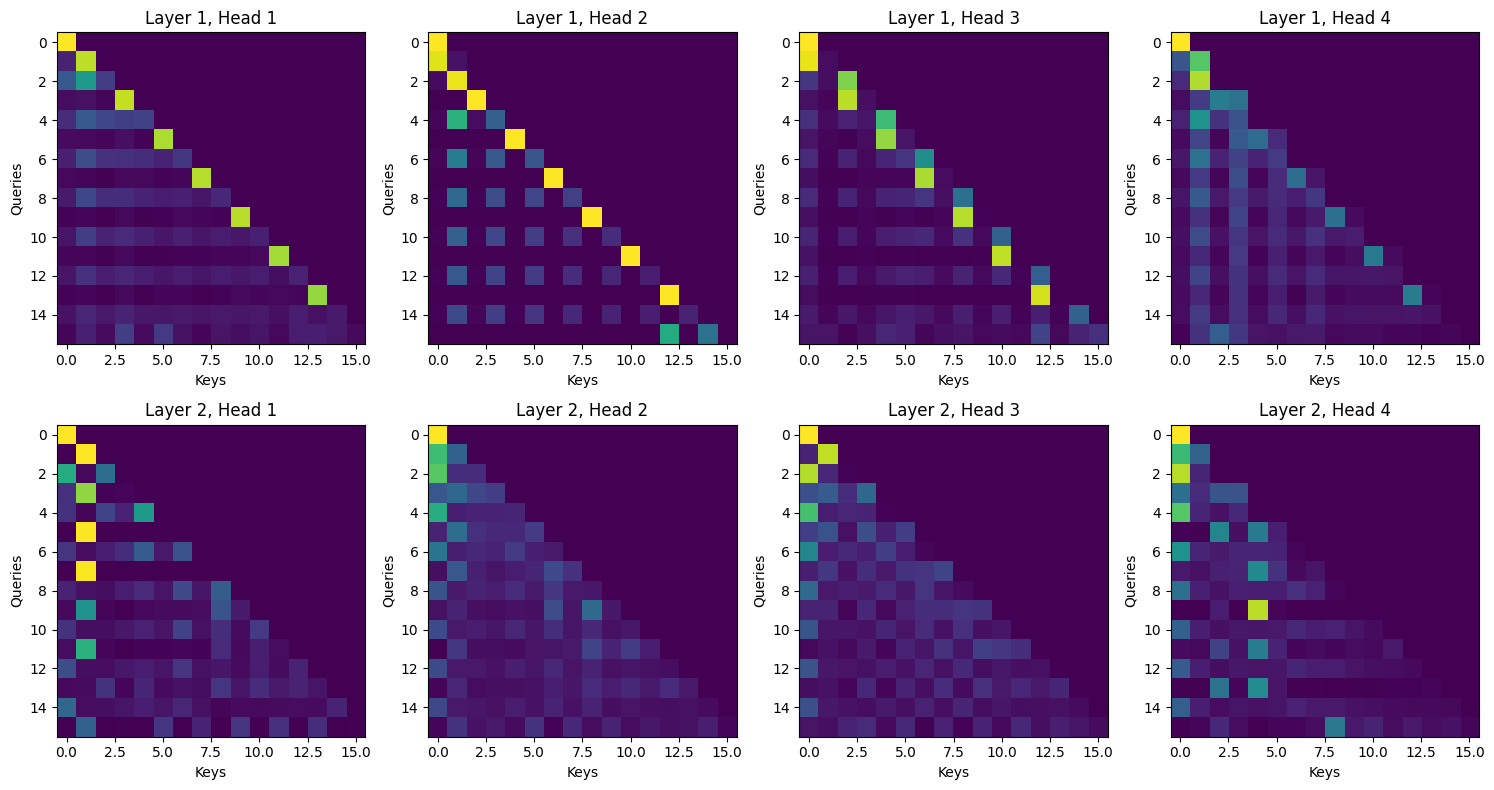

In [123]:
run_2 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 65536, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_2, ys_2 = run_2.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_2.model, xs=xs_2, ys=ys_2)
get_and_plot_activations(run_2.model, xs=x_trick, ys=y_trick)

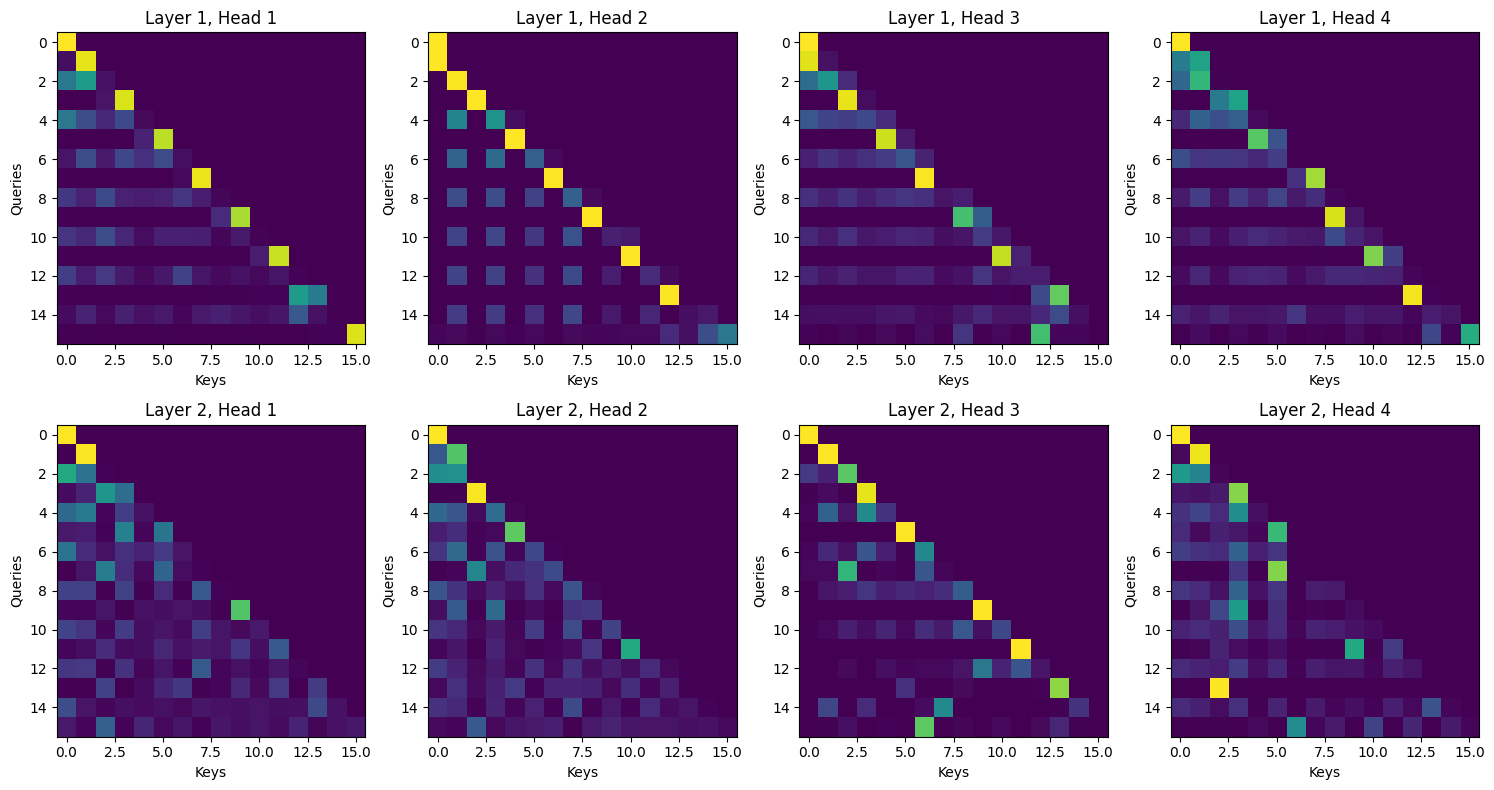

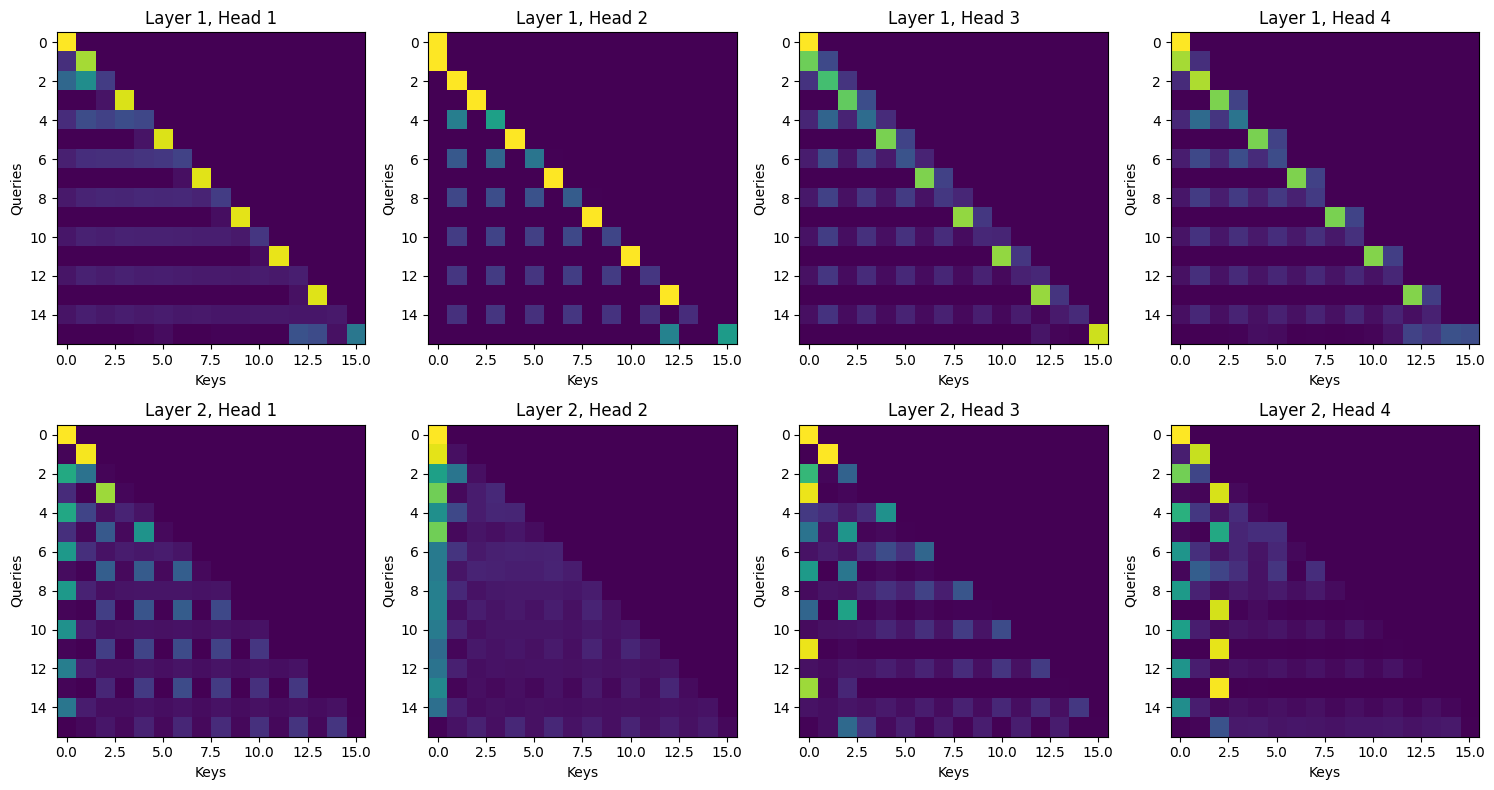

In [124]:
run_3 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 64, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_3, ys_3 = run_3.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_3.model, xs=xs_3, ys=ys_3)
get_and_plot_activations(run_3.model, xs=x_trick, ys=y_trick)